# Optimisation search
Created 26/05/2024

Objectives:
* Run through different optimisation schemes. Can we optimise parameters?

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [69]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [70]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [71]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [72]:
psi = loaded_data_non_triv_proj_rep[0]

In [73]:
from collections import Counter

In [74]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [75]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [76]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [15]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [16]:
q2 = q1.copy(deep=True)

symmetry_sites = list(range(60, 60+80, 2))
for i in symmetry_sites:

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [17]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = quimb_psi.copy()
    q_bottom.reindex(index_mapping, inplace=True)

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [18]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

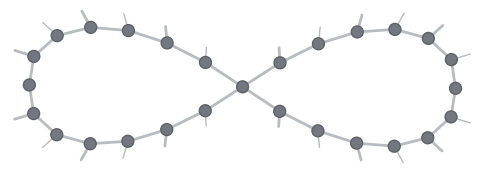

In [19]:
problem_rdm.draw()

## Initial mpos

In [20]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80

In [21]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    tags='left_mpo'
)

In [22]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    tags='right_mpo'
)

In [23]:
mpo = (ml & mr)

## Optimisation functions

In [24]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [82]:
abs(1+1j)

1.4142135623730951

In [25]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs = abs(c)

    loss = (c_abs - 1)**2

    return loss

In [26]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [27]:
total_physical_dim = 2**9

In [28]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [29]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [30]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    return n4 - 2*n2 + total_physical_dim

In [31]:
unitarity_tn(ml, total_physical_dim)

510.0130679233183

In [32]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [33]:
overall_loss_function(
    mpo,
    problem_rdm,
    total_physical_dim
)

1021.027005526911

# Optimization runs

## L-BFGS-B

In [43]:
loss_data=list()

In [45]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [46]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

+1070.025819495139 [best: +1070.025819495139] :   0%|                                                                                                                      | 1/1000 [00:00<02:45,  6.05it/s]

+1035.481069807753 [best: +1035.481069807753] :   0%|▏                                                                                                                     | 2/1000 [00:00<02:45,  6.05it/s]

+6236099.507306354120 [best: +1035.481069807753] :   0%|▎                                                                                                                  | 3/1000 [00:00<01:46,  9.38it/s]

+1374.309631263305 [best: +1035.481069807753] :   0%|▍                                                                                                                     | 4/1000 [00:00<01:46,  9.38it/s]

+1004.781013955628 [best: +1004.781013955628] :   0%|▌                                                                                                                     | 5/1000 [00:00<01:34, 10.48it/s]

+998.284897936905 [best: +998.284897936905] :   1%|▋                                                                                                                       | 6/1000 [00:00<01:34, 10.48it/s]

+995.390193242364 [best: +995.390193242364] :   1%|▊                                                                                                                       | 7/1000 [00:00<01:30, 10.98it/s]

+993.796665036630 [best: +993.796665036630] :   1%|▉                                                                                                                       | 8/1000 [00:00<01:30, 10.98it/s]

+13452.184049168918 [best: +993.796665036630] :   1%|█                                                                                                                     | 9/1000 [00:00<01:29, 11.03it/s]

+1051.246045276988 [best: +993.796665036630] :   1%|█▏                                                                                                                    | 10/1000 [00:00<01:29, 11.03it/s]

+993.701217370764 [best: +993.701217370764] :   1%|█▎                                                                                                                     | 11/1000 [00:01<01:26, 11.38it/s]

+970.634082441032 [best: +970.634082441032] :   1%|█▍                                                                                                                     | 12/1000 [00:01<01:26, 11.38it/s]

+1010.271648092817 [best: +970.634082441032] :   1%|█▌                                                                                                                    | 13/1000 [00:01<01:24, 11.62it/s]

+932.555150785427 [best: +932.555150785427] :   1%|█▋                                                                                                                     | 14/1000 [00:01<01:24, 11.62it/s]

+16688.865014265171 [best: +932.555150785427] :   2%|█▊                                                                                                                   | 15/1000 [00:01<01:23, 11.86it/s]

+952.568147683942 [best: +932.555150785427] :   2%|█▉                                                                                                                     | 16/1000 [00:01<01:22, 11.86it/s]

+920.015233801618 [best: +920.015233801618] :   2%|██                                                                                                                     | 17/1000 [00:01<01:21, 12.02it/s]

+866.266962201099 [best: +866.266962201099] :   2%|██▏                                                                                                                    | 18/1000 [00:01<01:21, 12.02it/s]

+791.604182144890 [best: +791.604182144890] :   2%|██▎                                                                                                                    | 19/1000 [00:01<01:21, 12.08it/s]

+707.510939544037 [best: +707.510939544037] :   2%|██▍                                                                                                                    | 20/1000 [00:01<01:21, 12.08it/s]

+666.781701758342 [best: +666.781701758342] :   2%|██▍                                                                                                                    | 21/1000 [00:01<01:20, 12.14it/s]

+935.929720831455 [best: +666.781701758342] :   2%|██▌                                                                                                                    | 22/1000 [00:01<01:20, 12.14it/s]

+645.397993050678 [best: +645.397993050678] :   2%|██▋                                                                                                                    | 23/1000 [00:02<01:20, 12.12it/s]

+607.325252781749 [best: +607.325252781749] :   2%|██▊                                                                                                                    | 24/1000 [00:02<01:20, 12.12it/s]

+539.168275765865 [best: +539.168275765865] :   2%|██▉                                                                                                                    | 25/1000 [00:02<01:21, 11.94it/s]

+512.625847443200 [best: +512.625847443200] :   3%|███                                                                                                                    | 26/1000 [00:02<01:21, 11.94it/s]

+473.332846327459 [best: +473.332846327459] :   3%|███▏                                                                                                                   | 27/1000 [00:02<01:20, 12.11it/s]

+426.870939696593 [best: +426.870939696593] :   3%|███▎                                                                                                                   | 28/1000 [00:02<01:20, 12.11it/s]

+388.081470314470 [best: +388.081470314470] :   3%|███▍                                                                                                                   | 29/1000 [00:02<01:18, 12.32it/s]

+355.579443539692 [best: +355.579443539692] :   3%|███▌                                                                                                                   | 30/1000 [00:02<01:18, 12.32it/s]

+318.098252010787 [best: +318.098252010787] :   3%|███▋                                                                                                                   | 31/1000 [00:02<01:17, 12.49it/s]

+282.729525971696 [best: +282.729525971696] :   3%|███▊                                                                                                                   | 32/1000 [00:02<01:17, 12.49it/s]

+261.069097574949 [best: +261.069097574949] :   3%|███▉                                                                                                                   | 33/1000 [00:02<01:16, 12.62it/s]

+248.638768058985 [best: +248.638768058985] :   3%|████                                                                                                                   | 34/1000 [00:02<01:16, 12.62it/s]

+226.963715263933 [best: +226.963715263933] :   4%|████▏                                                                                                                  | 35/1000 [00:02<01:15, 12.75it/s]

+213.164090195961 [best: +213.164090195961] :   4%|████▎                                                                                                                  | 36/1000 [00:03<01:15, 12.75it/s]

+173.310473430956 [best: +173.310473430956] :   4%|████▍                                                                                                                  | 37/1000 [00:03<01:15, 12.82it/s]

+149.259747889014 [best: +149.259747889014] :   4%|████▌                                                                                                                  | 38/1000 [00:03<01:15, 12.82it/s]

+128.120580834629 [best: +128.120580834629] :   4%|████▋                                                                                                                  | 39/1000 [00:03<01:14, 12.89it/s]

+112.463703027456 [best: +112.463703027456] :   4%|████▊                                                                                                                  | 40/1000 [00:03<01:14, 12.89it/s]

+97.631282241367 [best: +97.631282241367] :   4%|████▉                                                                                                                    | 41/1000 [00:03<01:15, 12.79it/s]

+90.784998538148 [best: +90.784998538148] :   4%|█████                                                                                                                    | 42/1000 [00:03<01:14, 12.79it/s]

+83.865774706578 [best: +83.865774706578] :   4%|█████▏                                                                                                                   | 43/1000 [00:03<01:15, 12.62it/s]

+79.765098829428 [best: +79.765098829428] :   4%|█████▎                                                                                                                   | 44/1000 [00:03<01:15, 12.62it/s]

+76.561061043387 [best: +76.561061043387] :   4%|█████▍                                                                                                                   | 45/1000 [00:03<01:15, 12.70it/s]

+74.347524604917 [best: +74.347524604917] :   5%|█████▌                                                                                                                   | 46/1000 [00:03<01:15, 12.70it/s]

+72.611581086705 [best: +72.611581086705] :   5%|█████▋                                                                                                                   | 47/1000 [00:03<01:15, 12.54it/s]

+71.167449789527 [best: +71.167449789527] :   5%|█████▊                                                                                                                   | 48/1000 [00:03<01:15, 12.54it/s]

+69.554275526709 [best: +69.554275526709] :   5%|█████▉                                                                                                                   | 49/1000 [00:04<01:16, 12.44it/s]

+67.712957057743 [best: +67.712957057743] :   5%|██████                                                                                                                   | 50/1000 [00:04<01:16, 12.44it/s]

+65.022089462122 [best: +65.022089462122] :   5%|██████▏                                                                                                                  | 51/1000 [00:04<01:15, 12.55it/s]

+62.049872571649 [best: +62.049872571649] :   5%|██████▎                                                                                                                  | 52/1000 [00:04<01:15, 12.55it/s]

+59.269930380414 [best: +59.269930380414] :   5%|██████▍                                                                                                                  | 53/1000 [00:04<01:14, 12.66it/s]

+60.509227125068 [best: +59.269930380414] :   5%|██████▌                                                                                                                  | 54/1000 [00:04<01:14, 12.66it/s]

+55.806323300689 [best: +55.806323300689] :   6%|██████▋                                                                                                                  | 55/1000 [00:04<01:14, 12.65it/s]

+54.299460177916 [best: +54.299460177916] :   6%|██████▊                                                                                                                  | 56/1000 [00:04<01:14, 12.65it/s]

+53.364964277657 [best: +53.364964277657] :   6%|██████▉                                                                                                                  | 57/1000 [00:04<01:14, 12.72it/s]

+52.606927475762 [best: +52.606927475762] :   6%|███████                                                                                                                  | 58/1000 [00:04<01:14, 12.72it/s]

+52.276474641568 [best: +52.276474641568] :   6%|███████▏                                                                                                                 | 59/1000 [00:04<01:13, 12.77it/s]

+51.961670815277 [best: +51.961670815277] :   6%|███████▎                                                                                                                 | 60/1000 [00:04<01:13, 12.77it/s]

+51.735835016716 [best: +51.735835016716] :   6%|███████▍                                                                                                                 | 61/1000 [00:05<01:13, 12.70it/s]

+51.513908388283 [best: +51.513908388283] :   6%|███████▌                                                                                                                 | 62/1000 [00:05<01:13, 12.70it/s]

+51.266252107627 [best: +51.266252107627] :   6%|███████▌                                                                                                                 | 63/1000 [00:05<01:14, 12.55it/s]

+51.127994572723 [best: +51.127994572723] :   6%|███████▋                                                                                                                 | 64/1000 [00:05<01:14, 12.55it/s]

+51.028634931009 [best: +51.028634931009] :   6%|███████▊                                                                                                                 | 65/1000 [00:05<01:14, 12.48it/s]

+50.945578157087 [best: +50.945578157087] :   7%|███████▉                                                                                                                 | 66/1000 [00:05<01:14, 12.48it/s]

+50.886019405175 [best: +50.886019405175] :   7%|████████                                                                                                                 | 67/1000 [00:05<01:14, 12.49it/s]

+50.851221115480 [best: +50.851221115480] :   7%|████████▏                                                                                                                | 68/1000 [00:05<01:14, 12.49it/s]

+50.774514878380 [best: +50.774514878380] :   7%|████████▎                                                                                                                | 69/1000 [00:05<01:14, 12.55it/s]

+50.707727165249 [best: +50.707727165249] :   7%|████████▍                                                                                                                | 70/1000 [00:05<01:14, 12.55it/s]

+50.580696761860 [best: +50.580696761860] :   7%|████████▌                                                                                                                | 71/1000 [00:05<01:13, 12.67it/s]

+50.661550424834 [best: +50.580696761860] :   7%|████████▋                                                                                                                | 72/1000 [00:05<01:13, 12.67it/s]

+50.523886393378 [best: +50.523886393378] :   7%|████████▊                                                                                                                | 73/1000 [00:05<01:12, 12.78it/s]

+50.462076306055 [best: +50.462076306055] :   7%|████████▉                                                                                                                | 74/1000 [00:06<01:12, 12.78it/s]

+50.428867269817 [best: +50.428867269817] :   8%|█████████                                                                                                                | 75/1000 [00:06<01:39,  9.27it/s]

+50.395127099947 [best: +50.395127099947] :   8%|█████████▏                                                                                                               | 76/1000 [00:06<01:39,  9.27it/s]

+50.353546354211 [best: +50.353546354211] :   8%|█████████▎                                                                                                               | 77/1000 [00:06<01:30, 10.16it/s]

+50.363440440329 [best: +50.353546354211] :   8%|█████████▍                                                                                                               | 78/1000 [00:06<01:30, 10.16it/s]

+50.336532568550 [best: +50.336532568550] :   8%|█████████▌                                                                                                               | 79/1000 [00:06<01:24, 10.86it/s]

+50.319664472384 [best: +50.319664472384] :   8%|█████████▋                                                                                                               | 80/1000 [00:06<01:24, 10.86it/s]

+50.305242369340 [best: +50.305242369340] :   8%|█████████▊                                                                                                               | 81/1000 [00:06<01:20, 11.42it/s]

+50.289526015995 [best: +50.289526015995] :   8%|█████████▉                                                                                                               | 82/1000 [00:06<01:20, 11.42it/s]

+50.269218526196 [best: +50.269218526196] :   8%|██████████                                                                                                               | 83/1000 [00:06<01:17, 11.86it/s]

+50.246284295625 [best: +50.246284295625] :   8%|██████████▏                                                                                                              | 84/1000 [00:07<01:17, 11.86it/s]

+50.231515610227 [best: +50.231515610227] :   8%|██████████▎                                                                                                              | 85/1000 [00:07<01:15, 12.19it/s]

+50.221488172680 [best: +50.221488172680] :   9%|██████████▍                                                                                                              | 86/1000 [00:07<01:14, 12.19it/s]

+50.215341463208 [best: +50.215341463208] :   9%|██████████▌                                                                                                              | 87/1000 [00:07<01:13, 12.42it/s]

+50.208558490385 [best: +50.208558490385] :   9%|██████████▋                                                                                                              | 88/1000 [00:07<01:13, 12.42it/s]

+50.204595297376 [best: +50.204595297376] :   9%|██████████▊                                                                                                              | 89/1000 [00:07<01:12, 12.60it/s]

+50.199074460169 [best: +50.199074460169] :   9%|██████████▉                                                                                                              | 90/1000 [00:07<01:12, 12.60it/s]

+50.194211563346 [best: +50.194211563346] :   9%|███████████                                                                                                              | 91/1000 [00:07<01:11, 12.73it/s]

+50.186216295599 [best: +50.186216295599] :   9%|███████████▏                                                                                                             | 92/1000 [00:07<01:11, 12.73it/s]

+50.181351778165 [best: +50.181351778165] :   9%|███████████▎                                                                                                             | 93/1000 [00:07<01:10, 12.81it/s]

+50.173726896114 [best: +50.173726896114] :   9%|███████████▎                                                                                                             | 94/1000 [00:07<01:10, 12.81it/s]

+50.165046771802 [best: +50.165046771802] :  10%|███████████▍                                                                                                             | 95/1000 [00:07<01:10, 12.77it/s]

+50.154484593582 [best: +50.154484593582] :  10%|███████████▌                                                                                                             | 96/1000 [00:07<01:10, 12.77it/s]

+50.148310917383 [best: +50.148310917383] :  10%|███████████▋                                                                                                             | 97/1000 [00:08<01:10, 12.75it/s]

+50.140568290842 [best: +50.140568290842] :  10%|███████████▊                                                                                                             | 98/1000 [00:08<01:10, 12.75it/s]

+50.142637128326 [best: +50.140568290842] :  10%|███████████▉                                                                                                             | 99/1000 [00:08<01:10, 12.80it/s]

+50.136967033821 [best: +50.136967033821] :  10%|████████████                                                                                                            | 100/1000 [00:08<01:10, 12.80it/s]

+50.130743946601 [best: +50.130743946601] :  10%|████████████                                                                                                            | 101/1000 [00:08<01:10, 12.79it/s]

+50.125541992482 [best: +50.125541992482] :  10%|████████████▏                                                                                                           | 102/1000 [00:08<01:10, 12.79it/s]

+50.120842588645 [best: +50.120842588645] :  10%|████████████▎                                                                                                           | 103/1000 [00:08<01:10, 12.80it/s]

+50.116236671105 [best: +50.116236671105] :  10%|████████████▍                                                                                                           | 104/1000 [00:08<01:10, 12.80it/s]

+50.111325541534 [best: +50.111325541534] :  10%|████████████▌                                                                                                           | 105/1000 [00:08<01:09, 12.79it/s]

+50.107556359022 [best: +50.107556359022] :  11%|████████████▋                                                                                                           | 106/1000 [00:08<01:09, 12.79it/s]

+50.100966859920 [best: +50.100966859920] :  11%|████████████▊                                                                                                           | 107/1000 [00:08<01:10, 12.60it/s]

+50.094663012594 [best: +50.094663012594] :  11%|████████████▉                                                                                                           | 108/1000 [00:08<01:10, 12.60it/s]

+50.088090348770 [best: +50.088090348770] :  11%|█████████████                                                                                                           | 109/1000 [00:08<01:10, 12.56it/s]

+50.083362010979 [best: +50.083362010979] :  11%|█████████████▏                                                                                                          | 110/1000 [00:09<01:10, 12.56it/s]

+50.076937534104 [best: +50.076937534104] :  11%|█████████████▎                                                                                                          | 111/1000 [00:09<01:14, 11.89it/s]

+50.071331793729 [best: +50.071331793729] :  11%|█████████████▍                                                                                                          | 112/1000 [00:09<01:14, 11.89it/s]

+50.066810294372 [best: +50.066810294372] :  11%|█████████████▌                                                                                                          | 113/1000 [00:09<01:15, 11.77it/s]

+50.063143164939 [best: +50.063143164939] :  11%|█████████████▋                                                                                                          | 114/1000 [00:09<01:15, 11.77it/s]

+50.060421533202 [best: +50.060421533202] :  12%|█████████████▊                                                                                                          | 115/1000 [00:09<01:13, 12.02it/s]

+50.058382068882 [best: +50.058382068882] :  12%|█████████████▉                                                                                                          | 116/1000 [00:09<01:13, 12.02it/s]

+50.054227493877 [best: +50.054227493877] :  12%|██████████████                                                                                                          | 117/1000 [00:09<01:11, 12.28it/s]

+50.051461144796 [best: +50.051461144796] :  12%|██████████████▏                                                                                                         | 118/1000 [00:09<01:11, 12.28it/s]

+50.048205232379 [best: +50.048205232379] :  12%|██████████████▎                                                                                                         | 119/1000 [00:09<01:10, 12.47it/s]

+50.046579331539 [best: +50.046579331539] :  12%|██████████████▍                                                                                                         | 120/1000 [00:09<01:10, 12.47it/s]

+50.044241507767 [best: +50.044241507767] :  12%|██████████████▌                                                                                                         | 121/1000 [00:09<01:10, 12.55it/s]

+50.041610499339 [best: +50.041610499339] :  12%|██████████████▋                                                                                                         | 122/1000 [00:10<01:09, 12.55it/s]

+50.039913388214 [best: +50.039913388214] :  12%|██████████████▊                                                                                                         | 123/1000 [00:10<01:09, 12.65it/s]

+50.038048896331 [best: +50.038048896331] :  12%|██████████████▉                                                                                                         | 124/1000 [00:10<01:09, 12.65it/s]

+50.037181558987 [best: +50.037181558987] :  12%|███████████████                                                                                                         | 125/1000 [00:10<01:08, 12.71it/s]

+50.036235854068 [best: +50.036235854068] :  13%|███████████████                                                                                                         | 126/1000 [00:10<01:08, 12.71it/s]

+50.035547755405 [best: +50.035547755405] :  13%|███████████████▏                                                                                                        | 127/1000 [00:10<01:08, 12.76it/s]

+50.034117037931 [best: +50.034117037931] :  13%|███████████████▎                                                                                                        | 128/1000 [00:10<01:08, 12.76it/s]

+50.033237211787 [best: +50.033237211787] :  13%|███████████████▍                                                                                                        | 129/1000 [00:10<01:07, 12.84it/s]

+50.032595184654 [best: +50.032595184654] :  13%|███████████████▌                                                                                                        | 130/1000 [00:10<01:07, 12.84it/s]

+50.031612436108 [best: +50.031612436108] :  13%|███████████████▋                                                                                                        | 131/1000 [00:10<01:08, 12.64it/s]

+50.031018747949 [best: +50.031018747949] :  13%|███████████████▊                                                                                                        | 132/1000 [00:10<01:08, 12.64it/s]

+50.029605609856 [best: +50.029605609856] :  13%|███████████████▉                                                                                                        | 133/1000 [00:10<01:10, 12.36it/s]

+50.028984253290 [best: +50.028984253290] :  13%|████████████████                                                                                                        | 134/1000 [00:10<01:10, 12.36it/s]

+50.028058827803 [best: +50.028058827803] :  14%|████████████████▏                                                                                                       | 135/1000 [00:11<01:10, 12.21it/s]

+50.026322658591 [best: +50.026322658591] :  14%|████████████████▎                                                                                                       | 136/1000 [00:11<01:10, 12.21it/s]

+50.029767378725 [best: +50.026322658591] :  14%|████████████████▍                                                                                                       | 137/1000 [00:11<01:09, 12.35it/s]

+50.025661171895 [best: +50.025661171895] :  14%|████████████████▌                                                                                                       | 138/1000 [00:11<01:09, 12.35it/s]

+50.024449359896 [best: +50.024449359896] :  14%|████████████████▋                                                                                                       | 139/1000 [00:11<01:19, 10.77it/s]

+50.023716465818 [best: +50.023716465818] :  14%|████████████████▊                                                                                                       | 140/1000 [00:11<01:19, 10.77it/s]

+50.022992356181 [best: +50.022992356181] :  14%|████████████████▉                                                                                                       | 141/1000 [00:11<01:18, 10.87it/s]

+50.022938895315 [best: +50.022938895315] :  14%|█████████████████                                                                                                       | 142/1000 [00:11<01:18, 10.87it/s]

+50.022579937238 [best: +50.022579937238] :  14%|█████████████████▏                                                                                                      | 143/1000 [00:11<01:19, 10.79it/s]

+50.022104090866 [best: +50.022104090866] :  14%|█████████████████▎                                                                                                      | 144/1000 [00:11<01:19, 10.79it/s]

+50.021667097765 [best: +50.021667097765] :  14%|█████████████████▍                                                                                                      | 145/1000 [00:12<01:19, 10.76it/s]

+50.021360144025 [best: +50.021360144025] :  15%|█████████████████▌                                                                                                      | 146/1000 [00:12<01:19, 10.76it/s]

+50.020961517823 [best: +50.020961517823] :  15%|█████████████████▋                                                                                                      | 147/1000 [00:12<01:18, 10.89it/s]

+50.020904199200 [best: +50.020904199200] :  15%|█████████████████▊                                                                                                      | 148/1000 [00:12<01:18, 10.89it/s]

+50.020377919668 [best: +50.020377919668] :  15%|█████████████████▉                                                                                                      | 149/1000 [00:12<01:18, 10.84it/s]

+50.020137679557 [best: +50.020137679557] :  15%|██████████████████                                                                                                      | 150/1000 [00:12<01:18, 10.84it/s]

+50.019876795198 [best: +50.019876795198] :  15%|██████████████████                                                                                                      | 151/1000 [00:12<01:15, 11.21it/s]

+50.019520094222 [best: +50.019520094222] :  15%|██████████████████▏                                                                                                     | 152/1000 [00:12<01:15, 11.21it/s]

+50.019170926976 [best: +50.019170926976] :  15%|██████████████████▎                                                                                                     | 153/1000 [00:12<01:13, 11.57it/s]

+50.018509746973 [best: +50.018509746973] :  15%|██████████████████▍                                                                                                     | 154/1000 [00:12<01:13, 11.57it/s]

+50.018185223824 [best: +50.018185223824] :  16%|██████████████████▌                                                                                                     | 155/1000 [00:12<01:11, 11.90it/s]

+50.017866534660 [best: +50.017866534660] :  16%|██████████████████▋                                                                                                     | 156/1000 [00:12<01:10, 11.90it/s]

+50.017703164859 [best: +50.017703164859] :  16%|██████████████████▊                                                                                                     | 157/1000 [00:13<01:09, 12.10it/s]

+50.017428118276 [best: +50.017428118276] :  16%|██████████████████▉                                                                                                     | 158/1000 [00:13<01:09, 12.10it/s]

+50.017107961177 [best: +50.017107961177] :  16%|███████████████████                                                                                                     | 159/1000 [00:13<01:08, 12.30it/s]

+50.016922091200 [best: +50.016922091200] :  16%|███████████████████▏                                                                                                    | 160/1000 [00:13<01:08, 12.30it/s]

+50.016501692638 [best: +50.016501692638] :  16%|███████████████████▎                                                                                                    | 161/1000 [00:13<01:07, 12.34it/s]

+50.016484955077 [best: +50.016484955077] :  16%|███████████████████▍                                                                                                    | 162/1000 [00:13<01:07, 12.34it/s]

+50.016192664758 [best: +50.016192664758] :  16%|███████████████████▌                                                                                                    | 163/1000 [00:13<01:07, 12.46it/s]

+50.015975745757 [best: +50.015975745757] :  16%|███████████████████▋                                                                                                    | 164/1000 [00:13<01:07, 12.46it/s]

+50.015718817340 [best: +50.015718817340] :  16%|███████████████████▊                                                                                                    | 165/1000 [00:13<01:06, 12.56it/s]

+50.015419822897 [best: +50.015419822897] :  17%|███████████████████▉                                                                                                    | 166/1000 [00:13<01:06, 12.56it/s]

+50.015071347962 [best: +50.015071347962] :  17%|████████████████████                                                                                                    | 167/1000 [00:13<01:05, 12.62it/s]

+50.014780514526 [best: +50.014780514526] :  17%|████████████████████▏                                                                                                   | 168/1000 [00:13<01:05, 12.62it/s]

+50.014579973484 [best: +50.014579973484] :  17%|████████████████████▎                                                                                                   | 169/1000 [00:13<01:05, 12.67it/s]

+50.014390876149 [best: +50.014390876149] :  17%|████████████████████▍                                                                                                   | 170/1000 [00:14<01:05, 12.67it/s]

+50.014249925125 [best: +50.014249925125] :  17%|████████████████████▌                                                                                                   | 171/1000 [00:14<01:05, 12.70it/s]

+50.014211454737 [best: +50.014211454737] :  17%|████████████████████▋                                                                                                   | 172/1000 [00:14<01:05, 12.70it/s]

+50.013771319211 [best: +50.013771319211] :  17%|████████████████████▊                                                                                                   | 173/1000 [00:14<01:04, 12.73it/s]

+50.013684319875 [best: +50.013684319875] :  17%|████████████████████▉                                                                                                   | 174/1000 [00:14<01:04, 12.73it/s]

+50.013593272478 [best: +50.013593272478] :  18%|█████████████████████                                                                                                   | 175/1000 [00:14<01:04, 12.74it/s]

+50.013487340359 [best: +50.013487340359] :  18%|█████████████████████                                                                                                   | 176/1000 [00:14<01:04, 12.74it/s]

+50.013204779206 [best: +50.013204779206] :  18%|█████████████████████▏                                                                                                  | 177/1000 [00:14<01:05, 12.61it/s]

+50.013569894077 [best: +50.013204779206] :  18%|█████████████████████▎                                                                                                  | 178/1000 [00:14<01:05, 12.61it/s]

+50.013084855413 [best: +50.013084855413] :  18%|█████████████████████▍                                                                                                  | 179/1000 [00:14<01:06, 12.32it/s]

+50.012827905187 [best: +50.012827905187] :  18%|█████████████████████▌                                                                                                  | 180/1000 [00:14<01:06, 12.32it/s]

+50.012630598227 [best: +50.012630598227] :  18%|█████████████████████▋                                                                                                  | 181/1000 [00:14<01:05, 12.44it/s]

+50.012508795754 [best: +50.012508795754] :  18%|█████████████████████▊                                                                                                  | 182/1000 [00:15<01:05, 12.44it/s]

+50.012310956472 [best: +50.012310956472] :  18%|█████████████████████▉                                                                                                  | 183/1000 [00:15<01:05, 12.56it/s]

+50.012133069090 [best: +50.012133069090] :  18%|██████████████████████                                                                                                  | 184/1000 [00:15<01:04, 12.56it/s]

+50.011968849419 [best: +50.011968849419] :  18%|██████████████████████▏                                                                                                 | 185/1000 [00:15<01:04, 12.68it/s]

+50.011678057826 [best: +50.011678057826] :  19%|██████████████████████▎                                                                                                 | 186/1000 [00:15<01:04, 12.68it/s]

+50.011374314290 [best: +50.011374314290] :  19%|██████████████████████▍                                                                                                 | 187/1000 [00:15<01:04, 12.68it/s]

+50.010910125553 [best: +50.010910125553] :  19%|██████████████████████▌                                                                                                 | 188/1000 [00:15<01:04, 12.68it/s]

+50.010718197186 [best: +50.010718197186] :  19%|██████████████████████▋                                                                                                 | 189/1000 [00:15<01:04, 12.62it/s]

+50.010546922463 [best: +50.010546922463] :  19%|██████████████████████▊                                                                                                 | 190/1000 [00:15<01:04, 12.62it/s]

+50.010341742298 [best: +50.010341742298] :  19%|██████████████████████▉                                                                                                 | 191/1000 [00:15<01:04, 12.63it/s]

+50.009982529870 [best: +50.009982529870] :  19%|███████████████████████                                                                                                 | 192/1000 [00:15<01:03, 12.63it/s]

+50.009967741291 [best: +50.009967741291] :  19%|███████████████████████▏                                                                                                | 193/1000 [00:15<01:05, 12.38it/s]

+50.009780773108 [best: +50.009780773108] :  19%|███████████████████████▎                                                                                                | 194/1000 [00:15<01:05, 12.38it/s]

+50.009606822207 [best: +50.009606822207] :  20%|███████████████████████▍                                                                                                | 195/1000 [00:16<01:05, 12.31it/s]

+50.009436204005 [best: +50.009436204005] :  20%|███████████████████████▌                                                                                                | 196/1000 [00:16<01:05, 12.31it/s]

+50.009317787442 [best: +50.009317787442] :  20%|███████████████████████▋                                                                                                | 197/1000 [00:16<01:05, 12.19it/s]

+50.009073329933 [best: +50.009073329933] :  20%|███████████████████████▊                                                                                                | 198/1000 [00:16<01:05, 12.19it/s]

+50.008903407010 [best: +50.008903407010] :  20%|███████████████████████▉                                                                                                | 199/1000 [00:16<01:05, 12.21it/s]

+50.008812911229 [best: +50.008812911229] :  20%|████████████████████████                                                                                                | 200/1000 [00:16<01:05, 12.21it/s]

+50.008730575412 [best: +50.008730575412] :  20%|████████████████████████                                                                                                | 201/1000 [00:16<01:04, 12.35it/s]

+50.008679397149 [best: +50.008679397149] :  20%|████████████████████████▏                                                                                               | 202/1000 [00:16<01:04, 12.35it/s]

+50.008588805924 [best: +50.008588805924] :  20%|████████████████████████▎                                                                                               | 203/1000 [00:16<01:04, 12.43it/s]

+50.008491816415 [best: +50.008491816415] :  20%|████████████████████████▍                                                                                               | 204/1000 [00:16<01:04, 12.43it/s]

+50.008406481877 [best: +50.008406481877] :  20%|████████████████████████▌                                                                                               | 205/1000 [00:16<01:05, 12.17it/s]

+50.008244171131 [best: +50.008244171131] :  21%|████████████████████████▋                                                                                               | 206/1000 [00:16<01:05, 12.17it/s]

+50.008119306630 [best: +50.008119306630] :  21%|████████████████████████▊                                                                                               | 207/1000 [00:17<01:05, 12.16it/s]

+50.007985476931 [best: +50.007985476931] :  21%|████████████████████████▉                                                                                               | 208/1000 [00:17<01:05, 12.16it/s]

+50.007895066073 [best: +50.007895066073] :  21%|█████████████████████████                                                                                               | 209/1000 [00:17<01:20,  9.88it/s]

+50.007804071024 [best: +50.007804071024] :  21%|█████████████████████████▏                                                                                              | 210/1000 [00:17<01:19,  9.88it/s]

+50.007581477080 [best: +50.007581477080] :  21%|█████████████████████████▎                                                                                              | 211/1000 [00:17<01:16, 10.28it/s]

+50.007447489752 [best: +50.007447489752] :  21%|█████████████████████████▍                                                                                              | 212/1000 [00:17<01:16, 10.28it/s]

+50.007360682924 [best: +50.007360682924] :  21%|█████████████████████████▌                                                                                              | 213/1000 [00:17<01:26,  9.13it/s]

+50.007225004162 [best: +50.007225004162] :  21%|█████████████████████████▋                                                                                              | 214/1000 [00:17<01:31,  8.58it/s]

+50.007511465454 [best: +50.007225004162] :  22%|█████████████████████████▊                                                                                              | 215/1000 [00:18<01:32,  8.45it/s]

+50.007155931172 [best: +50.007155931172] :  22%|█████████████████████████▉                                                                                              | 216/1000 [00:18<01:32,  8.45it/s]

+50.007003310975 [best: +50.007003310975] :  22%|██████████████████████████                                                                                              | 217/1000 [00:18<01:23,  9.37it/s]

+50.006893150673 [best: +50.006893150673] :  22%|██████████████████████████▏                                                                                             | 218/1000 [00:18<01:23,  9.37it/s]

+50.006729794358 [best: +50.006729794358] :  22%|██████████████████████████▎                                                                                             | 219/1000 [00:18<01:18, 10.00it/s]

+50.006627667492 [best: +50.006627667492] :  22%|██████████████████████████▍                                                                                             | 220/1000 [00:18<01:17, 10.00it/s]

+50.006533754539 [best: +50.006533754539] :  22%|██████████████████████████▌                                                                                             | 221/1000 [00:18<01:13, 10.54it/s]

+50.006452479027 [best: +50.006452479027] :  22%|██████████████████████████▋                                                                                             | 222/1000 [00:18<01:13, 10.54it/s]

+50.006375680706 [best: +50.006375680706] :  22%|██████████████████████████▊                                                                                             | 223/1000 [00:18<01:11, 10.84it/s]

+50.006345269690 [best: +50.006345269690] :  22%|██████████████████████████▉                                                                                             | 224/1000 [00:18<01:11, 10.84it/s]

+50.006172417384 [best: +50.006172417384] :  22%|███████████████████████████                                                                                             | 225/1000 [00:18<01:10, 11.04it/s]

+50.006130392267 [best: +50.006130392267] :  23%|███████████████████████████                                                                                             | 226/1000 [00:18<01:10, 11.04it/s]

+50.005990048197 [best: +50.005990048197] :  23%|███████████████████████████▏                                                                                            | 227/1000 [00:19<01:09, 11.18it/s]

+50.006049043729 [best: +50.005990048197] :  23%|███████████████████████████▎                                                                                            | 228/1000 [00:19<01:09, 11.18it/s]

+50.005920948772 [best: +50.005920948772] :  23%|███████████████████████████▍                                                                                            | 229/1000 [00:19<01:07, 11.36it/s]

+50.005799937386 [best: +50.005799937386] :  23%|███████████████████████████▌                                                                                            | 230/1000 [00:19<01:07, 11.36it/s]

+50.005705815866 [best: +50.005705815866] :  23%|███████████████████████████▋                                                                                            | 231/1000 [00:19<01:06, 11.54it/s]

+50.005608002588 [best: +50.005608002588] :  23%|███████████████████████████▊                                                                                            | 232/1000 [00:19<01:06, 11.54it/s]

+50.005506354209 [best: +50.005506354209] :  23%|███████████████████████████▉                                                                                            | 233/1000 [00:19<01:06, 11.62it/s]

+50.005401541329 [best: +50.005401541329] :  23%|████████████████████████████                                                                                            | 234/1000 [00:19<01:05, 11.62it/s]

+50.005290516250 [best: +50.005290516250] :  24%|████████████████████████████▏                                                                                           | 235/1000 [00:19<01:04, 11.87it/s]

+50.005215052347 [best: +50.005215052347] :  24%|████████████████████████████▎                                                                                           | 236/1000 [00:19<01:04, 11.87it/s]

+50.005149959943 [best: +50.005149959943] :  24%|████████████████████████████▍                                                                                           | 237/1000 [00:19<01:02, 12.18it/s]

+50.005095523083 [best: +50.005095523083] :  24%|████████████████████████████▌                                                                                           | 238/1000 [00:19<01:02, 12.18it/s]

+50.005000762940 [best: +50.005000762940] :  24%|████████████████████████████▋                                                                                           | 239/1000 [00:20<01:01, 12.41it/s]

+50.004985370924 [best: +50.004985370924] :  24%|████████████████████████████▊                                                                                           | 240/1000 [00:20<01:01, 12.41it/s]

+50.004875433576 [best: +50.004875433576] :  24%|████████████████████████████▉                                                                                           | 241/1000 [00:20<01:00, 12.57it/s]

+50.004846335363 [best: +50.004846335363] :  24%|█████████████████████████████                                                                                           | 242/1000 [00:20<01:00, 12.57it/s]

+50.004807530014 [best: +50.004807530014] :  24%|█████████████████████████████▏                                                                                          | 243/1000 [00:20<00:59, 12.67it/s]

+50.004789063060 [best: +50.004789063060] :  24%|█████████████████████████████▎                                                                                          | 244/1000 [00:20<00:59, 12.67it/s]

+50.004751792395 [best: +50.004751792395] :  24%|█████████████████████████████▍                                                                                          | 245/1000 [00:20<00:59, 12.77it/s]

+50.004725855705 [best: +50.004725855705] :  25%|█████████████████████████████▌                                                                                          | 246/1000 [00:20<00:59, 12.77it/s]

+50.004703556865 [best: +50.004703556865] :  25%|█████████████████████████████▋                                                                                          | 247/1000 [00:20<00:58, 12.85it/s]

+50.004657465866 [best: +50.004657465866] :  25%|█████████████████████████████▊                                                                                          | 248/1000 [00:20<00:58, 12.85it/s]

+50.004688631641 [best: +50.004657465866] :  25%|█████████████████████████████▉                                                                                          | 249/1000 [00:20<00:58, 12.86it/s]

+50.004629611423 [best: +50.004629611423] :  25%|██████████████████████████████                                                                                          | 250/1000 [00:20<00:58, 12.86it/s]

+50.004598776434 [best: +50.004598776434] :  25%|██████████████████████████████                                                                                          | 251/1000 [00:20<00:58, 12.91it/s]

+50.004575165535 [best: +50.004575165535] :  25%|██████████████████████████████▏                                                                                         | 252/1000 [00:21<00:57, 12.91it/s]

+50.004534100462 [best: +50.004534100462] :  25%|██████████████████████████████▎                                                                                         | 253/1000 [00:21<00:57, 12.95it/s]

+50.004476081758 [best: +50.004476081758] :  25%|██████████████████████████████▍                                                                                         | 254/1000 [00:21<00:57, 12.95it/s]

+50.004500090460 [best: +50.004476081758] :  26%|██████████████████████████████▌                                                                                         | 255/1000 [00:21<00:57, 12.98it/s]

+50.004439169115 [best: +50.004439169115] :  26%|██████████████████████████████▋                                                                                         | 256/1000 [00:21<00:57, 12.98it/s]

+50.004379422269 [best: +50.004379422269] :  26%|██████████████████████████████▊                                                                                         | 257/1000 [00:21<00:57, 12.93it/s]

+50.004317598578 [best: +50.004317598578] :  26%|██████████████████████████████▉                                                                                         | 258/1000 [00:21<00:57, 12.93it/s]

+50.004273745724 [best: +50.004273745724] :  26%|███████████████████████████████                                                                                         | 259/1000 [00:21<00:58, 12.58it/s]

+50.004249831675 [best: +50.004249831675] :  26%|███████████████████████████████▏                                                                                        | 260/1000 [00:21<00:58, 12.58it/s]

+50.004187680224 [best: +50.004187680224] :  26%|███████████████████████████████▎                                                                                        | 261/1000 [00:21<00:59, 12.51it/s]

+50.004147866538 [best: +50.004147866538] :  26%|███████████████████████████████▍                                                                                        | 262/1000 [00:21<00:59, 12.51it/s]

+50.004116558778 [best: +50.004116558778] :  26%|███████████████████████████████▌                                                                                        | 263/1000 [00:21<00:58, 12.62it/s]

+50.004063600931 [best: +50.004063600931] :  26%|███████████████████████████████▋                                                                                        | 264/1000 [00:22<00:58, 12.62it/s]

+50.004152550503 [best: +50.004063600931] :  26%|███████████████████████████████▊                                                                                        | 265/1000 [00:22<00:58, 12.56it/s]

+50.004032689491 [best: +50.004032689491] :  27%|███████████████████████████████▉                                                                                        | 266/1000 [00:22<00:58, 12.56it/s]

+50.003966964337 [best: +50.003966964337] :  27%|████████████████████████████████                                                                                        | 267/1000 [00:22<00:58, 12.60it/s]

+50.003922898328 [best: +50.003922898328] :  27%|████████████████████████████████▏                                                                                       | 268/1000 [00:22<00:58, 12.60it/s]

+50.003867559607 [best: +50.003867559607] :  27%|████████████████████████████████▎                                                                                       | 269/1000 [00:22<01:00, 12.12it/s]

+50.003808182198 [best: +50.003808182198] :  27%|████████████████████████████████▍                                                                                       | 270/1000 [00:22<01:00, 12.12it/s]

+50.003844766190 [best: +50.003808182198] :  27%|████████████████████████████████▌                                                                                       | 271/1000 [00:22<01:00, 12.07it/s]

+50.003775871552 [best: +50.003775871552] :  27%|████████████████████████████████▋                                                                                       | 272/1000 [00:22<01:00, 12.07it/s]

+50.003731755196 [best: +50.003731755196] :  27%|████████████████████████████████▊                                                                                       | 273/1000 [00:22<00:59, 12.22it/s]

+50.003705934073 [best: +50.003705934073] :  27%|████████████████████████████████▉                                                                                       | 274/1000 [00:22<00:59, 12.22it/s]

+50.003660623527 [best: +50.003660623527] :  28%|█████████████████████████████████                                                                                       | 275/1000 [00:22<00:58, 12.41it/s]

+50.003638487642 [best: +50.003638487642] :  28%|█████████████████████████████████                                                                                       | 276/1000 [00:22<00:58, 12.41it/s]

+50.003584400565 [best: +50.003584400565] :  28%|█████████████████████████████████▏                                                                                      | 277/1000 [00:23<00:57, 12.57it/s]

+50.003558761284 [best: +50.003558761284] :  28%|█████████████████████████████████▎                                                                                      | 278/1000 [00:23<00:57, 12.57it/s]

+50.003518525888 [best: +50.003518525888] :  28%|█████████████████████████████████▍                                                                                      | 279/1000 [00:23<00:56, 12.65it/s]

+50.003559734456 [best: +50.003518525888] :  28%|█████████████████████████████████▌                                                                                      | 280/1000 [00:23<00:56, 12.65it/s]

+50.003499422644 [best: +50.003499422644] :  28%|█████████████████████████████████▋                                                                                      | 281/1000 [00:23<00:56, 12.75it/s]

+50.003463116623 [best: +50.003463116623] :  28%|█████████████████████████████████▊                                                                                      | 282/1000 [00:23<00:56, 12.75it/s]

+50.003420545427 [best: +50.003420545427] :  28%|█████████████████████████████████▉                                                                                      | 283/1000 [00:23<00:55, 12.83it/s]

+50.003369353974 [best: +50.003369353974] :  28%|██████████████████████████████████                                                                                      | 284/1000 [00:23<00:55, 12.83it/s]

+50.003333089365 [best: +50.003333089365] :  28%|██████████████████████████████████▏                                                                                     | 285/1000 [00:23<00:57, 12.51it/s]

+50.003279424261 [best: +50.003279424261] :  29%|██████████████████████████████████▎                                                                                     | 286/1000 [00:23<00:57, 12.51it/s]

+50.003242439653 [best: +50.003242439653] :  29%|██████████████████████████████████▍                                                                                     | 287/1000 [00:23<00:57, 12.43it/s]

+50.003197149912 [best: +50.003197149912] :  29%|██████████████████████████████████▌                                                                                     | 288/1000 [00:24<00:57, 12.43it/s]

+50.003150936586 [best: +50.003150936586] :  29%|██████████████████████████████████▋                                                                                     | 289/1000 [00:24<01:17,  9.20it/s]

+50.003173668825 [best: +50.003150936586] :  29%|██████████████████████████████████▊                                                                                     | 290/1000 [00:24<01:17,  9.20it/s]

+50.003125164626 [best: +50.003125164626] :  29%|██████████████████████████████████▉                                                                                     | 291/1000 [00:24<01:10, 10.11it/s]

+50.003093185413 [best: +50.003093185413] :  29%|███████████████████████████████████                                                                                     | 292/1000 [00:24<01:10, 10.11it/s]

+50.003077101764 [best: +50.003077101764] :  29%|███████████████████████████████████▏                                                                                    | 293/1000 [00:24<01:05, 10.81it/s]

+50.003039209961 [best: +50.003039209961] :  29%|███████████████████████████████████▎                                                                                    | 294/1000 [00:24<01:05, 10.81it/s]

+50.003089746908 [best: +50.003039209961] :  30%|███████████████████████████████████▍                                                                                    | 295/1000 [00:24<01:02, 11.31it/s]

+50.003022234513 [best: +50.003022234513] :  30%|███████████████████████████████████▌                                                                                    | 296/1000 [00:24<01:02, 11.31it/s]

+50.002996122196 [best: +50.002996122196] :  30%|███████████████████████████████████▋                                                                                    | 297/1000 [00:24<01:01, 11.48it/s]

+50.002971220468 [best: +50.002971220468] :  30%|███████████████████████████████████▊                                                                                    | 298/1000 [00:24<01:01, 11.48it/s]

+50.002946448154 [best: +50.002946448154] :  30%|███████████████████████████████████▉                                                                                    | 299/1000 [00:25<01:00, 11.61it/s]

+50.002907579001 [best: +50.002907579001] :  30%|████████████████████████████████████                                                                                    | 300/1000 [00:25<01:00, 11.61it/s]

+50.002990230991 [best: +50.002907579001] :  30%|████████████████████████████████████                                                                                    | 301/1000 [00:25<00:59, 11.78it/s]

+50.002888785568 [best: +50.002888785568] :  30%|████████████████████████████████████▏                                                                                   | 302/1000 [00:25<00:59, 11.78it/s]

+50.002858217005 [best: +50.002858217005] :  30%|████████████████████████████████████▎                                                                                   | 303/1000 [00:25<00:58, 11.92it/s]

+50.002833106659 [best: +50.002833106659] :  30%|████████████████████████████████████▍                                                                                   | 304/1000 [00:25<00:58, 11.92it/s]

+50.002816533485 [best: +50.002816533485] :  30%|████████████████████████████████████▌                                                                                   | 305/1000 [00:25<00:57, 12.15it/s]

+50.002802430617 [best: +50.002802430617] :  31%|████████████████████████████████████▋                                                                                   | 306/1000 [00:25<00:57, 12.15it/s]

+50.002781220990 [best: +50.002781220990] :  31%|████████████████████████████████████▊                                                                                   | 307/1000 [00:25<00:56, 12.31it/s]

+50.002771030772 [best: +50.002771030772] :  31%|████████████████████████████████████▉                                                                                   | 308/1000 [00:25<00:56, 12.31it/s]

+50.002751356253 [best: +50.002751356253] :  31%|█████████████████████████████████████                                                                                   | 309/1000 [00:25<00:56, 12.20it/s]

+50.002727467219 [best: +50.002727467219] :  31%|█████████████████████████████████████▏                                                                                  | 310/1000 [00:25<00:56, 12.20it/s]

+50.002766420491 [best: +50.002727467219] :  31%|█████████████████████████████████████▎                                                                                  | 311/1000 [00:25<00:56, 12.18it/s]

+50.002714392455 [best: +50.002714392455] :  31%|█████████████████████████████████████▍                                                                                  | 312/1000 [00:26<00:56, 12.18it/s]

+50.002693927717 [best: +50.002693927717] :  31%|█████████████████████████████████████▌                                                                                  | 313/1000 [00:26<00:56, 12.19it/s]

+50.002680000159 [best: +50.002680000159] :  31%|█████████████████████████████████████▋                                                                                  | 314/1000 [00:26<00:56, 12.19it/s]

+50.002661347858 [best: +50.002661347858] :  32%|█████████████████████████████████████▊                                                                                  | 315/1000 [00:26<00:55, 12.29it/s]

+50.002637431316 [best: +50.002637431316] :  32%|█████████████████████████████████████▉                                                                                  | 316/1000 [00:26<00:55, 12.29it/s]

+50.002635011208 [best: +50.002635011208] :  32%|██████████████████████████████████████                                                                                  | 317/1000 [00:26<00:54, 12.43it/s]

+50.002623381000 [best: +50.002623381000] :  32%|██████████████████████████████████████▏                                                                                 | 318/1000 [00:26<00:54, 12.43it/s]

+50.002614336169 [best: +50.002614336169] :  32%|██████████████████████████████████████▎                                                                                 | 319/1000 [00:26<00:54, 12.47it/s]

+50.002605813587 [best: +50.002605813587] :  32%|██████████████████████████████████████▍                                                                                 | 320/1000 [00:26<00:54, 12.47it/s]

+50.002598373874 [best: +50.002598373874] :  32%|██████████████████████████████████████▌                                                                                 | 321/1000 [00:26<00:54, 12.54it/s]

+50.002584130332 [best: +50.002584130332] :  32%|██████████████████████████████████████▋                                                                                 | 322/1000 [00:26<00:54, 12.54it/s]

+50.002568260029 [best: +50.002568260029] :  32%|██████████████████████████████████████▊                                                                                 | 323/1000 [00:26<00:54, 12.52it/s]

+50.002559757037 [best: +50.002559757037] :  32%|██████████████████████████████████████▉                                                                                 | 324/1000 [00:27<00:54, 12.52it/s]

+50.002545455909 [best: +50.002545455909] :  32%|███████████████████████████████████████                                                                                 | 325/1000 [00:27<00:54, 12.50it/s]

+50.002612114085 [best: +50.002545455909] :  33%|███████████████████████████████████████                                                                                 | 326/1000 [00:27<00:53, 12.50it/s]

+50.002538019330 [best: +50.002538019330] :  33%|███████████████████████████████████████▏                                                                                | 327/1000 [00:27<00:53, 12.58it/s]

+50.002521238980 [best: +50.002521238980] :  33%|███████████████████████████████████████▎                                                                                | 328/1000 [00:27<00:53, 12.58it/s]

+50.002507674857 [best: +50.002507674857] :  33%|███████████████████████████████████████▍                                                                                | 329/1000 [00:27<00:53, 12.56it/s]

+50.002484722346 [best: +50.002484722346] :  33%|███████████████████████████████████████▌                                                                                | 330/1000 [00:27<00:53, 12.56it/s]

+50.002473021628 [best: +50.002473021628] :  33%|███████████████████████████████████████▋                                                                                | 331/1000 [00:27<00:53, 12.55it/s]

+50.002448660533 [best: +50.002448660533] :  33%|███████████████████████████████████████▊                                                                                | 332/1000 [00:27<00:53, 12.55it/s]

+50.002431083591 [best: +50.002431083591] :  33%|███████████████████████████████████████▉                                                                                | 333/1000 [00:27<00:52, 12.59it/s]

+50.002413084002 [best: +50.002413084002] :  33%|████████████████████████████████████████                                                                                | 334/1000 [00:27<00:52, 12.59it/s]

+50.002386933298 [best: +50.002386933298] :  34%|████████████████████████████████████████▏                                                                               | 335/1000 [00:27<00:52, 12.64it/s]

+50.002484406903 [best: +50.002386933298] :  34%|████████████████████████████████████████▎                                                                               | 336/1000 [00:27<00:52, 12.64it/s]

+50.002376391399 [best: +50.002376391399] :  34%|████████████████████████████████████████▍                                                                               | 337/1000 [00:28<00:52, 12.71it/s]

+50.002348742064 [best: +50.002348742064] :  34%|████████████████████████████████████████▌                                                                               | 338/1000 [00:28<00:52, 12.71it/s]

+50.002328436681 [best: +50.002328436681] :  34%|████████████████████████████████████████▋                                                                               | 339/1000 [00:28<00:52, 12.64it/s]

+50.002303550337 [best: +50.002303550337] :  34%|████████████████████████████████████████▊                                                                               | 340/1000 [00:28<00:52, 12.64it/s]

+50.002305771308 [best: +50.002303550337] :  34%|████████████████████████████████████████▉                                                                               | 341/1000 [00:28<00:54, 12.03it/s]

+50.002292731122 [best: +50.002292731122] :  34%|█████████████████████████████████████████                                                                               | 342/1000 [00:28<00:54, 12.03it/s]

+50.002277475743 [best: +50.002277475743] :  34%|█████████████████████████████████████████▏                                                                              | 343/1000 [00:28<00:56, 11.62it/s]

+50.002257656202 [best: +50.002257656202] :  34%|█████████████████████████████████████████▎                                                                              | 344/1000 [00:28<00:56, 11.62it/s]

+50.002238619910 [best: +50.002238619910] :  34%|█████████████████████████████████████████▍                                                                              | 345/1000 [00:28<00:55, 11.83it/s]

+50.002214819183 [best: +50.002214819183] :  35%|█████████████████████████████████████████▌                                                                              | 346/1000 [00:28<00:55, 11.83it/s]

+50.002193154904 [best: +50.002193154904] :  35%|█████████████████████████████████████████▋                                                                              | 347/1000 [00:28<00:53, 12.13it/s]

+50.002168514232 [best: +50.002168514232] :  35%|█████████████████████████████████████████▊                                                                              | 348/1000 [00:28<00:53, 12.13it/s]

+50.002135458993 [best: +50.002135458993] :  35%|█████████████████████████████████████████▉                                                                              | 349/1000 [00:29<00:52, 12.36it/s]

+50.002116145738 [best: +50.002116145738] :  35%|██████████████████████████████████████████                                                                              | 350/1000 [00:29<00:52, 12.36it/s]

+50.002092042035 [best: +50.002092042035] :  35%|██████████████████████████████████████████                                                                              | 351/1000 [00:29<00:51, 12.52it/s]

+50.002062604908 [best: +50.002062604908] :  35%|██████████████████████████████████████████▏                                                                             | 352/1000 [00:29<00:51, 12.52it/s]

+50.002047635159 [best: +50.002047635159] :  35%|██████████████████████████████████████████▎                                                                             | 353/1000 [00:29<00:51, 12.65it/s]

+50.002029595780 [best: +50.002029595780] :  35%|██████████████████████████████████████████▍                                                                             | 354/1000 [00:29<00:51, 12.65it/s]

+50.001992945331 [best: +50.001992945331] :  36%|██████████████████████████████████████████▌                                                                             | 355/1000 [00:29<00:50, 12.68it/s]

+50.002047967201 [best: +50.001992945331] :  36%|██████████████████████████████████████████▋                                                                             | 356/1000 [00:29<00:50, 12.68it/s]

+50.001980282296 [best: +50.001980282296] :  36%|██████████████████████████████████████████▊                                                                             | 357/1000 [00:29<00:51, 12.56it/s]

+50.001960944660 [best: +50.001960944660] :  36%|██████████████████████████████████████████▉                                                                             | 358/1000 [00:29<00:51, 12.56it/s]

+50.001949272844 [best: +50.001949272844] :  36%|███████████████████████████████████████████                                                                             | 359/1000 [00:29<00:50, 12.62it/s]

+50.001929684207 [best: +50.001929684207] :  36%|███████████████████████████████████████████▏                                                                            | 360/1000 [00:29<00:50, 12.62it/s]

+50.001913500254 [best: +50.001913500254] :  36%|███████████████████████████████████████████▎                                                                            | 361/1000 [00:29<00:50, 12.71it/s]

+50.001883914410 [best: +50.001883914410] :  36%|███████████████████████████████████████████▍                                                                            | 362/1000 [00:30<00:50, 12.71it/s]

+50.001864147492 [best: +50.001864147492] :  36%|███████████████████████████████████████████▌                                                                            | 363/1000 [00:30<00:49, 12.77it/s]

+50.001850988441 [best: +50.001850988441] :  36%|███████████████████████████████████████████▋                                                                            | 364/1000 [00:30<00:49, 12.77it/s]

+50.001832466963 [best: +50.001832466963] :  36%|███████████████████████████████████████████▊                                                                            | 365/1000 [00:30<00:49, 12.85it/s]

+50.001875114550 [best: +50.001832466963] :  37%|███████████████████████████████████████████▉                                                                            | 366/1000 [00:30<00:49, 12.85it/s]

+50.001823187717 [best: +50.001823187717] :  37%|████████████████████████████████████████████                                                                            | 367/1000 [00:30<00:49, 12.88it/s]

+50.001801276115 [best: +50.001801276115] :  37%|████████████████████████████████████████████▏                                                                           | 368/1000 [00:30<00:49, 12.88it/s]

+50.001787433482 [best: +50.001787433482] :  37%|████████████████████████████████████████████▎                                                                           | 369/1000 [00:30<00:48, 12.89it/s]

+50.001770990202 [best: +50.001770990202] :  37%|████████████████████████████████████████████▍                                                                           | 370/1000 [00:30<00:48, 12.89it/s]

+50.001760469903 [best: +50.001760469903] :  37%|████████████████████████████████████████████▌                                                                           | 371/1000 [00:30<00:48, 12.90it/s]

+50.001748653994 [best: +50.001748653994] :  37%|████████████████████████████████████████████▋                                                                           | 372/1000 [00:30<00:48, 12.90it/s]

+50.001738642833 [best: +50.001738642833] :  37%|████████████████████████████████████████████▊                                                                           | 373/1000 [00:30<00:48, 12.83it/s]

+50.001717194904 [best: +50.001717194904] :  37%|████████████████████████████████████████████▉                                                                           | 374/1000 [00:31<00:48, 12.83it/s]

+50.001710203230 [best: +50.001710203230] :  38%|█████████████████████████████████████████████                                                                           | 375/1000 [00:31<00:48, 12.86it/s]

+50.001697155315 [best: +50.001697155315] :  38%|█████████████████████████████████████████████                                                                           | 376/1000 [00:31<00:48, 12.86it/s]

+50.001684887830 [best: +50.001684887830] :  38%|█████████████████████████████████████████████▏                                                                          | 377/1000 [00:31<00:48, 12.88it/s]

+50.001672321272 [best: +50.001672321272] :  38%|█████████████████████████████████████████████▎                                                                          | 378/1000 [00:31<00:48, 12.88it/s]

+50.001653247599 [best: +50.001653247599] :  38%|█████████████████████████████████████████████▍                                                                          | 379/1000 [00:31<00:48, 12.89it/s]

+50.001632418029 [best: +50.001632418029] :  38%|█████████████████████████████████████████████▌                                                                          | 380/1000 [00:31<00:48, 12.89it/s]

+50.001614829461 [best: +50.001614829461] :  38%|█████████████████████████████████████████████▋                                                                          | 381/1000 [00:31<00:47, 12.90it/s]

+50.001596586400 [best: +50.001596586400] :  38%|█████████████████████████████████████████████▊                                                                          | 382/1000 [00:31<00:47, 12.90it/s]

+50.001584051772 [best: +50.001584051772] :  38%|█████████████████████████████████████████████▉                                                                          | 383/1000 [00:31<00:47, 12.94it/s]

+50.001574645664 [best: +50.001574645664] :  38%|██████████████████████████████████████████████                                                                          | 384/1000 [00:31<00:47, 12.94it/s]

+50.001567096659 [best: +50.001567096659] :  38%|██████████████████████████████████████████████▏                                                                         | 385/1000 [00:31<00:47, 12.94it/s]

+50.001560058900 [best: +50.001560058900] :  39%|██████████████████████████████████████████████▎                                                                         | 386/1000 [00:31<00:47, 12.94it/s]

+50.001547075603 [best: +50.001547075603] :  39%|██████████████████████████████████████████████▍                                                                         | 387/1000 [00:32<00:47, 12.95it/s]

+50.001530917889 [best: +50.001530917889] :  39%|██████████████████████████████████████████████▌                                                                         | 388/1000 [00:32<00:47, 12.95it/s]

+50.001513532390 [best: +50.001513532390] :  39%|██████████████████████████████████████████████▋                                                                         | 389/1000 [00:32<00:48, 12.67it/s]

+50.001496440774 [best: +50.001496440774] :  39%|██████████████████████████████████████████████▊                                                                         | 390/1000 [00:32<00:48, 12.67it/s]

+50.001487951178 [best: +50.001487951178] :  39%|██████████████████████████████████████████████▉                                                                         | 391/1000 [00:32<00:48, 12.60it/s]

+50.001482308051 [best: +50.001482308051] :  39%|███████████████████████████████████████████████                                                                         | 392/1000 [00:32<00:48, 12.60it/s]

+50.001477184227 [best: +50.001477184227] :  39%|███████████████████████████████████████████████▏                                                                        | 393/1000 [00:32<00:47, 12.66it/s]

+50.001471025158 [best: +50.001471025158] :  39%|███████████████████████████████████████████████▎                                                                        | 394/1000 [00:32<00:47, 12.66it/s]

+50.001458080318 [best: +50.001458080318] :  40%|███████████████████████████████████████████████▍                                                                        | 395/1000 [00:32<00:48, 12.57it/s]

+50.001450996295 [best: +50.001450996295] :  40%|███████████████████████████████████████████████▌                                                                        | 396/1000 [00:32<00:48, 12.57it/s]

+50.001442830509 [best: +50.001442830509] :  40%|███████████████████████████████████████████████▋                                                                        | 397/1000 [00:32<00:48, 12.51it/s]

+50.001436064083 [best: +50.001436064083] :  40%|███████████████████████████████████████████████▊                                                                        | 398/1000 [00:32<00:48, 12.51it/s]

+50.001429819537 [best: +50.001429819537] :  40%|███████████████████████████████████████████████▉                                                                        | 399/1000 [00:32<00:48, 12.36it/s]

+50.001415101786 [best: +50.001415101786] :  40%|████████████████████████████████████████████████                                                                        | 400/1000 [00:33<00:48, 12.36it/s]

+50.001415487880 [best: +50.001415101786] :  40%|████████████████████████████████████████████████                                                                        | 401/1000 [00:33<00:48, 12.28it/s]

+50.001408901364 [best: +50.001408901364] :  40%|████████████████████████████████████████████████▏                                                                       | 402/1000 [00:33<00:48, 12.28it/s]

+50.001399682379 [best: +50.001399682379] :  40%|████████████████████████████████████████████████▎                                                                       | 403/1000 [00:33<00:52, 11.44it/s]

+50.001392690192 [best: +50.001392690192] :  40%|████████████████████████████████████████████████▍                                                                       | 404/1000 [00:33<00:52, 11.44it/s]

+50.001384165527 [best: +50.001384165527] :  40%|████████████████████████████████████████████████▌                                                                       | 405/1000 [00:33<00:54, 10.95it/s]

+50.001377622958 [best: +50.001377622958] :  41%|████████████████████████████████████████████████▋                                                                       | 406/1000 [00:33<00:54, 10.95it/s]

+50.001372899038 [best: +50.001372899038] :  41%|████████████████████████████████████████████████▊                                                                       | 407/1000 [00:33<00:54, 10.81it/s]

+50.001366495295 [best: +50.001366495295] :  41%|████████████████████████████████████████████████▉                                                                       | 408/1000 [00:33<00:54, 10.81it/s]

+50.001356640120 [best: +50.001356640120] :  41%|█████████████████████████████████████████████████                                                                       | 409/1000 [00:33<00:54, 10.86it/s]

+50.001359508904 [best: +50.001356640120] :  41%|█████████████████████████████████████████████████▏                                                                      | 410/1000 [00:34<00:54, 10.86it/s]

+50.001349767516 [best: +50.001349767516] :  41%|█████████████████████████████████████████████████▎                                                                      | 411/1000 [00:34<00:52, 11.29it/s]

+50.001338882374 [best: +50.001338882374] :  41%|█████████████████████████████████████████████████▍                                                                      | 412/1000 [00:34<00:52, 11.29it/s]

+50.001334402476 [best: +50.001334402476] :  41%|█████████████████████████████████████████████████▌                                                                      | 413/1000 [00:34<00:50, 11.58it/s]

+50.001324718010 [best: +50.001324718010] :  41%|█████████████████████████████████████████████████▋                                                                      | 414/1000 [00:34<00:50, 11.58it/s]

+50.001316942086 [best: +50.001316942086] :  42%|█████████████████████████████████████████████████▊                                                                      | 415/1000 [00:34<00:51, 11.44it/s]

+50.001308360893 [best: +50.001308360893] :  42%|█████████████████████████████████████████████████▉                                                                      | 416/1000 [00:34<00:51, 11.44it/s]

+50.001300190454 [best: +50.001300190454] :  42%|██████████████████████████████████████████████████                                                                      | 417/1000 [00:34<00:50, 11.61it/s]

+50.001293260149 [best: +50.001293260149] :  42%|██████████████████████████████████████████████████▏                                                                     | 418/1000 [00:34<00:50, 11.61it/s]

+50.001286406031 [best: +50.001286406031] :  42%|██████████████████████████████████████████████████▎                                                                     | 419/1000 [00:34<00:49, 11.81it/s]

+50.001282228451 [best: +50.001282228451] :  42%|██████████████████████████████████████████████████▍                                                                     | 420/1000 [00:34<00:49, 11.81it/s]

+50.001276871708 [best: +50.001276871708] :  42%|██████████████████████████████████████████████████▌                                                                     | 421/1000 [00:34<00:48, 12.06it/s]

+50.001270309830 [best: +50.001270309830] :  42%|██████████████████████████████████████████████████▋                                                                     | 422/1000 [00:34<00:47, 12.06it/s]

+50.001268239311 [best: +50.001268239311] :  42%|██████████████████████████████████████████████████▊                                                                     | 423/1000 [00:35<00:47, 12.19it/s]

+50.001261329082 [best: +50.001261329082] :  42%|██████████████████████████████████████████████████▉                                                                     | 424/1000 [00:35<00:47, 12.19it/s]

+50.001259388940 [best: +50.001259388940] :  42%|███████████████████████████████████████████████████                                                                     | 425/1000 [00:35<00:46, 12.31it/s]

+50.001254935302 [best: +50.001254935302] :  43%|███████████████████████████████████████████████████                                                                     | 426/1000 [00:35<00:46, 12.31it/s]

+50.001247413110 [best: +50.001247413110] :  43%|███████████████████████████████████████████████████▏                                                                    | 427/1000 [00:35<00:46, 12.42it/s]

+50.001247402271 [best: +50.001247402271] :  43%|███████████████████████████████████████████████████▎                                                                    | 428/1000 [00:35<00:46, 12.42it/s]

+50.001242381389 [best: +50.001242381389] :  43%|███████████████████████████████████████████████████▍                                                                    | 429/1000 [00:35<00:45, 12.52it/s]

+50.001236180347 [best: +50.001236180347] :  43%|███████████████████████████████████████████████████▌                                                                    | 430/1000 [00:35<00:45, 12.52it/s]

+50.001229036958 [best: +50.001229036958] :  43%|███████████████████████████████████████████████████▋                                                                    | 431/1000 [00:35<00:45, 12.60it/s]

+50.001222820946 [best: +50.001222820946] :  43%|███████████████████████████████████████████████████▊                                                                    | 432/1000 [00:35<00:45, 12.60it/s]

+50.001216482867 [best: +50.001216482867] :  43%|███████████████████████████████████████████████████▉                                                                    | 433/1000 [00:35<00:45, 12.59it/s]

+50.001208259006 [best: +50.001208259006] :  43%|████████████████████████████████████████████████████                                                                    | 434/1000 [00:35<00:44, 12.59it/s]

+50.001205493017 [best: +50.001205493017] :  44%|████████████████████████████████████████████████████▏                                                                   | 435/1000 [00:36<00:44, 12.59it/s]

+50.001200136921 [best: +50.001200136921] :  44%|████████████████████████████████████████████████████▎                                                                   | 436/1000 [00:36<00:44, 12.59it/s]

+50.001191066803 [best: +50.001191066803] :  44%|████████████████████████████████████████████████████▍                                                                   | 437/1000 [00:36<00:44, 12.58it/s]

+50.001187944102 [best: +50.001187944102] :  44%|████████████████████████████████████████████████████▌                                                                   | 438/1000 [00:36<00:44, 12.58it/s]

+50.001178593432 [best: +50.001178593432] :  44%|████████████████████████████████████████████████████▋                                                                   | 439/1000 [00:36<00:44, 12.59it/s]

+50.001174060550 [best: +50.001174060550] :  44%|████████████████████████████████████████████████████▊                                                                   | 440/1000 [00:36<00:44, 12.59it/s]

+50.001167590551 [best: +50.001167590551] :  44%|████████████████████████████████████████████████████▉                                                                   | 441/1000 [00:36<00:44, 12.63it/s]

+50.001164111646 [best: +50.001164111646] :  44%|█████████████████████████████████████████████████████                                                                   | 442/1000 [00:36<00:44, 12.63it/s]

+50.001153209263 [best: +50.001153209263] :  44%|█████████████████████████████████████████████████████▏                                                                  | 443/1000 [00:36<00:44, 12.59it/s]

+50.001148166633 [best: +50.001148166633] :  44%|█████████████████████████████████████████████████████▎                                                                  | 444/1000 [00:36<00:44, 12.59it/s]

+50.001142143646 [best: +50.001142143646] :  44%|█████████████████████████████████████████████████████▍                                                                  | 445/1000 [00:36<00:44, 12.60it/s]

+50.001133258866 [best: +50.001133258866] :  45%|█████████████████████████████████████████████████████▌                                                                  | 446/1000 [00:36<00:43, 12.60it/s]

+50.001164176921 [best: +50.001133258866] :  45%|█████████████████████████████████████████████████████▋                                                                  | 447/1000 [00:36<00:43, 12.59it/s]

+50.001129304905 [best: +50.001129304905] :  45%|█████████████████████████████████████████████████████▊                                                                  | 448/1000 [00:37<00:43, 12.59it/s]

+50.001119896751 [best: +50.001119896751] :  45%|█████████████████████████████████████████████████████▉                                                                  | 449/1000 [00:37<00:43, 12.62it/s]

+50.001112465988 [best: +50.001112465988] :  45%|██████████████████████████████████████████████████████                                                                  | 450/1000 [00:37<00:43, 12.62it/s]

+50.001101591316 [best: +50.001101591316] :  45%|██████████████████████████████████████████████████████                                                                  | 451/1000 [00:37<00:45, 12.05it/s]

+50.001101872431 [best: +50.001101591316] :  45%|██████████████████████████████████████████████████████▏                                                                 | 452/1000 [00:37<00:45, 12.05it/s]

+50.001096763147 [best: +50.001096763147] :  45%|██████████████████████████████████████████████████████▎                                                                 | 453/1000 [00:37<00:45, 12.05it/s]

+50.001093241936 [best: +50.001093241936] :  45%|██████████████████████████████████████████████████████▍                                                                 | 454/1000 [00:37<00:45, 12.05it/s]

+50.001087847746 [best: +50.001087847746] :  46%|██████████████████████████████████████████████████████▌                                                                 | 455/1000 [00:37<00:47, 11.59it/s]

+50.001082776043 [best: +50.001082776043] :  46%|██████████████████████████████████████████████████████▋                                                                 | 456/1000 [00:37<00:46, 11.59it/s]

+50.001074364764 [best: +50.001074364764] :  46%|██████████████████████████████████████████████████████▊                                                                 | 457/1000 [00:37<00:47, 11.46it/s]

+50.001064860987 [best: +50.001064860987] :  46%|██████████████████████████████████████████████████████▉                                                                 | 458/1000 [00:37<00:47, 11.46it/s]

+50.001059350612 [best: +50.001059350612] :  46%|███████████████████████████████████████████████████████                                                                 | 459/1000 [00:38<00:48, 11.21it/s]

+50.001051998343 [best: +50.001051998343] :  46%|███████████████████████████████████████████████████████▏                                                                | 460/1000 [00:38<00:48, 11.21it/s]

+50.001046283846 [best: +50.001046283846] :  46%|███████████████████████████████████████████████████████▎                                                                | 461/1000 [00:38<00:46, 11.51it/s]

+50.001040625148 [best: +50.001040625148] :  46%|███████████████████████████████████████████████████████▍                                                                | 462/1000 [00:38<00:46, 11.51it/s]

+50.001034657344 [best: +50.001034657344] :  46%|███████████████████████████████████████████████████████▌                                                                | 463/1000 [00:38<00:46, 11.60it/s]

+50.001028303417 [best: +50.001028303417] :  46%|███████████████████████████████████████████████████████▋                                                                | 464/1000 [00:38<00:46, 11.60it/s]

+50.001022572299 [best: +50.001022572299] :  46%|███████████████████████████████████████████████████████▊                                                                | 465/1000 [00:38<00:45, 11.67it/s]

+50.001020425622 [best: +50.001020425622] :  47%|███████████████████████████████████████████████████████▉                                                                | 466/1000 [00:38<00:45, 11.67it/s]

+50.001010026753 [best: +50.001010026753] :  47%|████████████████████████████████████████████████████████                                                                | 467/1000 [00:38<00:45, 11.76it/s]

+50.001008130528 [best: +50.001008130528] :  47%|████████████████████████████████████████████████████████▏                                                               | 468/1000 [00:38<00:45, 11.76it/s]

+50.001004975537 [best: +50.001004975537] :  47%|████████████████████████████████████████████████████████▎                                                               | 469/1000 [00:38<00:44, 11.94it/s]

+50.000999878497 [best: +50.000999878497] :  47%|████████████████████████████████████████████████████████▍                                                               | 470/1000 [00:38<00:44, 11.94it/s]

+50.000997541180 [best: +50.000997541180] :  47%|████████████████████████████████████████████████████████▌                                                               | 471/1000 [00:39<00:43, 12.19it/s]

+50.000989957041 [best: +50.000989957041] :  47%|████████████████████████████████████████████████████████▋                                                               | 472/1000 [00:39<00:43, 12.19it/s]

+50.000986996191 [best: +50.000986996191] :  47%|████████████████████████████████████████████████████████▊                                                               | 473/1000 [00:39<00:42, 12.33it/s]

+50.000983504353 [best: +50.000983504353] :  47%|████████████████████████████████████████████████████████▉                                                               | 474/1000 [00:39<00:42, 12.33it/s]

+50.000978770750 [best: +50.000978770750] :  48%|█████████████████████████████████████████████████████████                                                               | 475/1000 [00:39<00:42, 12.43it/s]

+50.000978798045 [best: +50.000978770750] :  48%|█████████████████████████████████████████████████████████                                                               | 476/1000 [00:39<00:42, 12.43it/s]

+50.000974970764 [best: +50.000974970764] :  48%|█████████████████████████████████████████████████████████▏                                                              | 477/1000 [00:39<00:42, 12.38it/s]

+50.000970974203 [best: +50.000970974203] :  48%|█████████████████████████████████████████████████████████▎                                                              | 478/1000 [00:39<00:42, 12.38it/s]

+50.000966771339 [best: +50.000966771339] :  48%|█████████████████████████████████████████████████████████▍                                                              | 479/1000 [00:39<00:42, 12.30it/s]

+50.000963496385 [best: +50.000963496385] :  48%|█████████████████████████████████████████████████████████▌                                                              | 480/1000 [00:39<00:42, 12.30it/s]

+50.000959677053 [best: +50.000959677053] :  48%|█████████████████████████████████████████████████████████▋                                                              | 481/1000 [00:39<00:41, 12.38it/s]

+50.000954349485 [best: +50.000954349485] :  48%|█████████████████████████████████████████████████████████▊                                                              | 482/1000 [00:39<00:41, 12.38it/s]

+50.000951142731 [best: +50.000951142731] :  48%|█████████████████████████████████████████████████████████▉                                                              | 483/1000 [00:39<00:41, 12.55it/s]

+50.000948065484 [best: +50.000948065484] :  48%|██████████████████████████████████████████████████████████                                                              | 484/1000 [00:40<00:41, 12.55it/s]

+50.000940701360 [best: +50.000940701360] :  48%|██████████████████████████████████████████████████████████▏                                                             | 485/1000 [00:40<00:40, 12.62it/s]

+50.000942902221 [best: +50.000940701360] :  49%|██████████████████████████████████████████████████████████▎                                                             | 486/1000 [00:40<00:40, 12.62it/s]

+50.000936207599 [best: +50.000936207599] :  49%|██████████████████████████████████████████████████████████▍                                                             | 487/1000 [00:40<00:40, 12.72it/s]

+50.000930179741 [best: +50.000930179741] :  49%|██████████████████████████████████████████████████████████▌                                                             | 488/1000 [00:40<00:40, 12.72it/s]

+50.000925648274 [best: +50.000925648274] :  49%|██████████████████████████████████████████████████████████▋                                                             | 489/1000 [00:40<00:40, 12.75it/s]

+50.000920781370 [best: +50.000920781370] :  49%|██████████████████████████████████████████████████████████▊                                                             | 490/1000 [00:40<00:39, 12.75it/s]

+50.000922024754 [best: +50.000920781370] :  49%|██████████████████████████████████████████████████████████▉                                                             | 491/1000 [00:40<00:39, 12.78it/s]

+50.000917277696 [best: +50.000917277696] :  49%|███████████████████████████████████████████████████████████                                                             | 492/1000 [00:40<00:39, 12.78it/s]

+50.000912567077 [best: +50.000912567077] :  49%|███████████████████████████████████████████████████████████▏                                                            | 493/1000 [00:40<00:39, 12.82it/s]

+50.000907117678 [best: +50.000907117678] :  49%|███████████████████████████████████████████████████████████▎                                                            | 494/1000 [00:40<00:39, 12.82it/s]

+50.000902206060 [best: +50.000902206060] :  50%|███████████████████████████████████████████████████████████▍                                                            | 495/1000 [00:40<00:39, 12.73it/s]

+50.000894242978 [best: +50.000894242978] :  50%|███████████████████████████████████████████████████████████▌                                                            | 496/1000 [00:40<00:39, 12.73it/s]

+50.000900392041 [best: +50.000894242978] :  50%|███████████████████████████████████████████████████████████▋                                                            | 497/1000 [00:41<00:39, 12.69it/s]

+50.000890766520 [best: +50.000890766520] :  50%|███████████████████████████████████████████████████████████▊                                                            | 498/1000 [00:41<00:39, 12.69it/s]

+50.000885194333 [best: +50.000885194333] :  50%|███████████████████████████████████████████████████████████▉                                                            | 499/1000 [00:41<00:44, 11.38it/s]

+50.000883218834 [best: +50.000883218834] :  50%|████████████████████████████████████████████████████████████                                                            | 500/1000 [00:41<00:43, 11.38it/s]

+50.000880432288 [best: +50.000880432288] :  50%|████████████████████████████████████████████████████████████                                                            | 501/1000 [00:41<00:43, 11.53it/s]

+50.000878177817 [best: +50.000878177817] :  50%|████████████████████████████████████████████████████████████▏                                                           | 502/1000 [00:41<00:43, 11.53it/s]

+50.000874018768 [best: +50.000874018768] :  50%|████████████████████████████████████████████████████████████▎                                                           | 503/1000 [00:41<00:45, 10.87it/s]

+50.000868867392 [best: +50.000868867392] :  50%|████████████████████████████████████████████████████████████▍                                                           | 504/1000 [00:41<00:45, 10.87it/s]

+50.000867100681 [best: +50.000867100681] :  50%|████████████████████████████████████████████████████████████▌                                                           | 505/1000 [00:42<01:07,  7.34it/s]

+50.000862874684 [best: +50.000862874684] :  51%|████████████████████████████████████████████████████████████▋                                                           | 506/1000 [00:42<01:07,  7.34it/s]

+50.000861421120 [best: +50.000861421120] :  51%|████████████████████████████████████████████████████████████▊                                                           | 507/1000 [00:42<00:59,  8.23it/s]

+50.000858986476 [best: +50.000858986476] :  51%|████████████████████████████████████████████████████████████▉                                                           | 508/1000 [00:42<00:59,  8.23it/s]

+50.000853962616 [best: +50.000853962616] :  51%|█████████████████████████████████████████████████████████████                                                           | 509/1000 [00:42<00:53,  9.19it/s]

+50.000850174016 [best: +50.000850174016] :  51%|█████████████████████████████████████████████████████████████▏                                                          | 510/1000 [00:42<00:53,  9.19it/s]

+50.000843104318 [best: +50.000843104318] :  51%|█████████████████████████████████████████████████████████████▎                                                          | 511/1000 [00:42<00:48, 10.02it/s]

+50.000840091502 [best: +50.000840091502] :  51%|█████████████████████████████████████████████████████████████▍                                                          | 512/1000 [00:42<00:48, 10.02it/s]

+50.000837046383 [best: +50.000837046383] :  51%|█████████████████████████████████████████████████████████████▌                                                          | 513/1000 [00:42<00:45, 10.71it/s]

+50.000832168534 [best: +50.000832168534] :  51%|█████████████████████████████████████████████████████████████▋                                                          | 514/1000 [00:42<00:45, 10.71it/s]

+50.000828893891 [best: +50.000828893891] :  52%|█████████████████████████████████████████████████████████████▊                                                          | 515/1000 [00:42<00:43, 11.27it/s]

+50.000817730332 [best: +50.000817730332] :  52%|█████████████████████████████████████████████████████████████▉                                                          | 516/1000 [00:43<00:42, 11.27it/s]

+50.000814571353 [best: +50.000814571353] :  52%|██████████████████████████████████████████████████████████████                                                          | 517/1000 [00:43<00:41, 11.68it/s]

+50.000810809197 [best: +50.000810809197] :  52%|██████████████████████████████████████████████████████████████▏                                                         | 518/1000 [00:43<00:41, 11.68it/s]

+50.000810763316 [best: +50.000810763316] :  52%|██████████████████████████████████████████████████████████████▎                                                         | 519/1000 [00:43<00:40, 12.01it/s]

+50.000808238006 [best: +50.000808238006] :  52%|██████████████████████████████████████████████████████████████▍                                                         | 520/1000 [00:43<00:39, 12.01it/s]

+50.000803874840 [best: +50.000803874840] :  52%|██████████████████████████████████████████████████████████████▌                                                         | 521/1000 [00:43<00:39, 12.26it/s]

+50.000795099803 [best: +50.000795099803] :  52%|██████████████████████████████████████████████████████████████▋                                                         | 522/1000 [00:43<00:38, 12.26it/s]

+50.000790058453 [best: +50.000790058453] :  52%|██████████████████████████████████████████████████████████████▊                                                         | 523/1000 [00:43<00:38, 12.46it/s]

+50.000786506368 [best: +50.000786506368] :  52%|██████████████████████████████████████████████████████████████▉                                                         | 524/1000 [00:43<00:38, 12.46it/s]

+50.000782603311 [best: +50.000782603311] :  52%|███████████████████████████████████████████████████████████████                                                         | 525/1000 [00:43<00:37, 12.58it/s]

+50.000779551991 [best: +50.000779551991] :  53%|███████████████████████████████████████████████████████████████                                                         | 526/1000 [00:43<00:37, 12.58it/s]

+50.000773861550 [best: +50.000773861550] :  53%|███████████████████████████████████████████████████████████████▏                                                        | 527/1000 [00:43<00:37, 12.66it/s]

+50.000769323678 [best: +50.000769323678] :  53%|███████████████████████████████████████████████████████████████▎                                                        | 528/1000 [00:43<00:37, 12.66it/s]

+50.000763698638 [best: +50.000763698638] :  53%|███████████████████████████████████████████████████████████████▍                                                        | 529/1000 [00:44<00:36, 12.77it/s]

+50.000763696058 [best: +50.000763696058] :  53%|███████████████████████████████████████████████████████████████▌                                                        | 530/1000 [00:44<00:36, 12.77it/s]

+50.000760686241 [best: +50.000760686241] :  53%|███████████████████████████████████████████████████████████████▋                                                        | 531/1000 [00:44<00:36, 12.84it/s]

+50.000757709893 [best: +50.000757709893] :  53%|███████████████████████████████████████████████████████████████▊                                                        | 532/1000 [00:44<00:36, 12.84it/s]

+50.000754467034 [best: +50.000754467034] :  53%|███████████████████████████████████████████████████████████████▉                                                        | 533/1000 [00:44<00:36, 12.89it/s]

+50.000752223577 [best: +50.000752223577] :  53%|████████████████████████████████████████████████████████████████                                                        | 534/1000 [00:44<00:36, 12.89it/s]

+50.000749301072 [best: +50.000749301072] :  54%|████████████████████████████████████████████████████████████████▏                                                       | 535/1000 [00:44<00:35, 12.92it/s]

+50.000745153480 [best: +50.000745153480] :  54%|████████████████████████████████████████████████████████████████▎                                                       | 536/1000 [00:44<00:35, 12.92it/s]

+50.000739977586 [best: +50.000739977586] :  54%|████████████████████████████████████████████████████████████████▍                                                       | 537/1000 [00:44<00:35, 12.96it/s]

+50.000737716858 [best: +50.000737716858] :  54%|████████████████████████████████████████████████████████████████▌                                                       | 538/1000 [00:44<00:35, 12.96it/s]

+50.000733123507 [best: +50.000733123507] :  54%|████████████████████████████████████████████████████████████████▋                                                       | 539/1000 [00:44<00:35, 12.92it/s]

+50.000731460860 [best: +50.000731460860] :  54%|████████████████████████████████████████████████████████████████▊                                                       | 540/1000 [00:44<00:35, 12.92it/s]

+50.000725842930 [best: +50.000725842930] :  54%|████████████████████████████████████████████████████████████████▉                                                       | 541/1000 [00:44<00:35, 12.93it/s]

+50.000720638727 [best: +50.000720638727] :  54%|█████████████████████████████████████████████████████████████████                                                       | 542/1000 [00:45<00:35, 12.93it/s]

+50.000714428719 [best: +50.000714428719] :  54%|█████████████████████████████████████████████████████████████████▏                                                      | 543/1000 [00:45<00:35, 12.94it/s]

+50.000709064893 [best: +50.000709064893] :  54%|█████████████████████████████████████████████████████████████████▎                                                      | 544/1000 [00:45<00:35, 12.94it/s]

+50.000705857067 [best: +50.000705857067] :  55%|█████████████████████████████████████████████████████████████████▍                                                      | 545/1000 [00:45<00:35, 12.94it/s]

+50.000701930859 [best: +50.000701930859] :  55%|█████████████████████████████████████████████████████████████████▌                                                      | 546/1000 [00:45<00:35, 12.94it/s]

+50.000698526852 [best: +50.000698526852] :  55%|█████████████████████████████████████████████████████████████████▋                                                      | 547/1000 [00:45<00:35, 12.94it/s]

+50.000693213211 [best: +50.000693213211] :  55%|█████████████████████████████████████████████████████████████████▊                                                      | 548/1000 [00:45<00:34, 12.94it/s]

+50.000688602136 [best: +50.000688602136] :  55%|█████████████████████████████████████████████████████████████████▉                                                      | 549/1000 [00:45<00:34, 12.95it/s]

+50.000681125601 [best: +50.000681125601] :  55%|██████████████████████████████████████████████████████████████████                                                      | 550/1000 [00:45<00:34, 12.95it/s]

+50.000675019861 [best: +50.000675019861] :  55%|██████████████████████████████████████████████████████████████████                                                      | 551/1000 [00:45<00:34, 12.89it/s]

+50.000671010601 [best: +50.000671010601] :  55%|██████████████████████████████████████████████████████████████████▏                                                     | 552/1000 [00:45<00:34, 12.89it/s]

+50.000663610400 [best: +50.000663610400] :  55%|██████████████████████████████████████████████████████████████████▎                                                     | 553/1000 [00:45<00:34, 12.88it/s]

+50.000666279708 [best: +50.000663610400] :  55%|██████████████████████████████████████████████████████████████████▍                                                     | 554/1000 [00:45<00:34, 12.88it/s]

+50.000659010394 [best: +50.000659010394] :  56%|██████████████████████████████████████████████████████████████████▌                                                     | 555/1000 [00:46<00:34, 12.88it/s]

+50.000655416554 [best: +50.000655416554] :  56%|██████████████████████████████████████████████████████████████████▋                                                     | 556/1000 [00:46<00:34, 12.88it/s]

+50.000652016927 [best: +50.000652016927] :  56%|██████████████████████████████████████████████████████████████████▊                                                     | 557/1000 [00:46<00:34, 12.90it/s]

+50.000647593256 [best: +50.000647593256] :  56%|██████████████████████████████████████████████████████████████████▉                                                     | 558/1000 [00:46<00:34, 12.90it/s]

+50.000647922679 [best: +50.000647593256] :  56%|███████████████████████████████████████████████████████████████████                                                     | 559/1000 [00:46<00:34, 12.87it/s]

+50.000645119179 [best: +50.000645119179] :  56%|███████████████████████████████████████████████████████████████████▏                                                    | 560/1000 [00:46<00:34, 12.87it/s]

+50.000642427635 [best: +50.000642427635] :  56%|███████████████████████████████████████████████████████████████████▎                                                    | 561/1000 [00:46<00:34, 12.89it/s]

+50.000639633659 [best: +50.000639633659] :  56%|███████████████████████████████████████████████████████████████████▍                                                    | 562/1000 [00:46<00:33, 12.89it/s]

+50.000636407937 [best: +50.000636407937] :  56%|███████████████████████████████████████████████████████████████████▌                                                    | 563/1000 [00:46<00:34, 12.72it/s]

+50.000634407582 [best: +50.000634407582] :  56%|███████████████████████████████████████████████████████████████████▋                                                    | 564/1000 [00:46<00:34, 12.72it/s]

+50.000628409073 [best: +50.000628409073] :  56%|███████████████████████████████████████████████████████████████████▊                                                    | 565/1000 [00:46<00:34, 12.74it/s]

+50.000626515907 [best: +50.000626515907] :  57%|███████████████████████████████████████████████████████████████████▉                                                    | 566/1000 [00:46<00:34, 12.74it/s]

+50.000624607782 [best: +50.000624607782] :  57%|████████████████████████████████████████████████████████████████████                                                    | 567/1000 [00:46<00:33, 12.79it/s]

+50.000621519394 [best: +50.000621519394] :  57%|████████████████████████████████████████████████████████████████████▏                                                   | 568/1000 [00:47<00:33, 12.79it/s]

+50.000614982073 [best: +50.000614982073] :  57%|████████████████████████████████████████████████████████████████████▎                                                   | 569/1000 [00:47<00:34, 12.67it/s]

+50.000626591125 [best: +50.000614982073] :  57%|████████████████████████████████████████████████████████████████████▍                                                   | 570/1000 [00:47<00:33, 12.67it/s]

+50.000612802467 [best: +50.000612802467] :  57%|████████████████████████████████████████████████████████████████████▌                                                   | 571/1000 [00:47<00:33, 12.74it/s]

+50.000609631919 [best: +50.000609631919] :  57%|████████████████████████████████████████████████████████████████████▋                                                   | 572/1000 [00:47<00:33, 12.74it/s]

+50.000607768299 [best: +50.000607768299] :  57%|████████████████████████████████████████████████████████████████████▊                                                   | 573/1000 [00:47<00:33, 12.81it/s]

+50.000605879519 [best: +50.000605879519] :  57%|████████████████████████████████████████████████████████████████████▉                                                   | 574/1000 [00:47<00:33, 12.81it/s]

+50.000603985639 [best: +50.000603985639] :  57%|█████████████████████████████████████████████████████████████████████                                                   | 575/1000 [00:47<00:32, 12.88it/s]

+50.000600727665 [best: +50.000600727665] :  58%|█████████████████████████████████████████████████████████████████████                                                   | 576/1000 [00:47<00:32, 12.88it/s]

+50.000596784800 [best: +50.000596784800] :  58%|█████████████████████████████████████████████████████████████████████▏                                                  | 577/1000 [00:47<00:32, 12.90it/s]

+50.000605779422 [best: +50.000596784800] :  58%|█████████████████████████████████████████████████████████████████████▎                                                  | 578/1000 [00:47<00:32, 12.90it/s]

+50.000594469476 [best: +50.000594469476] :  58%|█████████████████████████████████████████████████████████████████████▍                                                  | 579/1000 [00:47<00:37, 11.16it/s]

+50.000590315625 [best: +50.000590315625] :  58%|█████████████████████████████████████████████████████████████████████▌                                                  | 580/1000 [00:48<00:37, 11.16it/s]

+50.000587567732 [best: +50.000587567732] :  58%|█████████████████████████████████████████████████████████████████████▋                                                  | 581/1000 [00:48<00:41, 10.07it/s]

+50.000584321958 [best: +50.000584321958] :  58%|█████████████████████████████████████████████████████████████████████▊                                                  | 582/1000 [00:48<00:41, 10.07it/s]

+50.000581371967 [best: +50.000581371967] :  58%|█████████████████████████████████████████████████████████████████████▉                                                  | 583/1000 [00:48<00:39, 10.47it/s]

+50.000578116458 [best: +50.000578116458] :  58%|██████████████████████████████████████████████████████████████████████                                                  | 584/1000 [00:48<00:39, 10.47it/s]

+50.000571882058 [best: +50.000571882058] :  58%|██████████████████████████████████████████████████████████████████████▏                                                 | 585/1000 [00:48<00:37, 11.06it/s]

+50.000569791030 [best: +50.000569791030] :  59%|██████████████████████████████████████████████████████████████████████▎                                                 | 586/1000 [00:48<00:37, 11.06it/s]

+50.000567125360 [best: +50.000567125360] :  59%|██████████████████████████████████████████████████████████████████████▍                                                 | 587/1000 [00:48<00:36, 11.46it/s]

+50.000566119715 [best: +50.000566119715] :  59%|██████████████████████████████████████████████████████████████████████▌                                                 | 588/1000 [00:48<00:35, 11.46it/s]

+50.000562882577 [best: +50.000562882577] :  59%|██████████████████████████████████████████████████████████████████████▋                                                 | 589/1000 [00:48<00:34, 11.77it/s]

+50.000560546302 [best: +50.000560546302] :  59%|██████████████████████████████████████████████████████████████████████▊                                                 | 590/1000 [00:48<00:34, 11.77it/s]

+50.000558481319 [best: +50.000558481319] :  59%|██████████████████████████████████████████████████████████████████████▉                                                 | 591/1000 [00:49<00:35, 11.41it/s]

+50.000555282537 [best: +50.000555282537] :  59%|███████████████████████████████████████████████████████████████████████                                                 | 592/1000 [00:49<00:35, 11.41it/s]

+50.000556872231 [best: +50.000555282537] :  59%|███████████████████████████████████████████████████████████████████████▏                                                | 593/1000 [00:49<00:34, 11.72it/s]

+50.000553209147 [best: +50.000553209147] :  59%|███████████████████████████████████████████████████████████████████████▎                                                | 594/1000 [00:49<00:34, 11.72it/s]

+50.000549579325 [best: +50.000549579325] :  60%|███████████████████████████████████████████████████████████████████████▍                                                | 595/1000 [00:49<00:33, 12.06it/s]

+50.000547678015 [best: +50.000547678015] :  60%|███████████████████████████████████████████████████████████████████████▌                                                | 596/1000 [00:49<00:33, 12.06it/s]

+50.000545574482 [best: +50.000545574482] :  60%|███████████████████████████████████████████████████████████████████████▋                                                | 597/1000 [00:49<00:34, 11.80it/s]

+50.000542814957 [best: +50.000542814957] :  60%|███████████████████████████████████████████████████████████████████████▊                                                | 598/1000 [00:49<00:34, 11.80it/s]

+50.000549217665 [best: +50.000542814957] :  60%|███████████████████████████████████████████████████████████████████████▉                                                | 599/1000 [00:49<00:33, 12.05it/s]

+50.000541019062 [best: +50.000541019062] :  60%|████████████████████████████████████████████████████████████████████████                                                | 600/1000 [00:49<00:33, 12.05it/s]

+50.000537888744 [best: +50.000537888744] :  60%|████████████████████████████████████████████████████████████████████████                                                | 601/1000 [00:49<00:32, 12.27it/s]

+50.000535862216 [best: +50.000535862216] :  60%|████████████████████████████████████████████████████████████████████████▏                                               | 602/1000 [00:49<00:32, 12.27it/s]

+50.000533048980 [best: +50.000533048980] :  60%|████████████████████████████████████████████████████████████████████████▎                                               | 603/1000 [00:50<00:31, 12.43it/s]

+50.000528239749 [best: +50.000528239749] :  60%|████████████████████████████████████████████████████████████████████████▍                                               | 604/1000 [00:50<00:31, 12.43it/s]

+50.000539661880 [best: +50.000528239749] :  60%|████████████████████████████████████████████████████████████████████████▌                                               | 605/1000 [00:50<00:32, 12.32it/s]

+50.000526042316 [best: +50.000526042316] :  61%|████████████████████████████████████████████████████████████████████████▋                                               | 606/1000 [00:50<00:31, 12.32it/s]

+50.000522555698 [best: +50.000522555698] :  61%|████████████████████████████████████████████████████████████████████████▊                                               | 607/1000 [00:50<00:31, 12.42it/s]

+50.000520021735 [best: +50.000520021735] :  61%|████████████████████████████████████████████████████████████████████████▉                                               | 608/1000 [00:50<00:31, 12.42it/s]

+50.000517864771 [best: +50.000517864771] :  61%|█████████████████████████████████████████████████████████████████████████                                               | 609/1000 [00:50<00:31, 12.58it/s]

+50.000515171477 [best: +50.000515171477] :  61%|█████████████████████████████████████████████████████████████████████████▏                                              | 610/1000 [00:50<00:31, 12.58it/s]

+50.000512524752 [best: +50.000512524752] :  61%|█████████████████████████████████████████████████████████████████████████▎                                              | 611/1000 [00:50<00:30, 12.66it/s]

+50.000509379436 [best: +50.000509379436] :  61%|█████████████████████████████████████████████████████████████████████████▍                                              | 612/1000 [00:50<00:30, 12.66it/s]

+50.000506746026 [best: +50.000506746026] :  61%|█████████████████████████████████████████████████████████████████████████▌                                              | 613/1000 [00:50<00:30, 12.68it/s]

+50.000502557820 [best: +50.000502557820] :  61%|█████████████████████████████████████████████████████████████████████████▋                                              | 614/1000 [00:50<00:30, 12.68it/s]

+50.000500000469 [best: +50.000500000469] :  62%|█████████████████████████████████████████████████████████████████████████▊                                              | 615/1000 [00:50<00:30, 12.55it/s]

+50.000497468557 [best: +50.000497468557] :  62%|█████████████████████████████████████████████████████████████████████████▉                                              | 616/1000 [00:51<00:30, 12.55it/s]

+50.000495538957 [best: +50.000495538957] :  62%|██████████████████████████████████████████████████████████████████████████                                              | 617/1000 [00:51<00:30, 12.56it/s]

+50.000494243172 [best: +50.000494243172] :  62%|██████████████████████████████████████████████████████████████████████████▏                                             | 618/1000 [00:51<00:30, 12.56it/s]

+50.000492010249 [best: +50.000492010249] :  62%|██████████████████████████████████████████████████████████████████████████▎                                             | 619/1000 [00:51<00:30, 12.56it/s]

+50.000489262466 [best: +50.000489262466] :  62%|██████████████████████████████████████████████████████████████████████████▍                                             | 620/1000 [00:51<00:30, 12.56it/s]

+50.000487841130 [best: +50.000487841130] :  62%|██████████████████████████████████████████████████████████████████████████▌                                             | 621/1000 [00:51<00:30, 12.41it/s]

+50.000485729289 [best: +50.000485729289] :  62%|██████████████████████████████████████████████████████████████████████████▋                                             | 622/1000 [00:51<00:30, 12.41it/s]

+50.000483570164 [best: +50.000483570164] :  62%|██████████████████████████████████████████████████████████████████████████▊                                             | 623/1000 [00:51<00:30, 12.30it/s]

+50.000479632667 [best: +50.000479632667] :  62%|██████████████████████████████████████████████████████████████████████████▉                                             | 624/1000 [00:51<00:30, 12.30it/s]

+50.000475479545 [best: +50.000475479545] :  62%|███████████████████████████████████████████████████████████████████████████                                             | 625/1000 [00:51<00:30, 12.45it/s]

+50.000472297453 [best: +50.000472297453] :  63%|███████████████████████████████████████████████████████████████████████████                                             | 626/1000 [00:51<00:30, 12.45it/s]

+50.000467885739 [best: +50.000467885739] :  63%|███████████████████████████████████████████████████████████████████████████▏                                            | 627/1000 [00:51<00:29, 12.58it/s]

+50.000464599171 [best: +50.000464599171] :  63%|███████████████████████████████████████████████████████████████████████████▎                                            | 628/1000 [00:52<00:29, 12.58it/s]

+50.000456793743 [best: +50.000456793743] :  63%|███████████████████████████████████████████████████████████████████████████▍                                            | 629/1000 [00:52<00:29, 12.64it/s]

+50.000454882751 [best: +50.000454882751] :  63%|███████████████████████████████████████████████████████████████████████████▌                                            | 630/1000 [00:52<00:29, 12.64it/s]

+50.000450470656 [best: +50.000450470656] :  63%|███████████████████████████████████████████████████████████████████████████▋                                            | 631/1000 [00:52<00:29, 12.67it/s]

+50.000449062623 [best: +50.000449062623] :  63%|███████████████████████████████████████████████████████████████████████████▊                                            | 632/1000 [00:52<00:29, 12.67it/s]

+50.000447187721 [best: +50.000447187721] :  63%|███████████████████████████████████████████████████████████████████████████▉                                            | 633/1000 [00:52<00:28, 12.72it/s]

+50.000445321207 [best: +50.000445321207] :  63%|████████████████████████████████████████████████████████████████████████████                                            | 634/1000 [00:52<00:28, 12.72it/s]

+50.000442914189 [best: +50.000442914189] :  64%|████████████████████████████████████████████████████████████████████████████▏                                           | 635/1000 [00:52<00:28, 12.76it/s]

+50.000440441133 [best: +50.000440441133] :  64%|████████████████████████████████████████████████████████████████████████████▎                                           | 636/1000 [00:52<00:28, 12.76it/s]

+50.000436609901 [best: +50.000436609901] :  64%|████████████████████████████████████████████████████████████████████████████▍                                           | 637/1000 [00:52<00:28, 12.52it/s]

+50.000436657107 [best: +50.000436609901] :  64%|████████████████████████████████████████████████████████████████████████████▌                                           | 638/1000 [00:52<00:28, 12.52it/s]

+50.000434640298 [best: +50.000434640298] :  64%|████████████████████████████████████████████████████████████████████████████▋                                           | 639/1000 [00:52<00:28, 12.55it/s]

+50.000432858603 [best: +50.000432858603] :  64%|████████████████████████████████████████████████████████████████████████████▊                                           | 640/1000 [00:52<00:28, 12.55it/s]

+50.000431281409 [best: +50.000431281409] :  64%|████████████████████████████████████████████████████████████████████████████▉                                           | 641/1000 [00:53<00:28, 12.66it/s]

+50.000428956938 [best: +50.000428956938] :  64%|█████████████████████████████████████████████████████████████████████████████                                           | 642/1000 [00:53<00:28, 12.66it/s]

+50.000424992163 [best: +50.000424992163] :  64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 643/1000 [00:53<00:28, 12.70it/s]

+50.000422272763 [best: +50.000422272763] :  64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 644/1000 [00:53<00:28, 12.70it/s]

+50.000419660986 [best: +50.000419660986] :  64%|█████████████████████████████████████████████████████████████████████████████▍                                          | 645/1000 [00:53<00:27, 12.77it/s]

+50.000417150583 [best: +50.000417150583] :  65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 646/1000 [00:53<00:27, 12.77it/s]

+50.000414508496 [best: +50.000414508496] :  65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 647/1000 [00:53<00:27, 12.80it/s]

+50.000411850053 [best: +50.000411850053] :  65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 648/1000 [00:53<00:27, 12.80it/s]

+50.000406694345 [best: +50.000406694345] :  65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 649/1000 [00:53<00:27, 12.83it/s]

+50.000406226414 [best: +50.000406226414] :  65%|██████████████████████████████████████████████████████████████████████████████                                          | 650/1000 [00:53<00:27, 12.83it/s]

+50.000402865002 [best: +50.000402865002] :  65%|██████████████████████████████████████████████████████████████████████████████                                          | 651/1000 [00:53<00:27, 12.63it/s]

+50.000397069444 [best: +50.000397069444] :  65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 652/1000 [00:53<00:27, 12.63it/s]

+50.000393903415 [best: +50.000393903415] :  65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 653/1000 [00:54<00:27, 12.66it/s]

+50.000390254268 [best: +50.000390254268] :  65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 654/1000 [00:54<00:27, 12.66it/s]

+50.000386607104 [best: +50.000386607104] :  66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 655/1000 [00:54<00:27, 12.74it/s]

+50.000381329247 [best: +50.000381329247] :  66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 656/1000 [00:54<00:27, 12.74it/s]

+50.000378001206 [best: +50.000378001206] :  66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 657/1000 [00:54<00:26, 12.80it/s]

+50.000369989239 [best: +50.000369989239] :  66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 658/1000 [00:54<00:26, 12.80it/s]

+50.000367265440 [best: +50.000367265440] :  66%|███████████████████████████████████████████████████████████████████████████████                                         | 659/1000 [00:54<00:26, 12.79it/s]

+50.000364126467 [best: +50.000364126467] :  66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 660/1000 [00:54<00:26, 12.79it/s]

+50.000363732380 [best: +50.000363732380] :  66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 661/1000 [00:54<00:26, 12.83it/s]

+50.000360424504 [best: +50.000360424504] :  66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 662/1000 [00:54<00:26, 12.83it/s]

+50.000359116995 [best: +50.000359116995] :  66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 663/1000 [00:54<00:26, 12.86it/s]

+50.000357509403 [best: +50.000357509403] :  66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 664/1000 [00:54<00:26, 12.86it/s]

+50.000354782467 [best: +50.000354782467] :  66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 665/1000 [00:54<00:26, 12.83it/s]

+50.000363807071 [best: +50.000354782467] :  67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 666/1000 [00:55<00:26, 12.83it/s]

+50.000352961525 [best: +50.000352961525] :  67%|████████████████████████████████████████████████████████████████████████████████                                        | 667/1000 [00:55<00:26, 12.79it/s]

+50.000348816184 [best: +50.000348816184] :  67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 668/1000 [00:55<00:25, 12.79it/s]

+50.000346578043 [best: +50.000346578043] :  67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 669/1000 [00:55<00:25, 12.82it/s]

+50.000343629473 [best: +50.000343629473] :  67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 670/1000 [00:55<00:25, 12.82it/s]

+50.000341121462 [best: +50.000341121462] :  67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 671/1000 [00:55<00:25, 12.83it/s]

+50.000338766721 [best: +50.000338766721] :  67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 672/1000 [00:55<00:25, 12.83it/s]

+50.000336836413 [best: +50.000336836413] :  67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 673/1000 [00:55<00:25, 12.84it/s]

+50.000334868786 [best: +50.000334868786] :  67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 674/1000 [00:55<00:25, 12.84it/s]

+50.000334052068 [best: +50.000334052068] :  68%|█████████████████████████████████████████████████████████████████████████████████                                       | 675/1000 [00:55<00:25, 12.83it/s]

+50.000332713504 [best: +50.000332713504] :  68%|█████████████████████████████████████████████████████████████████████████████████                                       | 676/1000 [00:55<00:25, 12.83it/s]

+50.000330942548 [best: +50.000330942548] :  68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 677/1000 [00:55<00:25, 12.85it/s]

+50.000329270582 [best: +50.000329270582] :  68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 678/1000 [00:55<00:25, 12.85it/s]

+50.000329004164 [best: +50.000329004164] :  68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 679/1000 [00:56<00:25, 12.82it/s]

+50.000326184357 [best: +50.000326184357] :  68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 680/1000 [00:56<00:24, 12.82it/s]

+50.000325121205 [best: +50.000325121205] :  68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 681/1000 [00:56<00:24, 12.84it/s]

+50.000323442944 [best: +50.000323442944] :  68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 682/1000 [00:56<00:24, 12.84it/s]

+50.000321416436 [best: +50.000321416436] :  68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 683/1000 [00:56<00:24, 12.85it/s]

+50.000319899501 [best: +50.000319899501] :  68%|██████████████████████████████████████████████████████████████████████████████████                                      | 684/1000 [00:56<00:24, 12.85it/s]

+50.000316636910 [best: +50.000316636910] :  68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 685/1000 [00:56<00:24, 12.88it/s]

+50.000315457096 [best: +50.000315457096] :  69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 686/1000 [00:56<00:24, 12.88it/s]

+50.000314124061 [best: +50.000314124061] :  69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 687/1000 [00:56<00:24, 12.90it/s]

+50.000313973483 [best: +50.000313973483] :  69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 688/1000 [00:56<00:24, 12.90it/s]

+50.000313149343 [best: +50.000313149343] :  69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 689/1000 [00:56<00:24, 12.88it/s]

+50.000311967228 [best: +50.000311967228] :  69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 690/1000 [00:56<00:24, 12.88it/s]

+50.000309834740 [best: +50.000309834740] :  69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 691/1000 [00:56<00:23, 12.92it/s]

+50.000308602375 [best: +50.000308602375] :  69%|███████████████████████████████████████████████████████████████████████████████████                                     | 692/1000 [00:57<00:23, 12.92it/s]

+50.000307224815 [best: +50.000307224815] :  69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 693/1000 [00:57<00:34,  8.80it/s]

+50.000305583069 [best: +50.000305583069] :  69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 694/1000 [00:57<00:34,  8.80it/s]

+50.000304537408 [best: +50.000304537408] :  70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 695/1000 [00:57<00:31,  9.74it/s]

+50.000303403938 [best: +50.000303403938] :  70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 696/1000 [00:57<00:31,  9.74it/s]

+50.000302080878 [best: +50.000302080878] :  70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 697/1000 [00:57<00:28, 10.50it/s]

+50.000300746302 [best: +50.000300746302] :  70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 698/1000 [00:57<00:28, 10.50it/s]

+50.000299563575 [best: +50.000299563575] :  70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 699/1000 [00:57<00:27, 11.13it/s]

+50.000298372817 [best: +50.000298372817] :  70%|████████████████████████████████████████████████████████████████████████████████████                                    | 700/1000 [00:57<00:26, 11.13it/s]

+50.000297254235 [best: +50.000297254235] :  70%|████████████████████████████████████████████████████████████████████████████████████                                    | 701/1000 [00:57<00:25, 11.58it/s]

+50.000296195667 [best: +50.000296195667] :  70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 702/1000 [00:58<00:25, 11.58it/s]

+50.000294808577 [best: +50.000294808577] :  70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 703/1000 [00:58<00:24, 11.93it/s]

+50.000293636408 [best: +50.000293636408] :  70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 704/1000 [00:58<00:24, 11.93it/s]

+50.000292433498 [best: +50.000292433498] :  70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 705/1000 [00:58<00:24, 12.18it/s]

+50.000291508544 [best: +50.000291508544] :  71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 706/1000 [00:58<00:24, 12.18it/s]

+50.000290808336 [best: +50.000290808336] :  71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 707/1000 [00:58<00:23, 12.42it/s]

+50.000290117510 [best: +50.000290117510] :  71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 708/1000 [00:58<00:23, 12.42it/s]

+50.000289227621 [best: +50.000289227621] :  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 709/1000 [00:58<00:23, 12.59it/s]

+50.000288422027 [best: +50.000288422027] :  71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 710/1000 [00:58<00:23, 12.59it/s]

+50.000286892378 [best: +50.000286892378] :  71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 711/1000 [00:58<00:22, 12.69it/s]

+50.000288241577 [best: +50.000286892378] :  71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 712/1000 [00:58<00:22, 12.69it/s]

+50.000286053532 [best: +50.000286053532] :  71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 713/1000 [00:58<00:22, 12.75it/s]

+50.000284798264 [best: +50.000284798264] :  71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 714/1000 [00:58<00:22, 12.75it/s]

+50.000283930881 [best: +50.000283930881] :  72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 715/1000 [00:59<00:22, 12.81it/s]

+50.000282712891 [best: +50.000282712891] :  72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 716/1000 [00:59<00:22, 12.81it/s]

+50.000281433357 [best: +50.000281433357] :  72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 717/1000 [00:59<00:22, 12.85it/s]

+50.000280071095 [best: +50.000280071095] :  72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 718/1000 [00:59<00:21, 12.85it/s]

+50.000279060465 [best: +50.000279060465] :  72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 719/1000 [00:59<00:21, 12.85it/s]

+50.000278035757 [best: +50.000278035757] :  72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 720/1000 [00:59<00:21, 12.85it/s]

+50.000280303638 [best: +50.000278035757] :  72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 721/1000 [00:59<00:21, 12.86it/s]

+50.000277545560 [best: +50.000277545560] :  72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 722/1000 [00:59<00:21, 12.86it/s]

+50.000276604132 [best: +50.000276604132] :  72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 723/1000 [00:59<00:22, 12.33it/s]

+50.000275175083 [best: +50.000275175083] :  72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 724/1000 [00:59<00:22, 12.33it/s]

+50.000274074028 [best: +50.000274074028] :  72%|███████████████████████████████████████████████████████████████████████████████████████                                 | 725/1000 [00:59<00:22, 12.46it/s]

+50.000272518384 [best: +50.000272518384] :  73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 726/1000 [00:59<00:21, 12.46it/s]

+50.000271960442 [best: +50.000271960442] :  73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 727/1000 [01:00<00:21, 12.52it/s]

+50.000269499599 [best: +50.000269499599] :  73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 728/1000 [01:00<00:21, 12.52it/s]

+50.000268338214 [best: +50.000268338214] :  73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 729/1000 [01:00<00:21, 12.55it/s]

+50.000267306431 [best: +50.000267306431] :  73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 730/1000 [01:00<00:21, 12.55it/s]

+50.000265814382 [best: +50.000265814382] :  73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 731/1000 [01:00<00:21, 12.61it/s]

+50.000263909241 [best: +50.000263909241] :  73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 732/1000 [01:00<00:21, 12.61it/s]

+50.000262132946 [best: +50.000262132946] :  73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 733/1000 [01:00<00:21, 12.67it/s]

+50.000260312997 [best: +50.000260312997] :  73%|████████████████████████████████████████████████████████████████████████████████████████                                | 734/1000 [01:00<00:20, 12.67it/s]

+50.000258736317 [best: +50.000258736317] :  74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 735/1000 [01:00<00:20, 12.74it/s]

+50.000257220715 [best: +50.000257220715] :  74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 736/1000 [01:00<00:20, 12.74it/s]

+50.000255988387 [best: +50.000255988387] :  74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 737/1000 [01:00<00:20, 12.74it/s]

+50.000252961343 [best: +50.000252961343] :  74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 738/1000 [01:00<00:20, 12.74it/s]

+50.000255074096 [best: +50.000252961343] :  74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 739/1000 [01:00<00:20, 12.49it/s]

+50.000251632566 [best: +50.000251632566] :  74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 740/1000 [01:01<00:20, 12.49it/s]

+50.000249361283 [best: +50.000249361283] :  74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 741/1000 [01:01<00:21, 12.25it/s]

+50.000247091054 [best: +50.000247091054] :  74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 742/1000 [01:01<00:21, 12.25it/s]

+50.000245804865 [best: +50.000245804865] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 743/1000 [01:01<00:21, 12.21it/s]

+50.000244455713 [best: +50.000244455713] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 744/1000 [01:01<00:20, 12.21it/s]

+50.000243407792 [best: +50.000243407792] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 745/1000 [01:01<00:20, 12.34it/s]

+50.000242405165 [best: +50.000242405165] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 746/1000 [01:01<00:20, 12.34it/s]

+50.000239998395 [best: +50.000239998395] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 747/1000 [01:01<00:20, 12.44it/s]

+50.000242781470 [best: +50.000239998395] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 748/1000 [01:01<00:20, 12.44it/s]

+50.000238982011 [best: +50.000238982011] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 749/1000 [01:01<00:20, 12.12it/s]

+50.000237323711 [best: +50.000237323711] :  75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 750/1000 [01:01<00:20, 12.12it/s]

+50.000236187394 [best: +50.000236187394] :  75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 751/1000 [01:01<00:20, 12.32it/s]

+50.000234782937 [best: +50.000234782937] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 752/1000 [01:02<00:20, 12.32it/s]

+50.000233254929 [best: +50.000233254929] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 753/1000 [01:02<00:19, 12.51it/s]

+50.000231305571 [best: +50.000231305571] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 754/1000 [01:02<00:19, 12.51it/s]

+50.000231093124 [best: +50.000231093124] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 755/1000 [01:02<00:19, 12.63it/s]

+50.000230119507 [best: +50.000230119507] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 756/1000 [01:02<00:19, 12.63it/s]

+50.000229109044 [best: +50.000229109044] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 757/1000 [01:02<00:19, 12.74it/s]

+50.000227604987 [best: +50.000227604987] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 758/1000 [01:02<00:18, 12.74it/s]

+50.000226662195 [best: +50.000226662195] :  76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 759/1000 [01:02<00:18, 12.78it/s]

+50.000226017931 [best: +50.000226017931] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 760/1000 [01:02<00:18, 12.78it/s]

+50.000225489415 [best: +50.000225489415] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 761/1000 [01:02<00:18, 12.85it/s]

+50.000224768509 [best: +50.000224768509] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 762/1000 [01:02<00:18, 12.85it/s]

+50.000223579807 [best: +50.000223579807] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 763/1000 [01:02<00:18, 12.88it/s]

+50.000222213716 [best: +50.000222213716] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 764/1000 [01:02<00:18, 12.88it/s]

+50.000220351467 [best: +50.000220351467] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 765/1000 [01:03<00:18, 12.90it/s]

+50.000219315282 [best: +50.000219315282] :  77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 766/1000 [01:03<00:18, 12.90it/s]

+50.000218385992 [best: +50.000218385992] :  77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 767/1000 [01:03<00:18, 12.94it/s]

+50.000216770800 [best: +50.000216770800] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 768/1000 [01:03<00:17, 12.94it/s]

+50.000215470781 [best: +50.000215470781] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 769/1000 [01:03<00:17, 12.95it/s]

+50.000213594653 [best: +50.000213594653] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 770/1000 [01:03<00:17, 12.95it/s]

+50.000212222578 [best: +50.000212222578] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 771/1000 [01:03<00:17, 12.96it/s]

+50.000210783982 [best: +50.000210783982] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 772/1000 [01:03<00:17, 12.96it/s]

+50.000209243663 [best: +50.000209243663] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 773/1000 [01:03<00:17, 12.93it/s]

+50.000207913719 [best: +50.000207913719] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 774/1000 [01:03<00:17, 12.93it/s]

+50.000204973957 [best: +50.000204973957] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 775/1000 [01:03<00:17, 12.91it/s]

+50.000228067363 [best: +50.000204973957] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 776/1000 [01:03<00:17, 12.91it/s]

+50.000204318615 [best: +50.000204318615] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 777/1000 [01:03<00:17, 12.92it/s]

+50.000202635102 [best: +50.000202635102] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 778/1000 [01:04<00:17, 12.92it/s]

+50.000201431470 [best: +50.000201431470] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 779/1000 [01:04<00:17, 12.91it/s]

+50.000200120396 [best: +50.000200120396] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 780/1000 [01:04<00:17, 12.91it/s]

+50.000199242068 [best: +50.000199242068] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 781/1000 [01:04<00:16, 12.94it/s]

+50.000198483779 [best: +50.000198483779] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 782/1000 [01:04<00:16, 12.94it/s]

+50.000197577972 [best: +50.000197577972] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 783/1000 [01:04<00:16, 12.93it/s]

+50.000196997157 [best: +50.000196997157] :  78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 784/1000 [01:04<00:16, 12.93it/s]

+50.000196125220 [best: +50.000196125220] :  78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 785/1000 [01:04<00:16, 12.92it/s]

+50.000194771421 [best: +50.000194771421] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 786/1000 [01:04<00:16, 12.92it/s]

+50.000194201153 [best: +50.000194201153] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 787/1000 [01:04<00:16, 12.91it/s]

+50.000193273824 [best: +50.000193273824] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 788/1000 [01:04<00:16, 12.91it/s]

+50.000193251249 [best: +50.000193251249] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 789/1000 [01:04<00:16, 12.85it/s]

+50.000192769005 [best: +50.000192769005] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 790/1000 [01:04<00:16, 12.85it/s]

+50.000191905443 [best: +50.000191905443] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 791/1000 [01:05<00:16, 12.89it/s]

+50.000191064185 [best: +50.000191064185] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 792/1000 [01:05<00:16, 12.89it/s]

+50.000190038050 [best: +50.000190038050] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 793/1000 [01:05<00:16, 12.88it/s]

+50.000188864890 [best: +50.000188864890] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 794/1000 [01:05<00:15, 12.88it/s]

+50.000189959395 [best: +50.000188864890] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 795/1000 [01:05<00:15, 12.92it/s]

+50.000188297113 [best: +50.000188297113] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 796/1000 [01:05<00:15, 12.92it/s]

+50.000187257941 [best: +50.000187257941] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 797/1000 [01:05<00:15, 12.92it/s]

+50.000186375485 [best: +50.000186375485] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 798/1000 [01:05<00:15, 12.92it/s]

+50.000185432595 [best: +50.000185432595] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 799/1000 [01:05<00:15, 12.80it/s]

+50.000184466097 [best: +50.000184466097] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 800/1000 [01:05<00:15, 12.80it/s]

+50.000183357808 [best: +50.000183357808] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 801/1000 [01:05<00:15, 12.86it/s]

+50.000182134953 [best: +50.000182134953] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 802/1000 [01:05<00:15, 12.86it/s]

+50.000181677170 [best: +50.000181677170] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 803/1000 [01:05<00:15, 12.88it/s]

+50.000180764027 [best: +50.000180764027] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 804/1000 [01:06<00:15, 12.88it/s]

+50.000180168961 [best: +50.000180168961] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 805/1000 [01:06<00:15, 12.88it/s]

+50.000179318082 [best: +50.000179318082] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 806/1000 [01:06<00:15, 12.88it/s]

+50.000178094613 [best: +50.000178094613] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 807/1000 [01:06<00:14, 12.92it/s]

+50.000176964993 [best: +50.000176964993] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 808/1000 [01:06<00:14, 12.92it/s]

+50.000176158922 [best: +50.000176158922] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 809/1000 [01:06<00:14, 12.86it/s]

+50.000175475226 [best: +50.000175475226] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 810/1000 [01:06<00:14, 12.86it/s]

+50.000174698438 [best: +50.000174698438] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 811/1000 [01:06<00:14, 12.90it/s]

+50.000173723837 [best: +50.000173723837] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 812/1000 [01:06<00:14, 12.90it/s]

+50.000172891529 [best: +50.000172891529] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 813/1000 [01:06<00:14, 12.90it/s]

+50.000172070278 [best: +50.000172070278] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 814/1000 [01:06<00:14, 12.90it/s]

+50.000171102236 [best: +50.000171102236] :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 815/1000 [01:06<00:14, 12.93it/s]

+50.000169858880 [best: +50.000169858880] :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 816/1000 [01:06<00:14, 12.93it/s]

+50.000167960777 [best: +50.000167960777] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 817/1000 [01:07<00:14, 12.93it/s]

+50.000166631755 [best: +50.000166631755] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 818/1000 [01:07<00:14, 12.93it/s]

+50.000164939959 [best: +50.000164939959] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 819/1000 [01:07<00:13, 12.94it/s]

+50.000164077476 [best: +50.000164077476] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 820/1000 [01:07<00:13, 12.94it/s]

+50.000163183621 [best: +50.000163183621] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 821/1000 [01:07<00:14, 12.77it/s]

+50.000162453265 [best: +50.000162453265] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 822/1000 [01:07<00:13, 12.77it/s]

+50.000161074375 [best: +50.000161074375] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 823/1000 [01:07<00:14, 12.17it/s]

+50.000160710952 [best: +50.000160710952] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 824/1000 [01:07<00:14, 12.17it/s]

+50.000160177200 [best: +50.000160177200] :  82%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 825/1000 [01:07<00:14, 12.02it/s]

+50.000159486230 [best: +50.000159486230] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 826/1000 [01:07<00:14, 12.02it/s]

+50.000161536149 [best: +50.000159486230] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 827/1000 [01:07<00:15, 11.31it/s]

+50.000159030032 [best: +50.000159030032] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 828/1000 [01:08<00:15, 11.31it/s]

+50.000158023339 [best: +50.000158023339] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 829/1000 [01:08<00:15, 11.28it/s]

+50.000157255017 [best: +50.000157255017] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 830/1000 [01:08<00:15, 11.28it/s]

+50.000156471109 [best: +50.000156471109] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 831/1000 [01:08<00:15, 11.26it/s]

+50.000155762560 [best: +50.000155762560] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 832/1000 [01:08<00:14, 11.26it/s]

+50.000154933845 [best: +50.000154933845] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 833/1000 [01:08<00:14, 11.55it/s]

+50.000154133533 [best: +50.000154133533] :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 834/1000 [01:08<00:14, 11.55it/s]

+50.000153084145 [best: +50.000153084145] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 835/1000 [01:08<00:13, 11.90it/s]

+50.000152277860 [best: +50.000152277860] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 836/1000 [01:08<00:13, 11.90it/s]

+50.000151667749 [best: +50.000151667749] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 837/1000 [01:08<00:13, 12.11it/s]

+50.000151313308 [best: +50.000151313308] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 838/1000 [01:08<00:13, 12.11it/s]

+50.000150792029 [best: +50.000150792029] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 839/1000 [01:08<00:13, 12.23it/s]

+50.000150367593 [best: +50.000150367593] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 840/1000 [01:09<00:13, 12.23it/s]

+50.000149599588 [best: +50.000149599588] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 841/1000 [01:09<00:12, 12.29it/s]

+50.000148575012 [best: +50.000148575012] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 842/1000 [01:09<00:12, 12.29it/s]

+50.000150090918 [best: +50.000148575012] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 843/1000 [01:09<00:12, 12.47it/s]

+50.000148074223 [best: +50.000148074223] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 844/1000 [01:09<00:12, 12.47it/s]

+50.000146954211 [best: +50.000146954211] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 845/1000 [01:09<00:12, 12.62it/s]

+50.000146085043 [best: +50.000146085043] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 846/1000 [01:09<00:12, 12.62it/s]

+50.000145553755 [best: +50.000145553755] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 847/1000 [01:09<00:12, 12.68it/s]

+50.000145039146 [best: +50.000145039146] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 848/1000 [01:09<00:11, 12.68it/s]

+50.000144685160 [best: +50.000144685160] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 849/1000 [01:09<00:11, 12.75it/s]

+50.000144050407 [best: +50.000144050407] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 850/1000 [01:09<00:11, 12.75it/s]

+50.000143375512 [best: +50.000143375512] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 851/1000 [01:09<00:11, 12.79it/s]

+50.000144978919 [best: +50.000143375512] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 852/1000 [01:09<00:11, 12.79it/s]

+50.000143131944 [best: +50.000143131944] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 853/1000 [01:10<00:11, 12.84it/s]

+50.000142620004 [best: +50.000142620004] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 854/1000 [01:10<00:11, 12.84it/s]

+50.000142141713 [best: +50.000142141713] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 855/1000 [01:10<00:11, 12.83it/s]

+50.000141724242 [best: +50.000141724242] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 856/1000 [01:10<00:11, 12.83it/s]

+50.000141362608 [best: +50.000141362608] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 857/1000 [01:10<00:11, 12.85it/s]

+50.000141037953 [best: +50.000141037953] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 858/1000 [01:10<00:11, 12.85it/s]

+50.000140618532 [best: +50.000140618532] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 859/1000 [01:10<00:10, 12.88it/s]

+50.000140124222 [best: +50.000140124222] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 860/1000 [01:10<00:10, 12.88it/s]

+50.000139811194 [best: +50.000139811194] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 861/1000 [01:10<00:10, 12.89it/s]

+50.000139539054 [best: +50.000139539054] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 862/1000 [01:10<00:10, 12.89it/s]

+50.000138511272 [best: +50.000138511272] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 863/1000 [01:10<00:10, 12.90it/s]

+50.000138171664 [best: +50.000138171664] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 864/1000 [01:10<00:10, 12.90it/s]

+50.000137740024 [best: +50.000137740024] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 865/1000 [01:10<00:10, 12.92it/s]

+50.000137046569 [best: +50.000137046569] :  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 866/1000 [01:11<00:10, 12.92it/s]

+50.000135726620 [best: +50.000135726620] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 867/1000 [01:11<00:10, 12.94it/s]

+50.000136887163 [best: +50.000135726620] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 868/1000 [01:11<00:10, 12.94it/s]

+50.000135114893 [best: +50.000135114893] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 869/1000 [01:11<00:10, 12.96it/s]

+50.000134356166 [best: +50.000134356166] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 870/1000 [01:11<00:10, 12.96it/s]

+50.000133557871 [best: +50.000133557871] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 871/1000 [01:11<00:09, 12.94it/s]

+50.000132869855 [best: +50.000132869855] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 872/1000 [01:11<00:09, 12.94it/s]

+50.000132128291 [best: +50.000132128291] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 873/1000 [01:11<00:09, 12.92it/s]

+50.000131514556 [best: +50.000131514556] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 874/1000 [01:11<00:09, 12.92it/s]

+50.000130743386 [best: +50.000130743386] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 875/1000 [01:11<00:09, 12.93it/s]

+50.000130018790 [best: +50.000130018790] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 876/1000 [01:11<00:09, 12.93it/s]

+50.000129038049 [best: +50.000129038049] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 877/1000 [01:11<00:09, 12.93it/s]

+50.000128399725 [best: +50.000128399725] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 878/1000 [01:11<00:09, 12.93it/s]

+50.000127203481 [best: +50.000127203481] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 879/1000 [01:12<00:09, 12.93it/s]

+50.000126286255 [best: +50.000126286255] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 880/1000 [01:12<00:09, 12.93it/s]

+50.000125921982 [best: +50.000125921982] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 881/1000 [01:12<00:09, 12.93it/s]

+50.000125278403 [best: +50.000125278403] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 882/1000 [01:12<00:09, 12.93it/s]

+50.000125018765 [best: +50.000125018765] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 883/1000 [01:12<00:09, 12.92it/s]

+50.000124530078 [best: +50.000124530078] :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 884/1000 [01:12<00:08, 12.92it/s]

+50.000123929287 [best: +50.000123929287] :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 885/1000 [01:12<00:08, 12.96it/s]

+50.000123386330 [best: +50.000123386330] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 886/1000 [01:12<00:08, 12.96it/s]

+50.000122507164 [best: +50.000122507164] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 887/1000 [01:12<00:08, 12.87it/s]

+50.000121624894 [best: +50.000121624894] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 888/1000 [01:12<00:08, 12.87it/s]

+50.000120491554 [best: +50.000120491554] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 889/1000 [01:12<00:08, 12.88it/s]

+50.000119439093 [best: +50.000119439093] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 890/1000 [01:12<00:08, 12.88it/s]

+50.000118479415 [best: +50.000118479415] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 891/1000 [01:12<00:08, 12.88it/s]

+50.000117799318 [best: +50.000117799318] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 892/1000 [01:13<00:08, 12.88it/s]

+50.000117317931 [best: +50.000117317931] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 893/1000 [01:13<00:08, 12.91it/s]

+50.000116610966 [best: +50.000116610966] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 894/1000 [01:13<00:08, 12.91it/s]

+50.000116221139 [best: +50.000116221139] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 895/1000 [01:13<00:08, 12.94it/s]

+50.000115745611 [best: +50.000115745611] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 896/1000 [01:13<00:08, 12.94it/s]

+50.000115221083 [best: +50.000115221083] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 897/1000 [01:13<00:07, 12.98it/s]

+50.000114816786 [best: +50.000114816786] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 898/1000 [01:13<00:07, 12.98it/s]

+50.000114387364 [best: +50.000114387364] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 899/1000 [01:13<00:07, 12.97it/s]

+50.000113772763 [best: +50.000113772763] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 900/1000 [01:13<00:07, 12.97it/s]

+50.000113335073 [best: +50.000113335073] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 901/1000 [01:13<00:07, 12.97it/s]

+50.000112776769 [best: +50.000112776769] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 902/1000 [01:13<00:07, 12.97it/s]

+50.000112564351 [best: +50.000112564351] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 903/1000 [01:13<00:07, 12.86it/s]

+50.000111742758 [best: +50.000111742758] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 904/1000 [01:13<00:07, 12.86it/s]

+50.000111347007 [best: +50.000111347007] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 905/1000 [01:14<00:07, 12.89it/s]

+50.000110789651 [best: +50.000110789651] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 906/1000 [01:14<00:07, 12.89it/s]

+50.000109889427 [best: +50.000109889427] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 907/1000 [01:14<00:07, 12.89it/s]

+50.000109309145 [best: +50.000109309145] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 908/1000 [01:14<00:07, 12.89it/s]

+50.000107958497 [best: +50.000107958497] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 909/1000 [01:14<00:07, 12.88it/s]

+50.000107510895 [best: +50.000107510895] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 910/1000 [01:14<00:06, 12.88it/s]

+50.000106766340 [best: +50.000106766340] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 911/1000 [01:14<00:06, 12.90it/s]

+50.000106496543 [best: +50.000106496543] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 912/1000 [01:14<00:06, 12.90it/s]

+50.000105499325 [best: +50.000105499325] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 913/1000 [01:14<00:06, 12.84it/s]

+50.000105072842 [best: +50.000105072842] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 914/1000 [01:14<00:06, 12.84it/s]

+50.000104505546 [best: +50.000104505546] :  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 915/1000 [01:14<00:06, 12.77it/s]

+50.000103571038 [best: +50.000103571038] :  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 916/1000 [01:14<00:06, 12.77it/s]

+50.000102102921 [best: +50.000102102921] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 917/1000 [01:14<00:06, 12.81it/s]

+50.000102077349 [best: +50.000102077349] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 918/1000 [01:15<00:06, 12.81it/s]

+50.000101302636 [best: +50.000101302636] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 919/1000 [01:15<00:06, 12.85it/s]

+50.000100671846 [best: +50.000100671846] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 920/1000 [01:15<00:06, 12.85it/s]

+50.000100217854 [best: +50.000100217854] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 921/1000 [01:15<00:06, 12.87it/s]

+50.000099681674 [best: +50.000099681674] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 922/1000 [01:15<00:06, 12.87it/s]

+50.000098815601 [best: +50.000098815601] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 923/1000 [01:15<00:05, 12.87it/s]

+50.000098156495 [best: +50.000098156495] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 924/1000 [01:15<00:05, 12.87it/s]

+50.000097603270 [best: +50.000097603270] :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 925/1000 [01:15<00:05, 12.66it/s]

+50.000097206163 [best: +50.000097206163] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 926/1000 [01:15<00:05, 12.66it/s]

+50.000096750385 [best: +50.000096750385] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 927/1000 [01:15<00:05, 12.63it/s]

+50.000096154163 [best: +50.000096154163] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 928/1000 [01:15<00:05, 12.63it/s]

+50.000095500557 [best: +50.000095500557] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 929/1000 [01:15<00:05, 12.71it/s]

+50.000094770948 [best: +50.000094770948] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 930/1000 [01:15<00:05, 12.71it/s]

+50.000094960444 [best: +50.000094770948] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 931/1000 [01:16<00:05, 12.79it/s]

+50.000094463956 [best: +50.000094463956] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 932/1000 [01:16<00:05, 12.79it/s]

+50.000093978910 [best: +50.000093978910] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 933/1000 [01:16<00:05, 12.84it/s]

+50.000093522716 [best: +50.000093522716] :  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 934/1000 [01:16<00:05, 12.84it/s]

+50.000092999305 [best: +50.000092999305] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 935/1000 [01:16<00:05, 12.84it/s]

+50.000092436742 [best: +50.000092436742] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 936/1000 [01:16<00:04, 12.84it/s]

+50.000092036277 [best: +50.000092036277] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 937/1000 [01:16<00:04, 12.85it/s]

+50.000091582305 [best: +50.000091582305] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 938/1000 [01:16<00:04, 12.85it/s]

+50.000091578438 [best: +50.000091578438] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 939/1000 [01:16<00:04, 12.75it/s]

+50.000091288997 [best: +50.000091288997] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 940/1000 [01:16<00:04, 12.75it/s]

+50.000090823107 [best: +50.000090823107] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 941/1000 [01:16<00:04, 12.44it/s]

+50.000090419124 [best: +50.000090419124] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 942/1000 [01:16<00:04, 12.44it/s]

+50.000089973634 [best: +50.000089973634] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 943/1000 [01:17<00:04, 12.57it/s]

+50.000089346387 [best: +50.000089346387] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 944/1000 [01:17<00:04, 12.57it/s]

+50.000088773700 [best: +50.000088773700] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/1000 [01:17<00:04, 12.66it/s]

+50.000088386349 [best: +50.000088386349] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 946/1000 [01:17<00:04, 12.66it/s]

+50.000088007488 [best: +50.000088007488] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 947/1000 [01:17<00:04, 12.72it/s]

+50.000087808454 [best: +50.000087808454] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 948/1000 [01:17<00:04, 12.72it/s]

+50.000087440650 [best: +50.000087440650] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 949/1000 [01:17<00:03, 12.77it/s]

+50.000086984261 [best: +50.000086984261] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 950/1000 [01:17<00:03, 12.77it/s]

+50.000086575558 [best: +50.000086575558] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 951/1000 [01:17<00:03, 12.82it/s]

+50.000086307473 [best: +50.000086307473] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 952/1000 [01:17<00:03, 12.82it/s]

+50.000086076265 [best: +50.000086076265] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 953/1000 [01:17<00:03, 12.85it/s]

+50.000085813192 [best: +50.000085813192] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 954/1000 [01:17<00:03, 12.85it/s]

+50.000085384139 [best: +50.000085384139] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 955/1000 [01:17<00:03, 12.86it/s]

+50.000085088234 [best: +50.000085088234] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 956/1000 [01:18<00:03, 12.86it/s]

+50.000084411813 [best: +50.000084411813] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 957/1000 [01:18<00:03, 12.87it/s]

+50.000086629266 [best: +50.000084411813] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 958/1000 [01:18<00:03, 12.87it/s]

+50.000084195844 [best: +50.000084195844] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 959/1000 [01:18<00:03, 12.89it/s]

+50.000083801562 [best: +50.000083801562] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 960/1000 [01:18<00:03, 12.89it/s]

+50.000083464302 [best: +50.000083464302] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 961/1000 [01:18<00:03, 12.92it/s]

+50.000083308881 [best: +50.000083308881] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 962/1000 [01:18<00:02, 12.92it/s]

+50.000082865862 [best: +50.000082865862] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 963/1000 [01:18<00:02, 12.94it/s]

+50.000082693341 [best: +50.000082693341] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 964/1000 [01:18<00:02, 12.94it/s]

+50.000082422689 [best: +50.000082422689] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 965/1000 [01:18<00:02, 12.94it/s]

+50.000082125223 [best: +50.000082125223] :  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 966/1000 [01:18<00:02, 12.94it/s]

+50.000084318382 [best: +50.000082125223] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 967/1000 [01:18<00:02, 12.94it/s]

+50.000082007310 [best: +50.000082007310] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 968/1000 [01:18<00:02, 12.94it/s]

+50.000081740204 [best: +50.000081740204] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 969/1000 [01:19<00:02, 12.93it/s]

+50.000081568773 [best: +50.000081568773] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 970/1000 [01:19<00:02, 12.93it/s]

+50.000081220337 [best: +50.000081220337] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 971/1000 [01:19<00:02, 12.95it/s]

+50.000080872375 [best: +50.000080872375] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 972/1000 [01:19<00:02, 12.95it/s]

+50.000081096034 [best: +50.000080872375] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 973/1000 [01:19<00:02, 12.92it/s]

+50.000080678469 [best: +50.000080678469] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 974/1000 [01:19<00:02, 12.92it/s]

+50.000080431508 [best: +50.000080431508] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 975/1000 [01:19<00:01, 12.93it/s]

+50.000080265738 [best: +50.000080265738] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 976/1000 [01:19<00:01, 12.93it/s]

+50.000080074793 [best: +50.000080074793] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 977/1000 [01:19<00:01, 12.93it/s]

+50.000079852231 [best: +50.000079852231] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 978/1000 [01:19<00:01, 12.93it/s]

+50.000079610770 [best: +50.000079610770] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 979/1000 [01:19<00:01, 12.92it/s]

+50.000079251615 [best: +50.000079251615] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 980/1000 [01:19<00:01, 12.92it/s]

+50.000079094855 [best: +50.000079094855] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 981/1000 [01:19<00:01, 12.92it/s]

+50.000078904466 [best: +50.000078904466] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 982/1000 [01:20<00:01, 12.92it/s]

+50.000078732757 [best: +50.000078732757] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 983/1000 [01:20<00:01, 12.91it/s]

+50.000078612386 [best: +50.000078612386] :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 984/1000 [01:20<00:01, 12.91it/s]

+50.000078488329 [best: +50.000078488329] :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 985/1000 [01:20<00:01, 12.93it/s]

+50.000078137613 [best: +50.000078137613] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 986/1000 [01:20<00:01, 12.93it/s]

+50.000077886518 [best: +50.000077886518] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [01:20<00:01,  8.50it/s]

+50.000077661928 [best: +50.000077661928] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [01:20<00:01,  8.50it/s]

+50.000077433345 [best: +50.000077433345] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [01:20<00:01,  9.47it/s]

+50.000077250772 [best: +50.000077250772] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [01:20<00:01,  9.47it/s]

+50.000076974003 [best: +50.000076974003] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [01:21<00:00, 10.31it/s]

+50.000076535909 [best: +50.000076535909] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [01:21<00:00, 10.31it/s]

+50.000076237807 [best: +50.000076237807] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [01:21<00:00, 10.98it/s]

+50.000076244238 [best: +50.000076237807] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [01:21<00:00, 10.98it/s]

+50.000076062564 [best: +50.000076062564] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [01:21<00:00, 11.51it/s]

+50.000075902002 [best: +50.000075902002] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [01:21<00:00, 11.51it/s]

+50.000075724166 [best: +50.000075724166] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [01:21<00:00, 11.88it/s]

+50.000075537934 [best: +50.000075537934] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:21<00:00, 11.88it/s]

+50.000075206572 [best: +50.000075206572] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:21<00:00, 12.15it/s]

+50.000074866961 [best: +50.000074866961] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.15it/s]

+50.000074617909 [best: +50.000074617909] : : 1001it [01:21, 12.37it/s]                                                                                                                                     

+50.000074389106 [best: +50.000074389106] : : 1002it [01:21, 12.37it/s]

+50.000074255705 [best: +50.000074255705] : : 1003it [01:21, 12.52it/s]

+50.000074162482 [best: +50.000074162482] : : 1004it [01:22, 12.24it/s]


In [47]:
len(loss_data)

1004

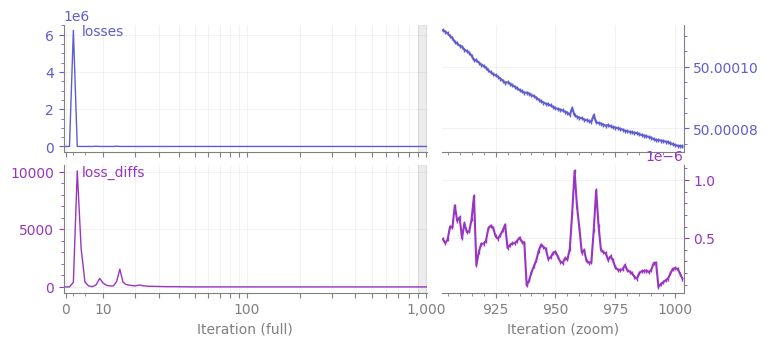

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [48]:
optmzr.plot()

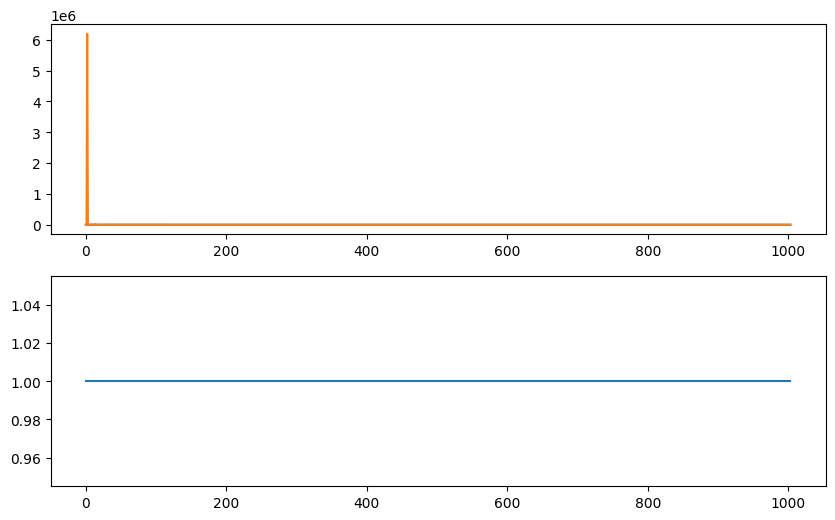

In [49]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

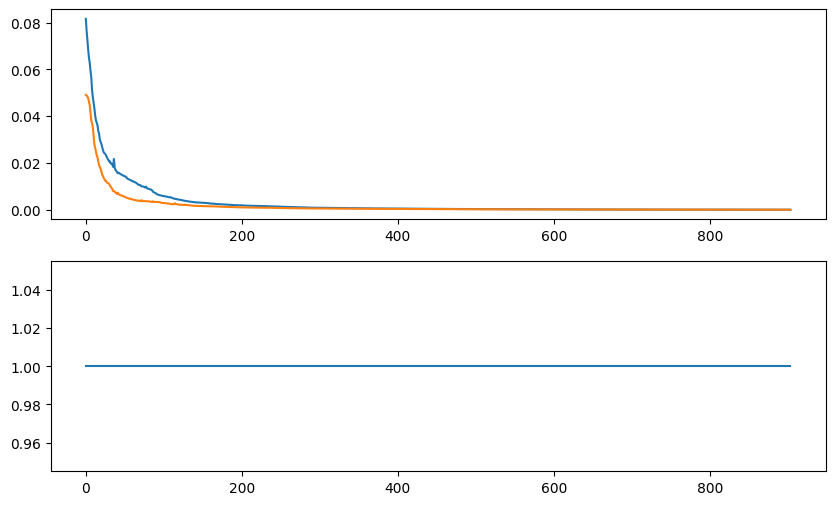

In [50]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

## ADAM
### Autodiff backend - tensorflow

In [51]:
loss_data=list()

In [52]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [56]:
optmzr._optimizer

'adam'

In [59]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

+1069.797916163740 [best: +1069.797916163740] :   0%|                                                                                                                      | 1/1000 [00:00<02:13,  7.51it/s]

+1069.556860897877 [best: +1069.556860897877] :   0%|▏                                                                                                                     | 2/1000 [00:00<02:12,  7.51it/s]

+1069.301730507776 [best: +1069.301730507776] :   0%|▎                                                                                                                     | 3/1000 [00:00<01:38, 10.16it/s]

+1069.031520537746 [best: +1069.031520537746] :   0%|▍                                                                                                                     | 4/1000 [00:00<01:38, 10.16it/s]

+1068.745141037872 [best: +1068.745141037872] :   0%|▌                                                                                                                     | 5/1000 [00:00<01:29, 11.10it/s]

+1068.441407128263 [best: +1068.441407128263] :   1%|▋                                                                                                                     | 6/1000 [00:00<01:29, 11.10it/s]

+1068.119027912706 [best: +1068.119027912706] :   1%|▊                                                                                                                     | 7/1000 [00:00<01:26, 11.53it/s]

+1067.776596778126 [best: +1067.776596778126] :   1%|▉                                                                                                                     | 8/1000 [00:00<01:26, 11.53it/s]

+1067.412582970412 [best: +1067.412582970412] :   1%|█                                                                                                                     | 9/1000 [00:00<01:24, 11.72it/s]

+1067.025322683400 [best: +1067.025322683400] :   1%|█▏                                                                                                                   | 10/1000 [00:00<01:24, 11.72it/s]

+1066.613008336063 [best: +1066.613008336063] :   1%|█▎                                                                                                                   | 11/1000 [00:00<01:23, 11.87it/s]

+1066.173677100813 [best: +1066.173677100813] :   1%|█▍                                                                                                                   | 12/1000 [00:01<01:23, 11.87it/s]

+1065.705198468437 [best: +1065.705198468437] :   1%|█▌                                                                                                                   | 13/1000 [00:01<01:22, 12.03it/s]

+1065.205259953712 [best: +1065.205259953712] :   1%|█▋                                                                                                                   | 14/1000 [00:01<01:21, 12.03it/s]

+1064.671350520608 [best: +1064.671350520608] :   2%|█▊                                                                                                                   | 15/1000 [00:01<01:22, 12.01it/s]

+1064.100743134420 [best: +1064.100743134420] :   2%|█▊                                                                                                                   | 16/1000 [00:01<01:21, 12.01it/s]

+1063.490477687443 [best: +1063.490477687443] :   2%|█▉                                                                                                                   | 17/1000 [00:01<01:22, 11.94it/s]

+1062.837344214713 [best: +1062.837344214713] :   2%|██                                                                                                                   | 18/1000 [00:01<01:22, 11.94it/s]

+1062.137865193743 [best: +1062.137865193743] :   2%|██▏                                                                                                                  | 19/1000 [00:01<01:21, 12.03it/s]

+1061.388275892348 [best: +1061.388275892348] :   2%|██▎                                                                                                                  | 20/1000 [00:01<01:21, 12.03it/s]

+1060.584502781319 [best: +1060.584502781319] :   2%|██▍                                                                                                                  | 21/1000 [00:01<01:20, 12.15it/s]

+1059.722140510411 [best: +1059.722140510411] :   2%|██▌                                                                                                                  | 22/1000 [00:01<01:20, 12.15it/s]

+1058.796427901484 [best: +1058.796427901484] :   2%|██▋                                                                                                                  | 23/1000 [00:01<01:19, 12.22it/s]

+1057.802223695392 [best: +1057.802223695392] :   2%|██▊                                                                                                                  | 24/1000 [00:02<01:19, 12.22it/s]

+1056.733983083152 [best: +1056.733983083152] :   2%|██▉                                                                                                                  | 25/1000 [00:02<01:19, 12.26it/s]

+1055.585735290041 [best: +1055.585735290041] :   3%|███                                                                                                                  | 26/1000 [00:02<01:19, 12.26it/s]

+1054.351062065541 [best: +1054.351062065541] :   3%|███▏                                                                                                                 | 27/1000 [00:02<01:18, 12.42it/s]

+1053.023077417279 [best: +1053.023077417279] :   3%|███▎                                                                                                                 | 28/1000 [00:02<01:18, 12.42it/s]

+1051.594409198040 [best: +1051.594409198040] :   3%|███▍                                                                                                                 | 29/1000 [00:02<01:17, 12.56it/s]

+1050.057185079584 [best: +1050.057185079584] :   3%|███▌                                                                                                                 | 30/1000 [00:02<01:17, 12.56it/s]

+1048.403028216466 [best: +1048.403028216466] :   3%|███▋                                                                                                                 | 31/1000 [00:02<01:16, 12.66it/s]

+1046.623068207415 [best: +1046.623068207415] :   3%|███▋                                                                                                                 | 32/1000 [00:02<01:16, 12.66it/s]

+1044.707974599747 [best: +1044.707974599747] :   3%|███▊                                                                                                                 | 33/1000 [00:02<01:16, 12.64it/s]

+1042.648018914846 [best: +1042.648018914846] :   3%|███▉                                                                                                                 | 34/1000 [00:02<01:16, 12.64it/s]

+1040.433159845781 [best: +1040.433159845781] :   4%|████                                                                                                                 | 35/1000 [00:02<01:16, 12.67it/s]

+1038.053148466535 [best: +1038.053148466535] :   4%|████▏                                                                                                                | 36/1000 [00:02<01:16, 12.67it/s]

+1035.497663162033 [best: +1035.497663162033] :   4%|████▎                                                                                                                | 37/1000 [00:03<01:15, 12.76it/s]

+1032.756488679175 [best: +1032.756488679175] :   4%|████▍                                                                                                                | 38/1000 [00:03<01:15, 12.76it/s]

+1029.819754606302 [best: +1029.819754606302] :   4%|████▌                                                                                                                | 39/1000 [00:03<01:15, 12.81it/s]

+1026.678250572307 [best: +1026.678250572307] :   4%|████▋                                                                                                                | 40/1000 [00:03<01:14, 12.81it/s]

+1023.323835607752 [best: +1023.323835607752] :   4%|████▊                                                                                                                | 41/1000 [00:03<01:14, 12.86it/s]

+1019.749955563180 [best: +1019.749955563180] :   4%|████▉                                                                                                                | 42/1000 [00:03<01:14, 12.86it/s]

+1015.952281651367 [best: +1015.952281651367] :   4%|█████                                                                                                                | 43/1000 [00:03<01:14, 12.84it/s]

+1011.929480498079 [best: +1011.929480498079] :   4%|█████▏                                                                                                               | 44/1000 [00:03<01:14, 12.84it/s]

+1007.684129895313 [best: +1007.684129895313] :   4%|█████▎                                                                                                               | 45/1000 [00:03<01:14, 12.76it/s]

+1003.223825334660 [best: +1003.223825334660] :   5%|█████▍                                                                                                               | 46/1000 [00:03<01:14, 12.76it/s]

+998.562433368982 [best: +998.562433368982] :   5%|█████▌                                                                                                                 | 47/1000 [00:03<01:14, 12.78it/s]

+993.721261986393 [best: +993.721261986393] :   5%|█████▋                                                                                                                 | 48/1000 [00:03<01:14, 12.78it/s]

+988.729824339430 [best: +988.729824339430] :   5%|█████▊                                                                                                                 | 49/1000 [00:03<01:14, 12.82it/s]

+983.625696118007 [best: +983.625696118007] :   5%|█████▉                                                                                                                 | 50/1000 [00:04<01:14, 12.82it/s]

+978.452973103855 [best: +978.452973103855] :   5%|██████                                                                                                                 | 51/1000 [00:04<01:13, 12.84it/s]

+973.259316457923 [best: +973.259316457923] :   5%|██████▏                                                                                                                | 52/1000 [00:04<01:13, 12.84it/s]

+968.091382444888 [best: +968.091382444888] :   5%|██████▎                                                                                                                | 53/1000 [00:04<01:13, 12.85it/s]

+962.987669872141 [best: +962.987669872141] :   5%|██████▍                                                                                                                | 54/1000 [00:04<01:13, 12.85it/s]

+957.969244444536 [best: +957.969244444536] :   6%|██████▌                                                                                                                | 55/1000 [00:04<01:13, 12.88it/s]

+953.031404858079 [best: +953.031404858079] :   6%|██████▋                                                                                                                | 56/1000 [00:04<01:13, 12.88it/s]

+948.140876868234 [best: +948.140876868234] :   6%|██████▊                                                                                                                | 57/1000 [00:04<01:13, 12.89it/s]

+943.241810191071 [best: +943.241810191071] :   6%|██████▉                                                                                                                | 58/1000 [00:04<01:13, 12.89it/s]

+938.269356185718 [best: +938.269356185718] :   6%|███████                                                                                                                | 59/1000 [00:04<01:12, 12.90it/s]

+933.165786779047 [best: +933.165786779047] :   6%|███████▏                                                                                                               | 60/1000 [00:04<01:12, 12.90it/s]

+927.893452954076 [best: +927.893452954076] :   6%|███████▎                                                                                                               | 61/1000 [00:04<01:12, 12.91it/s]

+922.441041582080 [best: +922.441041582080] :   6%|███████▍                                                                                                               | 62/1000 [00:04<01:12, 12.91it/s]

+916.822627219992 [best: +916.822627219992] :   6%|███████▍                                                                                                               | 63/1000 [00:05<01:12, 12.91it/s]

+911.071334973119 [best: +911.071334973119] :   6%|███████▌                                                                                                               | 64/1000 [00:05<01:12, 12.91it/s]

+905.230395275231 [best: +905.230395275231] :   6%|███████▋                                                                                                               | 65/1000 [00:05<01:12, 12.90it/s]

+899.344149371307 [best: +899.344149371307] :   7%|███████▊                                                                                                               | 66/1000 [00:05<01:12, 12.90it/s]

+893.450767389547 [best: +893.450767389547] :   7%|███████▉                                                                                                               | 67/1000 [00:05<01:12, 12.90it/s]

+887.577583002616 [best: +887.577583002616] :   7%|████████                                                                                                               | 68/1000 [00:05<01:12, 12.90it/s]

+881.739254051575 [best: +881.739254051575] :   7%|████████▏                                                                                                              | 69/1000 [00:05<01:12, 12.90it/s]

+875.938412218126 [best: +875.938412218126] :   7%|████████▎                                                                                                              | 70/1000 [00:05<01:12, 12.90it/s]

+870.168063464643 [best: +870.168063464643] :   7%|████████▍                                                                                                              | 71/1000 [00:05<01:11, 12.92it/s]

+864.414861004307 [best: +864.414861004307] :   7%|████████▌                                                                                                              | 72/1000 [00:05<01:11, 12.92it/s]

+858.662502333335 [best: +858.662502333335] :   7%|████████▋                                                                                                              | 73/1000 [00:05<01:11, 12.92it/s]

+852.894745611065 [best: +852.894745611065] :   7%|████████▊                                                                                                              | 74/1000 [00:05<01:11, 12.92it/s]

+847.097748362696 [best: +847.097748362696] :   8%|████████▉                                                                                                              | 75/1000 [00:05<01:11, 12.93it/s]

+841.261572299413 [best: +841.261572299413] :   8%|█████████                                                                                                              | 76/1000 [00:06<01:11, 12.93it/s]

+835.380813339891 [best: +835.380813339891] :   8%|█████████▏                                                                                                             | 77/1000 [00:06<01:11, 12.93it/s]

+829.454432207830 [best: +829.454432207830] :   8%|█████████▎                                                                                                             | 78/1000 [00:06<01:11, 12.93it/s]

+823.484965289945 [best: +823.484965289945] :   8%|█████████▍                                                                                                             | 79/1000 [00:06<01:11, 12.92it/s]

+817.477363004413 [best: +817.477363004413] :   8%|█████████▌                                                                                                             | 80/1000 [00:06<01:11, 12.92it/s]

+811.437721554429 [best: +811.437721554429] :   8%|█████████▋                                                                                                             | 81/1000 [00:06<01:11, 12.90it/s]

+805.372145899634 [best: +805.372145899634] :   8%|█████████▊                                                                                                             | 82/1000 [00:06<01:11, 12.90it/s]

+799.285918081154 [best: +799.285918081154] :   8%|█████████▉                                                                                                             | 83/1000 [00:06<01:11, 12.91it/s]

+793.183060997266 [best: +793.183060997266] :   8%|█████████▉                                                                                                             | 84/1000 [00:06<01:10, 12.91it/s]

+787.066299280824 [best: +787.066299280824] :   8%|██████████                                                                                                             | 85/1000 [00:06<01:10, 12.90it/s]

+780.937340931274 [best: +780.937340931274] :   9%|██████████▏                                                                                                            | 86/1000 [00:06<01:10, 12.90it/s]

+774.797349629125 [best: +774.797349629125] :   9%|██████████▎                                                                                                            | 87/1000 [00:06<01:10, 12.91it/s]

+768.647458668253 [best: +768.647458668253] :   9%|██████████▍                                                                                                            | 88/1000 [00:07<01:10, 12.91it/s]

+762.489195537652 [best: +762.489195537652] :   9%|██████████▌                                                                                                            | 89/1000 [00:07<01:11, 12.73it/s]

+756.324733162820 [best: +756.324733162820] :   9%|██████████▋                                                                                                            | 90/1000 [00:07<01:11, 12.73it/s]

+750.156943233018 [best: +750.156943233018] :   9%|██████████▊                                                                                                            | 91/1000 [00:07<01:11, 12.64it/s]

+743.989280287891 [best: +743.989280287891] :   9%|██████████▉                                                                                                            | 92/1000 [00:07<01:11, 12.64it/s]

+737.825558497058 [best: +737.825558497058] :   9%|███████████                                                                                                            | 93/1000 [00:07<01:11, 12.69it/s]

+731.669691583793 [best: +731.669691583793] :   9%|███████████▏                                                                                                           | 94/1000 [00:07<01:11, 12.69it/s]

+725.525454158776 [best: +725.525454158776] :  10%|███████████▎                                                                                                           | 95/1000 [00:07<01:10, 12.76it/s]

+719.396299065300 [best: +719.396299065300] :  10%|███████████▍                                                                                                           | 96/1000 [00:07<01:10, 12.76it/s]

+713.285240220908 [best: +713.285240220908] :  10%|███████████▌                                                                                                           | 97/1000 [00:07<01:10, 12.83it/s]

+707.194791408962 [best: +707.194791408962] :  10%|███████████▋                                                                                                           | 98/1000 [00:07<01:10, 12.83it/s]

+701.126942048741 [best: +701.126942048741] :  10%|███████████▊                                                                                                           | 99/1000 [00:07<01:09, 12.87it/s]

+695.083150833414 [best: +695.083150833414] :  10%|███████████▊                                                                                                          | 100/1000 [00:07<01:09, 12.87it/s]

+689.064344395056 [best: +689.064344395056] :  10%|███████████▉                                                                                                          | 101/1000 [00:08<01:09, 12.90it/s]

+683.070916957866 [best: +683.070916957866] :  10%|████████████                                                                                                          | 102/1000 [00:08<01:09, 12.90it/s]

+677.102734608671 [best: +677.102734608671] :  10%|████████████▏                                                                                                         | 103/1000 [00:08<01:09, 12.91it/s]

+671.159151745040 [best: +671.159151745040] :  10%|████████████▎                                                                                                         | 104/1000 [00:08<01:09, 12.91it/s]

+665.239046622481 [best: +665.239046622481] :  10%|████████████▍                                                                                                         | 105/1000 [00:08<01:09, 12.87it/s]

+659.340878853353 [best: +659.340878853353] :  11%|████████████▌                                                                                                         | 106/1000 [00:08<01:09, 12.87it/s]

+653.462766431919 [best: +653.462766431919] :  11%|████████████▋                                                                                                         | 107/1000 [00:08<01:09, 12.87it/s]

+647.602575214536 [best: +647.602575214536] :  11%|████████████▋                                                                                                         | 108/1000 [00:08<01:09, 12.87it/s]

+641.758010601041 [best: +641.758010601041] :  11%|████████████▊                                                                                                         | 109/1000 [00:08<01:09, 12.88it/s]

+635.926699745168 [best: +635.926699745168] :  11%|████████████▉                                                                                                         | 110/1000 [00:08<01:09, 12.88it/s]

+630.106253298025 [best: +630.106253298025] :  11%|█████████████                                                                                                         | 111/1000 [00:08<01:08, 12.89it/s]

+624.294298770703 [best: +624.294298770703] :  11%|█████████████▏                                                                                                        | 112/1000 [00:08<01:08, 12.89it/s]

+618.488483028284 [best: +618.488483028284] :  11%|█████████████▎                                                                                                        | 113/1000 [00:08<01:08, 12.89it/s]

+612.686448471533 [best: +612.686448471533] :  11%|█████████████▍                                                                                                        | 114/1000 [00:09<01:08, 12.89it/s]

+606.885794585248 [best: +606.885794585248] :  12%|█████████████▌                                                                                                        | 115/1000 [00:09<01:08, 12.92it/s]

+601.084041574092 [best: +601.084041574092] :  12%|█████████████▋                                                                                                        | 116/1000 [00:09<01:08, 12.92it/s]

+595.278613726495 [best: +595.278613726495] :  12%|█████████████▊                                                                                                        | 117/1000 [00:09<01:08, 12.90it/s]

+589.466856017545 [best: +589.466856017545] :  12%|█████████████▉                                                                                                        | 118/1000 [00:09<01:08, 12.90it/s]

+583.646089056144 [best: +583.646089056144] :  12%|██████████████                                                                                                        | 119/1000 [00:09<01:08, 12.91it/s]

+577.813697081741 [best: +577.813697081741] :  12%|██████████████▏                                                                                                       | 120/1000 [00:09<01:08, 12.91it/s]

+571.967234304306 [best: +571.967234304306] :  12%|██████████████▎                                                                                                       | 121/1000 [00:09<01:07, 12.93it/s]

+566.104529140575 [best: +566.104529140575] :  12%|██████████████▍                                                                                                       | 122/1000 [00:09<01:07, 12.93it/s]

+560.223765400755 [best: +560.223765400755] :  12%|██████████████▌                                                                                                       | 123/1000 [00:09<01:07, 12.93it/s]

+554.323524289710 [best: +554.323524289710] :  12%|██████████████▋                                                                                                       | 124/1000 [00:09<01:07, 12.93it/s]

+548.402779847961 [best: +548.402779847961] :  12%|██████████████▊                                                                                                       | 125/1000 [00:09<01:07, 12.91it/s]

+542.460850841995 [best: +542.460850841995] :  13%|██████████████▊                                                                                                       | 126/1000 [00:09<01:07, 12.91it/s]

+536.497321471915 [best: +536.497321471915] :  13%|██████████████▉                                                                                                       | 127/1000 [00:10<01:08, 12.78it/s]

+530.511949311224 [best: +530.511949311224] :  13%|███████████████                                                                                                       | 128/1000 [00:10<01:08, 12.78it/s]

+524.504580275912 [best: +524.504580275912] :  13%|███████████████▏                                                                                                      | 129/1000 [00:10<02:07,  6.83it/s]

+518.475087061062 [best: +518.475087061062] :  13%|███████████████▎                                                                                                      | 130/1000 [00:10<02:07,  6.83it/s]

+512.423340578628 [best: +512.423340578628] :  13%|███████████████▍                                                                                                      | 131/1000 [00:10<01:49,  7.95it/s]

+506.349215559688 [best: +506.349215559688] :  13%|███████████████▌                                                                                                      | 132/1000 [00:10<01:49,  7.95it/s]

+500.252623939603 [best: +500.252623939603] :  13%|███████████████▋                                                                                                      | 133/1000 [00:10<01:37,  8.90it/s]

+494.133564735051 [best: +494.133564735051] :  13%|███████████████▊                                                                                                      | 134/1000 [00:11<01:37,  8.90it/s]

+487.992177725456 [best: +487.992177725456] :  14%|███████████████▉                                                                                                      | 135/1000 [00:11<01:28,  9.81it/s]

+481.828790206234 [best: +481.828790206234] :  14%|████████████████                                                                                                      | 136/1000 [00:11<01:28,  9.81it/s]

+475.643950355901 [best: +475.643950355901] :  14%|████████████████▏                                                                                                     | 137/1000 [00:11<01:21, 10.57it/s]

+469.438445802431 [best: +469.438445802431] :  14%|████████████████▎                                                                                                     | 138/1000 [00:11<01:21, 10.57it/s]

+463.213310183671 [best: +463.213310183671] :  14%|████████████████▍                                                                                                     | 139/1000 [00:11<01:17, 11.14it/s]

+456.969822712488 [best: +456.969822712488] :  14%|████████████████▌                                                                                                     | 140/1000 [00:11<01:17, 11.14it/s]

+450.709505621381 [best: +450.709505621381] :  14%|████████████████▋                                                                                                     | 141/1000 [00:11<01:14, 11.49it/s]

+444.434122378801 [best: +444.434122378801] :  14%|████████████████▊                                                                                                     | 142/1000 [00:11<01:14, 11.49it/s]

+438.145676839749 [best: +438.145676839749] :  14%|████████████████▊                                                                                                     | 143/1000 [00:11<01:12, 11.87it/s]

+431.846411220005 [best: +431.846411220005] :  14%|████████████████▉                                                                                                     | 144/1000 [00:11<01:12, 11.87it/s]

+425.538799787601 [best: +425.538799787601] :  14%|█████████████████                                                                                                     | 145/1000 [00:11<01:10, 12.14it/s]

+419.225535606451 [best: +419.225535606451] :  15%|█████████████████▏                                                                                                    | 146/1000 [00:11<01:10, 12.14it/s]

+412.909509081468 [best: +412.909509081468] :  15%|█████████████████▎                                                                                                    | 147/1000 [00:12<01:09, 12.36it/s]

+406.593778660488 [best: +406.593778660488] :  15%|█████████████████▍                                                                                                    | 148/1000 [00:12<01:08, 12.36it/s]

+400.281535155242 [best: +400.281535155242] :  15%|█████████████████▌                                                                                                    | 149/1000 [00:12<01:08, 12.48it/s]

+393.976061466218 [best: +393.976061466218] :  15%|█████████████████▋                                                                                                    | 150/1000 [00:12<01:08, 12.48it/s]

+387.680689235263 [best: +387.680689235263] :  15%|█████████████████▊                                                                                                    | 151/1000 [00:12<01:08, 12.49it/s]

+381.398753618711 [best: +381.398753618711] :  15%|█████████████████▉                                                                                                    | 152/1000 [00:12<01:07, 12.49it/s]

+375.133547472397 [best: +375.133547472397] :  15%|██████████████████                                                                                                    | 153/1000 [00:12<01:07, 12.59it/s]

+368.888276950114 [best: +368.888276950114] :  15%|██████████████████▏                                                                                                   | 154/1000 [00:12<01:07, 12.59it/s]

+362.666021581712 [best: +362.666021581712] :  16%|██████████████████▎                                                                                                   | 155/1000 [00:12<01:06, 12.68it/s]

+356.469702744692 [best: +356.469702744692] :  16%|██████████████████▍                                                                                                   | 156/1000 [00:12<01:06, 12.68it/s]

+350.302064485832 [best: +350.302064485832] :  16%|██████████████████▌                                                                                                   | 157/1000 [00:12<01:06, 12.76it/s]

+344.165669593538 [best: +344.165669593538] :  16%|██████████████████▋                                                                                                   | 158/1000 [00:12<01:05, 12.76it/s]

+338.062911823265 [best: +338.062911823265] :  16%|██████████████████▊                                                                                                   | 159/1000 [00:13<01:06, 12.71it/s]

+331.996042775998 [best: +331.996042775998] :  16%|██████████████████▉                                                                                                   | 160/1000 [00:13<01:06, 12.71it/s]

+325.967209802502 [best: +325.967209802502] :  16%|██████████████████▉                                                                                                   | 161/1000 [00:13<01:05, 12.74it/s]

+319.978499990942 [best: +319.978499990942] :  16%|███████████████████                                                                                                   | 162/1000 [00:13<01:05, 12.74it/s]

+314.031985002126 [best: +314.031985002126] :  16%|███████████████████▏                                                                                                  | 163/1000 [00:13<01:06, 12.68it/s]

+308.129762103459 [best: +308.129762103459] :  16%|███████████████████▎                                                                                                  | 164/1000 [00:13<01:05, 12.68it/s]

+302.273987856014 [best: +302.273987856014] :  16%|███████████████████▍                                                                                                  | 165/1000 [00:13<01:05, 12.69it/s]

+296.466902138178 [best: +296.466902138178] :  17%|███████████████████▌                                                                                                  | 166/1000 [00:13<01:05, 12.69it/s]

+290.710841294413 [best: +290.710841294413] :  17%|███████████████████▋                                                                                                  | 167/1000 [00:13<01:05, 12.75it/s]

+285.008240129016 [best: +285.008240129016] :  17%|███████████████████▊                                                                                                  | 168/1000 [00:13<01:05, 12.75it/s]

+279.361623308769 [best: +279.361623308769] :  17%|███████████████████▉                                                                                                  | 169/1000 [00:13<01:05, 12.78it/s]

+273.773587581819 [best: +273.773587581819] :  17%|████████████████████                                                                                                  | 170/1000 [00:13<01:04, 12.78it/s]

+268.246777032373 [best: +268.246777032373] :  17%|████████████████████▏                                                                                                 | 171/1000 [00:13<01:04, 12.80it/s]

+262.783854203245 [best: +262.783854203245] :  17%|████████████████████▎                                                                                                 | 172/1000 [00:14<01:04, 12.80it/s]

+257.387470111746 [best: +257.387470111746] :  17%|████████████████████▍                                                                                                 | 173/1000 [00:14<01:04, 12.77it/s]

+252.060235828052 [best: +252.060235828052] :  17%|████████████████████▌                                                                                                 | 174/1000 [00:14<01:04, 12.77it/s]

+246.804697439434 [best: +246.804697439434] :  18%|████████████████████▋                                                                                                 | 175/1000 [00:14<01:04, 12.80it/s]

+241.623315138326 [best: +241.623315138326] :  18%|████████████████████▊                                                                                                 | 176/1000 [00:14<01:04, 12.80it/s]

+236.518446181299 [best: +236.518446181299] :  18%|████████████████████▉                                                                                                 | 177/1000 [00:14<01:04, 12.84it/s]

+231.492330840440 [best: +231.492330840440] :  18%|█████████████████████                                                                                                 | 178/1000 [00:14<01:04, 12.84it/s]

+226.547080311927 [best: +226.547080311927] :  18%|█████████████████████                                                                                                 | 179/1000 [00:14<01:03, 12.85it/s]

+221.684665788388 [best: +221.684665788388] :  18%|█████████████████████▏                                                                                                | 180/1000 [00:14<01:03, 12.85it/s]

+216.906908371853 [best: +216.906908371853] :  18%|█████████████████████▎                                                                                                | 181/1000 [00:14<01:03, 12.86it/s]

+212.215470028834 [best: +212.215470028834] :  18%|█████████████████████▍                                                                                                | 182/1000 [00:14<01:03, 12.86it/s]

+207.611846243124 [best: +207.611846243124] :  18%|█████████████████████▌                                                                                                | 183/1000 [00:14<01:03, 12.89it/s]

+203.097361326137 [best: +203.097361326137] :  18%|█████████████████████▋                                                                                                | 184/1000 [00:14<01:03, 12.89it/s]

+198.673167437648 [best: +198.673167437648] :  18%|█████████████████████▊                                                                                                | 185/1000 [00:15<01:03, 12.90it/s]

+194.340248197941 [best: +194.340248197941] :  19%|█████████████████████▉                                                                                                | 186/1000 [00:15<01:03, 12.90it/s]

+190.099427314820 [best: +190.099427314820] :  19%|██████████████████████                                                                                                | 187/1000 [00:15<01:02, 12.91it/s]

+185.951381957325 [best: +185.951381957325] :  19%|██████████████████████▏                                                                                               | 188/1000 [00:15<01:02, 12.91it/s]

+181.896659822230 [best: +181.896659822230] :  19%|██████████████████████▎                                                                                               | 189/1000 [00:15<01:02, 12.89it/s]

+177.935698155605 [best: +177.935698155605] :  19%|██████████████████████▍                                                                                               | 190/1000 [00:15<01:02, 12.89it/s]

+174.068842590726 [best: +174.068842590726] :  19%|██████████████████████▌                                                                                               | 191/1000 [00:15<01:02, 12.89it/s]

+170.296363639911 [best: +170.296363639911] :  19%|██████████████████████▋                                                                                               | 192/1000 [00:15<01:02, 12.89it/s]

+166.618469007105 [best: +166.618469007105] :  19%|██████████████████████▊                                                                                               | 193/1000 [00:15<01:02, 12.85it/s]

+163.035310450902 [best: +163.035310450902] :  19%|██████████████████████▉                                                                                               | 194/1000 [00:15<01:02, 12.85it/s]

+159.546984571579 [best: +159.546984571579] :  20%|███████████████████████                                                                                               | 195/1000 [00:15<01:03, 12.75it/s]

+156.153527497989 [best: +156.153527497989] :  20%|███████████████████████▏                                                                                              | 196/1000 [00:15<01:03, 12.75it/s]

+152.854903949484 [best: +152.854903949484] :  20%|███████████████████████▏                                                                                              | 197/1000 [00:15<01:02, 12.78it/s]

+149.650991537863 [best: +149.650991537863] :  20%|███████████████████████▎                                                                                              | 198/1000 [00:16<01:02, 12.78it/s]

+146.541561472055 [best: +146.541561472055] :  20%|███████████████████████▍                                                                                              | 199/1000 [00:16<01:02, 12.82it/s]

+143.526257047555 [best: +143.526257047555] :  20%|███████████████████████▌                                                                                              | 200/1000 [00:16<01:02, 12.82it/s]

+140.604571444088 [best: +140.604571444088] :  20%|███████████████████████▋                                                                                              | 201/1000 [00:16<01:02, 12.85it/s]

+137.775826412495 [best: +137.775826412495] :  20%|███████████████████████▊                                                                                              | 202/1000 [00:16<01:02, 12.85it/s]

+135.039153403384 [best: +135.039153403384] :  20%|███████████████████████▉                                                                                              | 203/1000 [00:16<01:01, 12.86it/s]

+132.393478580352 [best: +132.393478580352] :  20%|████████████████████████                                                                                              | 204/1000 [00:16<01:01, 12.86it/s]

+129.837512975129 [best: +129.837512975129] :  20%|████████████████████████▏                                                                                             | 205/1000 [00:16<01:01, 12.90it/s]

+127.369748781810 [best: +127.369748781810] :  21%|████████████████████████▎                                                                                             | 206/1000 [00:16<01:01, 12.90it/s]

+124.988462450481 [best: +124.988462450481] :  21%|████████████████████████▍                                                                                             | 207/1000 [00:16<01:01, 12.90it/s]

+122.691724831849 [best: +122.691724831849] :  21%|████████████████████████▌                                                                                             | 208/1000 [00:16<01:01, 12.90it/s]

+120.477418165789 [best: +120.477418165789] :  21%|████████████████████████▋                                                                                             | 209/1000 [00:16<01:01, 12.88it/s]

+118.343259238230 [best: +118.343259238230] :  21%|████████████████████████▊                                                                                             | 210/1000 [00:16<01:01, 12.88it/s]

+116.286827602815 [best: +116.286827602815] :  21%|████████████████████████▉                                                                                             | 211/1000 [00:17<01:01, 12.90it/s]

+114.305597423595 [best: +114.305597423595] :  21%|█████████████████████████                                                                                             | 212/1000 [00:17<01:01, 12.90it/s]

+112.396971276277 [best: +112.396971276277] :  21%|█████████████████████████▏                                                                                            | 213/1000 [00:17<01:00, 12.90it/s]

+110.558314166798 [best: +110.558314166798] :  21%|█████████████████████████▎                                                                                            | 214/1000 [00:17<01:00, 12.90it/s]

+108.786986091175 [best: +108.786986091175] :  22%|█████████████████████████▎                                                                                            | 215/1000 [00:17<01:00, 12.91it/s]

+107.080371662693 [best: +107.080371662693] :  22%|█████████████████████████▍                                                                                            | 216/1000 [00:17<01:00, 12.91it/s]

+105.435905650578 [best: +105.435905650578] :  22%|█████████████████████████▌                                                                                            | 217/1000 [00:17<01:00, 12.92it/s]

+103.851093672487 [best: +103.851093672487] :  22%|█████████████████████████▋                                                                                            | 218/1000 [00:17<01:00, 12.92it/s]

+102.323527711704 [best: +102.323527711704] :  22%|█████████████████████████▊                                                                                            | 219/1000 [00:17<01:00, 12.94it/s]

+100.850896534853 [best: +100.850896534853] :  22%|█████████████████████████▉                                                                                            | 220/1000 [00:17<01:00, 12.94it/s]

+99.430991421065 [best: +99.430991421065] :  22%|██████████████████████████▌                                                                                             | 221/1000 [00:17<01:00, 12.95it/s]

+98.061707851850 [best: +98.061707851850] :  22%|██████████████████████████▋                                                                                             | 222/1000 [00:17<01:00, 12.95it/s]

+96.741043946488 [best: +96.741043946488] :  22%|██████████████████████████▊                                                                                             | 223/1000 [00:17<00:59, 12.95it/s]

+95.467096471559 [best: +95.467096471559] :  22%|██████████████████████████▉                                                                                             | 224/1000 [00:18<00:59, 12.95it/s]

+94.238055223451 [best: +94.238055223451] :  22%|███████████████████████████                                                                                             | 225/1000 [00:18<01:01, 12.65it/s]

+93.052196498791 [best: +93.052196498791] :  23%|███████████████████████████                                                                                             | 226/1000 [00:18<01:01, 12.65it/s]

+91.907876247347 [best: +91.907876247347] :  23%|███████████████████████████▏                                                                                            | 227/1000 [00:18<01:01, 12.49it/s]

+90.803523361955 [best: +90.803523361955] :  23%|███████████████████████████▎                                                                                            | 228/1000 [00:18<01:01, 12.49it/s]

+89.737633416534 [best: +89.737633416534] :  23%|███████████████████████████▍                                                                                            | 229/1000 [00:18<01:01, 12.45it/s]

+88.708763031098 [best: +88.708763031098] :  23%|███████████████████████████▌                                                                                            | 230/1000 [00:18<01:01, 12.45it/s]

+87.715524932635 [best: +87.715524932635] :  23%|███████████████████████████▋                                                                                            | 231/1000 [00:18<01:01, 12.57it/s]

+86.756583698946 [best: +86.756583698946] :  23%|███████████████████████████▊                                                                                            | 232/1000 [00:18<01:01, 12.57it/s]

+85.830652120740 [best: +85.830652120740] :  23%|███████████████████████████▉                                                                                            | 233/1000 [00:18<01:00, 12.64it/s]

+84.936488094093 [best: +84.936488094093] :  23%|████████████████████████████                                                                                            | 234/1000 [00:18<01:00, 12.64it/s]

+84.072891957091 [best: +84.072891957091] :  24%|████████████████████████████▏                                                                                           | 235/1000 [00:18<01:00, 12.71it/s]

+83.238704204550 [best: +83.238704204550] :  24%|████████████████████████████▎                                                                                           | 236/1000 [00:19<01:00, 12.71it/s]

+82.432803543759 [best: +82.432803543759] :  24%|████████████████████████████▍                                                                                           | 237/1000 [00:19<00:59, 12.76it/s]

+81.654105281013 [best: +81.654105281013] :  24%|████████████████████████████▌                                                                                           | 238/1000 [00:19<00:59, 12.76it/s]

+80.901560043719 [best: +80.901560043719] :  24%|████████████████████████████▋                                                                                           | 239/1000 [00:19<00:59, 12.80it/s]

+80.174152841083 [best: +80.174152841083] :  24%|████████████████████████████▊                                                                                           | 240/1000 [00:19<00:59, 12.80it/s]

+79.470902449110 [best: +79.470902449110] :  24%|████████████████████████████▉                                                                                           | 241/1000 [00:19<01:00, 12.58it/s]

+78.790861079406 [best: +78.790861079406] :  24%|█████████████████████████████                                                                                           | 242/1000 [00:19<01:00, 12.58it/s]

+78.133114264498 [best: +78.133114264498] :  24%|█████████████████████████████▏                                                                                          | 243/1000 [00:19<01:00, 12.58it/s]

+77.496780872722 [best: +77.496780872722] :  24%|█████████████████████████████▎                                                                                          | 244/1000 [00:19<01:00, 12.58it/s]

+76.881013157323 [best: +76.881013157323] :  24%|█████████████████████████████▍                                                                                          | 245/1000 [00:19<01:02, 12.00it/s]

+76.284996748745 [best: +76.284996748745] :  25%|█████████████████████████████▌                                                                                          | 246/1000 [00:19<01:02, 12.00it/s]

+75.707950514316 [best: +75.707950514316] :  25%|█████████████████████████████▋                                                                                          | 247/1000 [00:19<01:08, 11.03it/s]

+75.149126232559 [best: +75.149126232559] :  25%|█████████████████████████████▊                                                                                          | 248/1000 [00:20<01:08, 11.03it/s]

+74.607808055685 [best: +74.607808055685] :  25%|█████████████████████████████▉                                                                                          | 249/1000 [00:20<01:05, 11.49it/s]

+74.083311759216 [best: +74.083311759216] :  25%|██████████████████████████████                                                                                          | 250/1000 [00:20<01:05, 11.49it/s]

+73.574983798263 [best: +73.574983798263] :  25%|██████████████████████████████                                                                                          | 251/1000 [00:20<01:04, 11.70it/s]

+73.082200204020 [best: +73.082200204020] :  25%|██████████████████████████████▏                                                                                         | 252/1000 [00:20<01:03, 11.70it/s]

+72.604365361041 [best: +72.604365361041] :  25%|██████████████████████████████▎                                                                                         | 253/1000 [00:20<01:02, 11.99it/s]

+72.140910707069 [best: +72.140910707069] :  25%|██████████████████████████████▍                                                                                         | 254/1000 [00:20<01:02, 11.99it/s]

+71.691293394363 [best: +71.691293394363] :  26%|██████████████████████████████▌                                                                                         | 255/1000 [00:20<01:00, 12.23it/s]

+71.254994946013 [best: +71.254994946013] :  26%|██████████████████████████████▋                                                                                         | 256/1000 [00:20<01:00, 12.23it/s]

+70.831519934323 [best: +70.831519934323] :  26%|██████████████████████████████▊                                                                                         | 257/1000 [00:20<00:59, 12.42it/s]

+70.420394701762 [best: +70.420394701762] :  26%|██████████████████████████████▉                                                                                         | 258/1000 [00:20<00:59, 12.42it/s]

+70.021166139318 [best: +70.021166139318] :  26%|███████████████████████████████                                                                                         | 259/1000 [00:20<00:59, 12.56it/s]

+69.633400532577 [best: +69.633400532577] :  26%|███████████████████████████████▏                                                                                        | 260/1000 [00:20<00:58, 12.56it/s]

+69.256682482596 [best: +69.256682482596] :  26%|███████████████████████████████▎                                                                                        | 261/1000 [00:21<00:58, 12.63it/s]

+68.890613906125 [best: +68.890613906125] :  26%|███████████████████████████████▍                                                                                        | 262/1000 [00:21<00:58, 12.63it/s]

+68.534813117349 [best: +68.534813117349] :  26%|███████████████████████████████▌                                                                                        | 263/1000 [00:21<00:58, 12.69it/s]

+68.188913990767 [best: +68.188913990767] :  26%|███████████████████████████████▋                                                                                        | 264/1000 [00:21<00:57, 12.69it/s]

+67.852565202075 [best: +67.852565202075] :  26%|███████████████████████████████▊                                                                                        | 265/1000 [00:21<00:57, 12.76it/s]

+67.525429541372 [best: +67.525429541372] :  27%|███████████████████████████████▉                                                                                        | 266/1000 [00:21<00:57, 12.76it/s]

+67.207183290987 [best: +67.207183290987] :  27%|████████████████████████████████                                                                                        | 267/1000 [00:21<00:57, 12.81it/s]

+66.897515658993 [best: +66.897515658993] :  27%|████████████████████████████████▏                                                                                       | 268/1000 [00:21<00:57, 12.81it/s]

+66.596128258986 [best: +66.596128258986] :  27%|████████████████████████████████▎                                                                                       | 269/1000 [00:21<00:56, 12.84it/s]

+66.302734626958 [best: +66.302734626958] :  27%|████████████████████████████████▍                                                                                       | 270/1000 [00:21<00:56, 12.84it/s]

+66.017059766753 [best: +66.017059766753] :  27%|████████████████████████████████▌                                                                                       | 271/1000 [00:21<00:57, 12.79it/s]

+65.738839716663 [best: +65.738839716663] :  27%|████████████████████████████████▋                                                                                       | 272/1000 [00:21<00:56, 12.79it/s]

+65.467821131021 [best: +65.467821131021] :  27%|████████████████████████████████▊                                                                                       | 273/1000 [00:22<00:56, 12.82it/s]

+65.203760871898 [best: +65.203760871898] :  27%|████████████████████████████████▉                                                                                       | 274/1000 [00:22<00:56, 12.82it/s]

+64.946425607475 [best: +64.946425607475] :  28%|█████████████████████████████████                                                                                       | 275/1000 [00:22<00:56, 12.86it/s]

+64.695591414973 [best: +64.695591414973] :  28%|█████████████████████████████████                                                                                       | 276/1000 [00:22<00:56, 12.86it/s]

+64.451043387408 [best: +64.451043387408] :  28%|█████████████████████████████████▏                                                                                      | 277/1000 [00:22<00:56, 12.87it/s]

+64.212575244784 [best: +64.212575244784] :  28%|█████████████████████████████████▎                                                                                      | 278/1000 [00:22<00:56, 12.87it/s]

+63.979988951420 [best: +63.979988951420] :  28%|█████████████████████████████████▍                                                                                      | 279/1000 [00:22<00:56, 12.85it/s]

+63.753094341866 [best: +63.753094341866] :  28%|█████████████████████████████████▌                                                                                      | 280/1000 [00:22<00:56, 12.85it/s]

+63.531708758145 [best: +63.531708758145] :  28%|█████████████████████████████████▋                                                                                      | 281/1000 [00:22<00:55, 12.87it/s]

+63.315656700859 [best: +63.315656700859] :  28%|█████████████████████████████████▊                                                                                      | 282/1000 [00:22<00:55, 12.87it/s]

+63.104769496116 [best: +63.104769496116] :  28%|█████████████████████████████████▉                                                                                      | 283/1000 [00:22<00:55, 12.88it/s]

+62.898884979499 [best: +62.898884979499] :  28%|██████████████████████████████████                                                                                      | 284/1000 [00:22<00:55, 12.88it/s]

+62.697847197448 [best: +62.697847197448] :  28%|██████████████████████████████████▏                                                                                     | 285/1000 [00:22<00:55, 12.87it/s]

+62.501506125732 [best: +62.501506125732] :  29%|██████████████████████████████████▎                                                                                     | 286/1000 [00:23<00:55, 12.87it/s]

+62.309717404071 [best: +62.309717404071] :  29%|██████████████████████████████████▍                                                                                     | 287/1000 [00:23<00:55, 12.88it/s]

+62.122342085672 [best: +62.122342085672] :  29%|██████████████████████████████████▌                                                                                     | 288/1000 [00:23<00:55, 12.88it/s]

+61.939246400286 [best: +61.939246400286] :  29%|██████████████████████████████████▋                                                                                     | 289/1000 [00:23<00:55, 12.89it/s]

+61.760301529483 [best: +61.760301529483] :  29%|██████████████████████████████████▊                                                                                     | 290/1000 [00:23<00:55, 12.89it/s]

+61.585383393090 [best: +61.585383393090] :  29%|██████████████████████████████████▉                                                                                     | 291/1000 [00:23<00:55, 12.87it/s]

+61.414372445928 [best: +61.414372445928] :  29%|███████████████████████████████████                                                                                     | 292/1000 [00:23<00:55, 12.87it/s]

+61.247153484269 [best: +61.247153484269] :  29%|███████████████████████████████████▏                                                                                    | 293/1000 [00:23<00:54, 12.90it/s]

+61.083615461536 [best: +61.083615461536] :  29%|███████████████████████████████████▎                                                                                    | 294/1000 [00:23<00:54, 12.90it/s]

+60.923651312899 [best: +60.923651312899] :  30%|███████████████████████████████████▍                                                                                    | 295/1000 [00:23<00:54, 12.88it/s]

+60.767157788377 [best: +60.767157788377] :  30%|███████████████████████████████████▌                                                                                    | 296/1000 [00:23<00:54, 12.88it/s]

+60.614035294084 [best: +60.614035294084] :  30%|███████████████████████████████████▋                                                                                    | 297/1000 [00:23<00:54, 12.89it/s]

+60.464187741170 [best: +60.464187741170] :  30%|███████████████████████████████████▊                                                                                    | 298/1000 [00:23<00:54, 12.89it/s]

+60.317522402015 [best: +60.317522402015] :  30%|███████████████████████████████████▉                                                                                    | 299/1000 [00:24<00:54, 12.89it/s]

+60.173949773257 [best: +60.173949773257] :  30%|████████████████████████████████████                                                                                    | 300/1000 [00:24<00:54, 12.89it/s]

+60.033383445236 [best: +60.033383445236] :  30%|████████████████████████████████████                                                                                    | 301/1000 [00:24<00:54, 12.90it/s]

+59.895739977546 [best: +59.895739977546] :  30%|████████████████████████████████████▏                                                                                   | 302/1000 [00:24<00:54, 12.90it/s]

+59.760938780377 [best: +59.760938780377] :  30%|████████████████████████████████████▎                                                                                   | 303/1000 [00:24<00:54, 12.90it/s]

+59.628902001372 [best: +59.628902001372] :  30%|████████████████████████████████████▍                                                                                   | 304/1000 [00:24<00:53, 12.90it/s]

+59.499554417664 [best: +59.499554417664] :  30%|████████████████████████████████████▌                                                                                   | 305/1000 [00:24<00:54, 12.83it/s]

+59.372823332787 [best: +59.372823332787] :  31%|████████████████████████████████████▋                                                                                   | 306/1000 [00:24<00:54, 12.83it/s]

+59.248638478112 [best: +59.248638478112] :  31%|████████████████████████████████████▊                                                                                   | 307/1000 [00:24<00:53, 12.85it/s]

+59.126931918455 [best: +59.126931918455] :  31%|████████████████████████████████████▉                                                                                   | 308/1000 [00:24<00:53, 12.85it/s]

+59.007637961566 [best: +59.007637961566] :  31%|█████████████████████████████████████                                                                                   | 309/1000 [00:24<00:53, 12.86it/s]

+58.890693071267 [best: +58.890693071267] :  31%|█████████████████████████████████████▏                                                                                  | 310/1000 [00:24<00:53, 12.86it/s]

+58.776035784015 [best: +58.776035784015] :  31%|█████████████████████████████████████▎                                                                                  | 311/1000 [00:24<00:53, 12.85it/s]

+58.663606628810 [best: +58.663606628810] :  31%|█████████████████████████████████████▍                                                                                  | 312/1000 [00:25<00:53, 12.85it/s]

+58.553348050344 [best: +58.553348050344] :  31%|█████████████████████████████████████▌                                                                                  | 313/1000 [00:25<00:53, 12.80it/s]

+58.445204335354 [best: +58.445204335354] :  31%|█████████████████████████████████████▋                                                                                  | 314/1000 [00:25<00:53, 12.80it/s]

+58.339121542117 [best: +58.339121542117] :  32%|█████████████████████████████████████▊                                                                                  | 315/1000 [00:25<00:53, 12.84it/s]

+58.235047433038 [best: +58.235047433038] :  32%|█████████████████████████████████████▉                                                                                  | 316/1000 [00:25<00:53, 12.84it/s]

+58.132931410220 [best: +58.132931410220] :  32%|██████████████████████████████████████                                                                                  | 317/1000 [00:25<00:53, 12.84it/s]

+58.032724453931 [best: +58.032724453931] :  32%|██████████████████████████████████████▏                                                                                 | 318/1000 [00:25<00:53, 12.84it/s]

+57.934379063809 [best: +57.934379063809] :  32%|██████████████████████████████████████▎                                                                                 | 319/1000 [00:25<00:53, 12.85it/s]

+57.837849202689 [best: +57.837849202689] :  32%|██████████████████████████████████████▍                                                                                 | 320/1000 [00:25<00:52, 12.85it/s]

+57.743090242901 [best: +57.743090242901] :  32%|██████████████████████████████████████▌                                                                                 | 321/1000 [00:25<00:52, 12.85it/s]

+57.650058914919 [best: +57.650058914919] :  32%|██████████████████████████████████████▋                                                                                 | 322/1000 [00:25<00:52, 12.85it/s]

+57.558713258228 [best: +57.558713258228] :  32%|██████████████████████████████████████▊                                                                                 | 323/1000 [00:25<00:52, 12.87it/s]

+57.469012574302 [best: +57.469012574302] :  32%|██████████████████████████████████████▉                                                                                 | 324/1000 [00:25<00:52, 12.87it/s]

+57.380917381605 [best: +57.380917381605] :  32%|███████████████████████████████████████                                                                                 | 325/1000 [00:26<00:52, 12.88it/s]

+57.294389372485 [best: +57.294389372485] :  33%|███████████████████████████████████████                                                                                 | 326/1000 [00:26<00:52, 12.88it/s]

+57.209391371896 [best: +57.209391371896] :  33%|███████████████████████████████████████▏                                                                                | 327/1000 [00:26<00:52, 12.88it/s]

+57.125887297815 [best: +57.125887297815] :  33%|███████████████████████████████████████▎                                                                                | 328/1000 [00:26<00:52, 12.88it/s]

+57.043842123276 [best: +57.043842123276] :  33%|███████████████████████████████████████▍                                                                                | 329/1000 [00:26<00:52, 12.86it/s]

+56.963221839919 [best: +56.963221839919] :  33%|███████████████████████████████████████▌                                                                                | 330/1000 [00:26<00:52, 12.86it/s]

+56.883993422983 [best: +56.883993422983] :  33%|███████████████████████████████████████▋                                                                                | 331/1000 [00:26<00:52, 12.85it/s]

+56.806124797641 [best: +56.806124797641] :  33%|███████████████████████████████████████▊                                                                                | 332/1000 [00:26<00:51, 12.85it/s]

+56.729584806642 [best: +56.729584806642] :  33%|███████████████████████████████████████▉                                                                                | 333/1000 [00:26<00:51, 12.86it/s]

+56.654343179192 [best: +56.654343179192] :  33%|████████████████████████████████████████                                                                                | 334/1000 [00:26<00:51, 12.86it/s]

+56.580370501027 [best: +56.580370501027] :  34%|████████████████████████████████████████▏                                                                               | 335/1000 [00:26<00:51, 12.89it/s]

+56.507638185626 [best: +56.507638185626] :  34%|████████████████████████████████████████▎                                                                               | 336/1000 [00:26<00:51, 12.89it/s]

+56.436118446533 [best: +56.436118446533] :  34%|████████████████████████████████████████▍                                                                               | 337/1000 [00:26<00:51, 12.86it/s]

+56.365784270733 [best: +56.365784270733] :  34%|████████████████████████████████████████▌                                                                               | 338/1000 [00:27<00:51, 12.86it/s]

+56.296609393048 [best: +56.296609393048] :  34%|████████████████████████████████████████▋                                                                               | 339/1000 [00:27<00:51, 12.86it/s]

+56.228568271494 [best: +56.228568271494] :  34%|████████████████████████████████████████▊                                                                               | 340/1000 [00:27<00:51, 12.86it/s]

+56.161636063583 [best: +56.161636063583] :  34%|████████████████████████████████████████▉                                                                               | 341/1000 [00:27<00:51, 12.85it/s]

+56.095788603511 [best: +56.095788603511] :  34%|█████████████████████████████████████████                                                                               | 342/1000 [00:27<00:51, 12.85it/s]

+56.031002380202 [best: +56.031002380202] :  34%|█████████████████████████████████████████▏                                                                              | 343/1000 [00:27<00:51, 12.86it/s]

+55.967254516183 [best: +55.967254516183] :  34%|█████████████████████████████████████████▎                                                                              | 344/1000 [00:27<00:51, 12.86it/s]

+55.904522747230 [best: +55.904522747230] :  34%|█████████████████████████████████████████▍                                                                              | 345/1000 [00:27<00:50, 12.87it/s]

+55.842785402801 [best: +55.842785402801] :  35%|█████████████████████████████████████████▌                                                                              | 346/1000 [00:27<00:50, 12.87it/s]

+55.782021387162 [best: +55.782021387162] :  35%|█████████████████████████████████████████▋                                                                              | 347/1000 [00:27<00:50, 12.88it/s]

+55.722210161243 [best: +55.722210161243] :  35%|█████████████████████████████████████████▊                                                                              | 348/1000 [00:27<00:50, 12.88it/s]

+55.663331725142 [best: +55.663331725142] :  35%|█████████████████████████████████████████▉                                                                              | 349/1000 [00:27<00:50, 12.86it/s]

+55.605366601276 [best: +55.605366601276] :  35%|██████████████████████████████████████████                                                                              | 350/1000 [00:27<00:50, 12.86it/s]

+55.548295818150 [best: +55.548295818150] :  35%|██████████████████████████████████████████                                                                              | 351/1000 [00:28<00:50, 12.77it/s]

+55.492100894710 [best: +55.492100894710] :  35%|██████████████████████████████████████████▏                                                                             | 352/1000 [00:28<00:50, 12.77it/s]

+55.436763825262 [best: +55.436763825262] :  35%|██████████████████████████████████████████▎                                                                             | 353/1000 [00:28<00:50, 12.77it/s]

+55.382267064930 [best: +55.382267064930] :  35%|██████████████████████████████████████████▍                                                                             | 354/1000 [00:28<00:50, 12.77it/s]

+55.328593515636 [best: +55.328593515636] :  36%|██████████████████████████████████████████▌                                                                             | 355/1000 [00:28<00:50, 12.82it/s]

+55.275726512572 [best: +55.275726512572] :  36%|██████████████████████████████████████████▋                                                                             | 356/1000 [00:28<00:50, 12.82it/s]

+55.223649811150 [best: +55.223649811150] :  36%|██████████████████████████████████████████▊                                                                             | 357/1000 [00:28<00:50, 12.85it/s]

+55.172347574404 [best: +55.172347574404] :  36%|██████████████████████████████████████████▉                                                                             | 358/1000 [00:28<00:49, 12.85it/s]

+55.121804360827 [best: +55.121804360827] :  36%|███████████████████████████████████████████                                                                             | 359/1000 [00:28<00:49, 12.86it/s]

+55.072005112626 [best: +55.072005112626] :  36%|███████████████████████████████████████████▏                                                                            | 360/1000 [00:28<00:49, 12.86it/s]

+55.022935144380 [best: +55.022935144380] :  36%|███████████████████████████████████████████▎                                                                            | 361/1000 [00:28<00:49, 12.86it/s]

+54.974580132071 [best: +54.974580132071] :  36%|███████████████████████████████████████████▍                                                                            | 362/1000 [00:28<00:49, 12.86it/s]

+54.926926102501 [best: +54.926926102501] :  36%|███████████████████████████████████████████▌                                                                            | 363/1000 [00:29<00:49, 12.87it/s]

+54.879959423055 [best: +54.879959423055] :  36%|███████████████████████████████████████████▋                                                                            | 364/1000 [00:29<00:49, 12.87it/s]

+54.833666791805 [best: +54.833666791805] :  36%|███████████████████████████████████████████▊                                                                            | 365/1000 [00:29<01:16,  8.31it/s]

+54.788035227958 [best: +54.788035227958] :  37%|███████████████████████████████████████████▉                                                                            | 366/1000 [00:29<01:16,  8.31it/s]

+54.743052062611 [best: +54.743052062611] :  37%|████████████████████████████████████████████                                                                            | 367/1000 [00:29<01:07,  9.31it/s]

+54.698704929825 [best: +54.698704929825] :  37%|████████████████████████████████████████████▏                                                                           | 368/1000 [00:29<01:07,  9.31it/s]

+54.654981757980 [best: +54.654981757980] :  37%|████████████████████████████████████████████▎                                                                           | 369/1000 [00:29<01:02, 10.16it/s]

+54.611870761440 [best: +54.611870761440] :  37%|████████████████████████████████████████████▍                                                                           | 370/1000 [00:29<01:02, 10.16it/s]

+54.569360432456 [best: +54.569360432456] :  37%|████████████████████████████████████████████▌                                                                           | 371/1000 [00:29<00:57, 10.85it/s]

+54.527439533382 [best: +54.527439533382] :  37%|████████████████████████████████████████████▋                                                                           | 372/1000 [00:29<00:57, 10.85it/s]

+54.486097089090 [best: +54.486097089090] :  37%|████████████████████████████████████████████▊                                                                           | 373/1000 [00:30<00:55, 11.39it/s]

+54.445322379683 [best: +54.445322379683] :  37%|████████████████████████████████████████████▉                                                                           | 374/1000 [00:30<00:54, 11.39it/s]

+54.405104933405 [best: +54.405104933405] :  38%|█████████████████████████████████████████████                                                                           | 375/1000 [00:30<00:52, 11.80it/s]

+54.365434519799 [best: +54.365434519799] :  38%|█████████████████████████████████████████████                                                                           | 376/1000 [00:30<00:52, 11.80it/s]

+54.326301143073 [best: +54.326301143073] :  38%|█████████████████████████████████████████████▏                                                                          | 377/1000 [00:30<00:51, 12.10it/s]

+54.287695035683 [best: +54.287695035683] :  38%|█████████████████████████████████████████████▎                                                                          | 378/1000 [00:30<00:51, 12.10it/s]

+54.249606652115 [best: +54.249606652115] :  38%|█████████████████████████████████████████████▍                                                                          | 379/1000 [00:30<00:50, 12.34it/s]

+54.212026662865 [best: +54.212026662865] :  38%|█████████████████████████████████████████████▌                                                                          | 380/1000 [00:30<00:50, 12.34it/s]

+54.174945948606 [best: +54.174945948606] :  38%|█████████████████████████████████████████████▋                                                                          | 381/1000 [00:30<00:49, 12.50it/s]

+54.138355594532 [best: +54.138355594532] :  38%|█████████████████████████████████████████████▊                                                                          | 382/1000 [00:30<00:49, 12.50it/s]

+54.102246884891 [best: +54.102246884891] :  38%|█████████████████████████████████████████████▉                                                                          | 383/1000 [00:30<00:48, 12.61it/s]

+54.066611297668 [best: +54.066611297668] :  38%|██████████████████████████████████████████████                                                                          | 384/1000 [00:30<00:48, 12.61it/s]

+54.031440499458 [best: +54.031440499458] :  38%|██████████████████████████████████████████████▏                                                                         | 385/1000 [00:31<00:48, 12.61it/s]

+53.996726340464 [best: +53.996726340464] :  39%|██████████████████████████████████████████████▎                                                                         | 386/1000 [00:31<00:48, 12.61it/s]

+53.962460849681 [best: +53.962460849681] :  39%|██████████████████████████████████████████████▍                                                                         | 387/1000 [00:31<00:48, 12.68it/s]

+53.928636230201 [best: +53.928636230201] :  39%|██████████████████████████████████████████████▌                                                                         | 388/1000 [00:31<00:48, 12.68it/s]

+53.895244854677 [best: +53.895244854677] :  39%|██████████████████████████████████████████████▋                                                                         | 389/1000 [00:31<00:47, 12.76it/s]

+53.862279260913 [best: +53.862279260913] :  39%|██████████████████████████████████████████████▊                                                                         | 390/1000 [00:31<00:47, 12.76it/s]

+53.829732147596 [best: +53.829732147596] :  39%|██████████████████████████████████████████████▉                                                                         | 391/1000 [00:31<00:47, 12.80it/s]

+53.797596370141 [best: +53.797596370141] :  39%|███████████████████████████████████████████████                                                                         | 392/1000 [00:31<00:47, 12.80it/s]

+53.765864936681 [best: +53.765864936681] :  39%|███████████████████████████████████████████████▏                                                                        | 393/1000 [00:31<00:47, 12.83it/s]

+53.734531004158 [best: +53.734531004158] :  39%|███████████████████████████████████████████████▎                                                                        | 394/1000 [00:31<00:47, 12.83it/s]

+53.703587874535 [best: +53.703587874535] :  40%|███████████████████████████████████████████████▍                                                                        | 395/1000 [00:31<00:47, 12.84it/s]

+53.673028991125 [best: +53.673028991125] :  40%|███████████████████████████████████████████████▌                                                                        | 396/1000 [00:31<00:47, 12.84it/s]

+53.642847935023 [best: +53.642847935023] :  40%|███████████████████████████████████████████████▋                                                                        | 397/1000 [00:31<00:46, 12.84it/s]

+53.613038421636 [best: +53.613038421636] :  40%|███████████████████████████████████████████████▊                                                                        | 398/1000 [00:32<00:46, 12.84it/s]

+53.583594297333 [best: +53.583594297333] :  40%|███████████████████████████████████████████████▉                                                                        | 399/1000 [00:32<00:46, 12.86it/s]

+53.554509536170 [best: +53.554509536170] :  40%|████████████████████████████████████████████████                                                                        | 400/1000 [00:32<00:46, 12.86it/s]

+53.525778236724 [best: +53.525778236724] :  40%|████████████████████████████████████████████████                                                                        | 401/1000 [00:32<00:46, 12.87it/s]

+53.497394619014 [best: +53.497394619014] :  40%|████████████████████████████████████████████████▏                                                                       | 402/1000 [00:32<00:46, 12.87it/s]

+53.469353021507 [best: +53.469353021507] :  40%|████████████████████████████████████████████████▎                                                                       | 403/1000 [00:32<00:46, 12.88it/s]

+53.441647898218 [best: +53.441647898218] :  40%|████████████████████████████████████████████████▍                                                                       | 404/1000 [00:32<00:46, 12.88it/s]

+53.414273815880 [best: +53.414273815880] :  40%|████████████████████████████████████████████████▌                                                                       | 405/1000 [00:32<00:46, 12.87it/s]

+53.387225451207 [best: +53.387225451207] :  41%|████████████████████████████████████████████████▋                                                                       | 406/1000 [00:32<00:46, 12.87it/s]

+53.360497588222 [best: +53.360497588222] :  41%|████████████████████████████████████████████████▊                                                                       | 407/1000 [00:32<00:46, 12.88it/s]

+53.334085115677 [best: +53.334085115677] :  41%|████████████████████████████████████████████████▉                                                                       | 408/1000 [00:32<00:45, 12.88it/s]

+53.307983024522 [best: +53.307983024522] :  41%|█████████████████████████████████████████████████                                                                       | 409/1000 [00:32<00:45, 12.87it/s]

+53.282186405465 [best: +53.282186405465] :  41%|█████████████████████████████████████████████████▏                                                                      | 410/1000 [00:32<00:45, 12.87it/s]

+53.256690446592 [best: +53.256690446592] :  41%|█████████████████████████████████████████████████▎                                                                      | 411/1000 [00:33<00:45, 12.89it/s]

+53.231490431051 [best: +53.231490431051] :  41%|█████████████████████████████████████████████████▍                                                                      | 412/1000 [00:33<00:45, 12.89it/s]

+53.206581734805 [best: +53.206581734805] :  41%|█████████████████████████████████████████████████▌                                                                      | 413/1000 [00:33<00:45, 12.90it/s]

+53.181959824436 [best: +53.181959824436] :  41%|█████████████████████████████████████████████████▋                                                                      | 414/1000 [00:33<00:45, 12.90it/s]

+53.157620255026 [best: +53.157620255026] :  42%|█████████████████████████████████████████████████▊                                                                      | 415/1000 [00:33<00:45, 12.91it/s]

+53.133558668084 [best: +53.133558668084] :  42%|█████████████████████████████████████████████████▉                                                                      | 416/1000 [00:33<00:45, 12.91it/s]

+53.109770789527 [best: +53.109770789527] :  42%|██████████████████████████████████████████████████                                                                      | 417/1000 [00:33<00:45, 12.89it/s]

+53.086252427725 [best: +53.086252427725] :  42%|██████████████████████████████████████████████████▏                                                                     | 418/1000 [00:33<00:45, 12.89it/s]

+53.062999471592 [best: +53.062999471592] :  42%|██████████████████████████████████████████████████▎                                                                     | 419/1000 [00:33<00:45, 12.90it/s]

+53.040007888734 [best: +53.040007888734] :  42%|██████████████████████████████████████████████████▍                                                                     | 420/1000 [00:33<00:44, 12.90it/s]

+53.017273723637 [best: +53.017273723637] :  42%|██████████████████████████████████████████████████▌                                                                     | 421/1000 [00:33<00:44, 12.92it/s]

+52.994793095914 [best: +52.994793095914] :  42%|██████████████████████████████████████████████████▋                                                                     | 422/1000 [00:33<00:44, 12.92it/s]

+52.972562198590 [best: +52.972562198590] :  42%|██████████████████████████████████████████████████▊                                                                     | 423/1000 [00:33<00:44, 12.93it/s]

+52.950577296439 [best: +52.950577296439] :  42%|██████████████████████████████████████████████████▉                                                                     | 424/1000 [00:34<00:44, 12.93it/s]

+52.928834724362 [best: +52.928834724362] :  42%|███████████████████████████████████████████████████                                                                     | 425/1000 [00:34<00:44, 12.93it/s]

+52.907330885800 [best: +52.907330885800] :  43%|███████████████████████████████████████████████████                                                                     | 426/1000 [00:34<00:44, 12.93it/s]

+52.886062251214 [best: +52.886062251214] :  43%|███████████████████████████████████████████████████▏                                                                    | 427/1000 [00:34<00:44, 12.92it/s]

+52.865025356565 [best: +52.865025356565] :  43%|███████████████████████████████████████████████████▎                                                                    | 428/1000 [00:34<00:44, 12.92it/s]

+52.844216801871 [best: +52.844216801871] :  43%|███████████████████████████████████████████████████▍                                                                    | 429/1000 [00:34<00:44, 12.91it/s]

+52.823633249779 [best: +52.823633249779] :  43%|███████████████████████████████████████████████████▌                                                                    | 430/1000 [00:34<00:44, 12.91it/s]

+52.803271424180 [best: +52.803271424180] :  43%|███████████████████████████████████████████████████▋                                                                    | 431/1000 [00:34<00:44, 12.90it/s]

+52.783128108867 [best: +52.783128108867] :  43%|███████████████████████████████████████████████████▊                                                                    | 432/1000 [00:34<00:44, 12.90it/s]

+52.763200146210 [best: +52.763200146210] :  43%|███████████████████████████████████████████████████▉                                                                    | 433/1000 [00:34<00:43, 12.89it/s]

+52.743484435885 [best: +52.743484435885] :  43%|████████████████████████████████████████████████████                                                                    | 434/1000 [00:34<00:43, 12.89it/s]

+52.723977933621 [best: +52.723977933621] :  44%|████████████████████████████████████████████████████▏                                                                   | 435/1000 [00:34<00:43, 12.90it/s]

+52.704677649981 [best: +52.704677649981] :  44%|████████████████████████████████████████████████████▎                                                                   | 436/1000 [00:34<00:43, 12.90it/s]

+52.685580649183 [best: +52.685580649183] :  44%|████████████████████████████████████████████████████▍                                                                   | 437/1000 [00:35<00:43, 12.89it/s]

+52.666684047938 [best: +52.666684047938] :  44%|████████████████████████████████████████████████████▌                                                                   | 438/1000 [00:35<00:43, 12.89it/s]

+52.647985014326 [best: +52.647985014326] :  44%|████████████████████████████████████████████████████▋                                                                   | 439/1000 [00:35<00:43, 12.92it/s]

+52.629480766697 [best: +52.629480766697] :  44%|████████████████████████████████████████████████████▊                                                                   | 440/1000 [00:35<00:43, 12.92it/s]

+52.611168572597 [best: +52.611168572597] :  44%|████████████████████████████████████████████████████▉                                                                   | 441/1000 [00:35<00:43, 12.91it/s]

+52.593045747725 [best: +52.593045747725] :  44%|█████████████████████████████████████████████████████                                                                   | 442/1000 [00:35<00:43, 12.91it/s]

+52.575109654918 [best: +52.575109654918] :  44%|█████████████████████████████████████████████████████▏                                                                  | 443/1000 [00:35<00:43, 12.90it/s]

+52.557357703148 [best: +52.557357703148] :  44%|█████████████████████████████████████████████████████▎                                                                  | 444/1000 [00:35<00:43, 12.90it/s]

+52.539787346560 [best: +52.539787346560] :  44%|█████████████████████████████████████████████████████▍                                                                  | 445/1000 [00:35<00:43, 12.90it/s]

+52.522396083524 [best: +52.522396083524] :  45%|█████████████████████████████████████████████████████▌                                                                  | 446/1000 [00:35<00:42, 12.90it/s]

+52.505181455707 [best: +52.505181455707] :  45%|█████████████████████████████████████████████████████▋                                                                  | 447/1000 [00:35<00:42, 12.89it/s]

+52.488141047187 [best: +52.488141047187] :  45%|█████████████████████████████████████████████████████▊                                                                  | 448/1000 [00:35<00:42, 12.89it/s]

+52.471272483557 [best: +52.471272483557] :  45%|█████████████████████████████████████████████████████▉                                                                  | 449/1000 [00:35<00:42, 12.89it/s]

+52.454573431078 [best: +52.454573431078] :  45%|██████████████████████████████████████████████████████                                                                  | 450/1000 [00:36<00:42, 12.89it/s]

+52.438041595843 [best: +52.438041595843] :  45%|██████████████████████████████████████████████████████                                                                  | 451/1000 [00:36<00:42, 12.89it/s]

+52.421674722954 [best: +52.421674722954] :  45%|██████████████████████████████████████████████████████▏                                                                 | 452/1000 [00:36<00:42, 12.89it/s]

+52.405470595730 [best: +52.405470595730] :  45%|██████████████████████████████████████████████████████▎                                                                 | 453/1000 [00:36<00:42, 12.89it/s]

+52.389427034928 [best: +52.389427034928] :  45%|██████████████████████████████████████████████████████▍                                                                 | 454/1000 [00:36<00:42, 12.89it/s]

+52.373541897982 [best: +52.373541897982] :  46%|██████████████████████████████████████████████████████▌                                                                 | 455/1000 [00:36<00:42, 12.90it/s]

+52.357813078262 [best: +52.357813078262] :  46%|██████████████████████████████████████████████████████▋                                                                 | 456/1000 [00:36<00:42, 12.90it/s]

+52.342238504349 [best: +52.342238504349] :  46%|██████████████████████████████████████████████████████▊                                                                 | 457/1000 [00:36<00:42, 12.91it/s]

+52.326816139332 [best: +52.326816139332] :  46%|██████████████████████████████████████████████████████▉                                                                 | 458/1000 [00:36<00:41, 12.91it/s]

+52.311543980111 [best: +52.311543980111] :  46%|███████████████████████████████████████████████████████                                                                 | 459/1000 [00:36<00:41, 12.92it/s]

+52.296420056726 [best: +52.296420056726] :  46%|███████████████████████████████████████████████████████▏                                                                | 460/1000 [00:36<00:41, 12.92it/s]

+52.281442431697 [best: +52.281442431697] :  46%|███████████████████████████████████████████████████████▎                                                                | 461/1000 [00:36<00:41, 12.90it/s]

+52.266609199386 [best: +52.266609199386] :  46%|███████████████████████████████████████████████████████▍                                                                | 462/1000 [00:36<00:41, 12.90it/s]

+52.251918485354 [best: +52.251918485354] :  46%|███████████████████████████████████████████████████████▌                                                                | 463/1000 [00:37<00:41, 12.88it/s]

+52.237368445768 [best: +52.237368445768] :  46%|███████████████████████████████████████████████████████▋                                                                | 464/1000 [00:37<00:41, 12.88it/s]

+52.222957266779 [best: +52.222957266779] :  46%|███████████████████████████████████████████████████████▊                                                                | 465/1000 [00:37<00:41, 12.81it/s]

+52.208683163952 [best: +52.208683163952] :  47%|███████████████████████████████████████████████████████▉                                                                | 466/1000 [00:37<00:41, 12.81it/s]

+52.194544381684 [best: +52.194544381684] :  47%|████████████████████████████████████████████████████████                                                                | 467/1000 [00:37<00:41, 12.82it/s]

+52.180539192647 [best: +52.180539192647] :  47%|████████████████████████████████████████████████████████▏                                                               | 468/1000 [00:37<00:41, 12.82it/s]

+52.166665897241 [best: +52.166665897241] :  47%|████████████████████████████████████████████████████████▎                                                               | 469/1000 [00:37<00:41, 12.85it/s]

+52.152922823059 [best: +52.152922823059] :  47%|████████████████████████████████████████████████████████▍                                                               | 470/1000 [00:37<00:41, 12.85it/s]

+52.139308324363 [best: +52.139308324363] :  47%|████████████████████████████████████████████████████████▌                                                               | 471/1000 [00:37<00:41, 12.84it/s]

+52.125820781571 [best: +52.125820781571] :  47%|████████████████████████████████████████████████████████▋                                                               | 472/1000 [00:37<00:41, 12.84it/s]

+52.112458600766 [best: +52.112458600766] :  47%|████████████████████████████████████████████████████████▊                                                               | 473/1000 [00:37<00:40, 12.88it/s]

+52.099220213193 [best: +52.099220213193] :  47%|████████████████████████████████████████████████████████▉                                                               | 474/1000 [00:37<00:40, 12.88it/s]

+52.086104074796 [best: +52.086104074796] :  48%|█████████████████████████████████████████████████████████                                                               | 475/1000 [00:37<00:40, 12.90it/s]

+52.073108665740 [best: +52.073108665740] :  48%|█████████████████████████████████████████████████████████                                                               | 476/1000 [00:38<00:40, 12.90it/s]

+52.060232489960 [best: +52.060232489960] :  48%|█████████████████████████████████████████████████████████▏                                                              | 477/1000 [00:38<00:40, 12.89it/s]

+52.047474074711 [best: +52.047474074711] :  48%|█████████████████████████████████████████████████████████▎                                                              | 478/1000 [00:38<00:40, 12.89it/s]

+52.034831970134 [best: +52.034831970134] :  48%|█████████████████████████████████████████████████████████▍                                                              | 479/1000 [00:38<00:40, 12.91it/s]

+52.022304748825 [best: +52.022304748825] :  48%|█████████████████████████████████████████████████████████▌                                                              | 480/1000 [00:38<00:40, 12.91it/s]

+52.009891005420 [best: +52.009891005420] :  48%|█████████████████████████████████████████████████████████▋                                                              | 481/1000 [00:38<00:40, 12.90it/s]

+51.997589356183 [best: +51.997589356183] :  48%|█████████████████████████████████████████████████████████▊                                                              | 482/1000 [00:38<00:40, 12.90it/s]

+51.985398438613 [best: +51.985398438613] :  48%|█████████████████████████████████████████████████████████▉                                                              | 483/1000 [00:38<00:40, 12.89it/s]

+51.973316911038 [best: +51.973316911038] :  48%|██████████████████████████████████████████████████████████                                                              | 484/1000 [00:38<00:40, 12.89it/s]

+51.961343452247 [best: +51.961343452247] :  48%|██████████████████████████████████████████████████████████▏                                                             | 485/1000 [00:38<00:39, 12.91it/s]

+51.949476761107 [best: +51.949476761107] :  49%|██████████████████████████████████████████████████████████▎                                                             | 486/1000 [00:38<00:39, 12.91it/s]

+51.937715556196 [best: +51.937715556196] :  49%|██████████████████████████████████████████████████████████▍                                                             | 487/1000 [00:38<00:39, 12.92it/s]

+51.926058575449 [best: +51.926058575449] :  49%|██████████████████████████████████████████████████████████▌                                                             | 488/1000 [00:38<00:39, 12.92it/s]

+51.914504575800 [best: +51.914504575800] :  49%|██████████████████████████████████████████████████████████▋                                                             | 489/1000 [00:39<00:39, 12.90it/s]

+51.903052332846 [best: +51.903052332846] :  49%|██████████████████████████████████████████████████████████▊                                                             | 490/1000 [00:39<00:39, 12.90it/s]

+51.891700640499 [best: +51.891700640499] :  49%|██████████████████████████████████████████████████████████▉                                                             | 491/1000 [00:39<00:39, 12.93it/s]

+51.880448310665 [best: +51.880448310665] :  49%|███████████████████████████████████████████████████████████                                                             | 492/1000 [00:39<00:39, 12.93it/s]

+51.869294172925 [best: +51.869294172925] :  49%|███████████████████████████████████████████████████████████▏                                                            | 493/1000 [00:39<00:39, 12.91it/s]

+51.858237074204 [best: +51.858237074204] :  49%|███████████████████████████████████████████████████████████▎                                                            | 494/1000 [00:39<00:39, 12.91it/s]

+51.847275878477 [best: +51.847275878477] :  50%|███████████████████████████████████████████████████████████▍                                                            | 495/1000 [00:39<00:39, 12.89it/s]

+51.836409466457 [best: +51.836409466457] :  50%|███████████████████████████████████████████████████████████▌                                                            | 496/1000 [00:39<00:39, 12.89it/s]

+51.825636735301 [best: +51.825636735301] :  50%|███████████████████████████████████████████████████████████▋                                                            | 497/1000 [00:39<00:39, 12.88it/s]

+51.814956598320 [best: +51.814956598320] :  50%|███████████████████████████████████████████████████████████▊                                                            | 498/1000 [00:39<00:38, 12.88it/s]

+51.804367984695 [best: +51.804367984695] :  50%|███████████████████████████████████████████████████████████▉                                                            | 499/1000 [00:39<00:38, 12.89it/s]

+51.793869839197 [best: +51.793869839197] :  50%|████████████████████████████████████████████████████████████                                                            | 500/1000 [00:39<00:38, 12.89it/s]

+51.783461121911 [best: +51.783461121911] :  50%|████████████████████████████████████████████████████████████                                                            | 501/1000 [00:39<00:38, 12.90it/s]

+51.773140807977 [best: +51.773140807977] :  50%|████████████████████████████████████████████████████████████▏                                                           | 502/1000 [00:40<00:38, 12.90it/s]

+51.762907887318 [best: +51.762907887318] :  50%|████████████████████████████████████████████████████████████▎                                                           | 503/1000 [00:40<00:38, 12.91it/s]

+51.752761364392 [best: +51.752761364392] :  50%|████████████████████████████████████████████████████████████▍                                                           | 504/1000 [00:40<00:38, 12.91it/s]

+51.742700257936 [best: +51.742700257936] :  50%|████████████████████████████████████████████████████████████▌                                                           | 505/1000 [00:40<00:38, 12.91it/s]

+51.732723600718 [best: +51.732723600718] :  51%|████████████████████████████████████████████████████████████▋                                                           | 506/1000 [00:40<00:38, 12.91it/s]

+51.722830439300 [best: +51.722830439300] :  51%|████████████████████████████████████████████████████████████▊                                                           | 507/1000 [00:40<00:38, 12.93it/s]

+51.713019833800 [best: +51.713019833800] :  51%|████████████████████████████████████████████████████████████▉                                                           | 508/1000 [00:40<00:38, 12.93it/s]

+51.703290857657 [best: +51.703290857657] :  51%|█████████████████████████████████████████████████████████████                                                           | 509/1000 [00:40<00:37, 12.94it/s]

+51.693642597408 [best: +51.693642597408] :  51%|█████████████████████████████████████████████████████████████▏                                                          | 510/1000 [00:40<00:37, 12.94it/s]

+51.684074152466 [best: +51.684074152466] :  51%|█████████████████████████████████████████████████████████████▎                                                          | 511/1000 [00:40<00:37, 12.92it/s]

+51.674584634895 [best: +51.674584634895] :  51%|█████████████████████████████████████████████████████████████▍                                                          | 512/1000 [00:40<00:37, 12.92it/s]

+51.665173169203 [best: +51.665173169203] :  51%|█████████████████████████████████████████████████████████████▌                                                          | 513/1000 [00:40<00:37, 12.87it/s]

+51.655838892132 [best: +51.655838892132] :  51%|█████████████████████████████████████████████████████████████▋                                                          | 514/1000 [00:41<00:37, 12.87it/s]

+51.646580952442 [best: +51.646580952442] :  52%|█████████████████████████████████████████████████████████████▊                                                          | 515/1000 [00:41<00:37, 12.83it/s]

+51.637398510726 [best: +51.637398510726] :  52%|█████████████████████████████████████████████████████████████▉                                                          | 516/1000 [00:41<00:37, 12.83it/s]

+51.628290739201 [best: +51.628290739201] :  52%|██████████████████████████████████████████████████████████████                                                          | 517/1000 [00:41<00:38, 12.67it/s]

+51.619256821517 [best: +51.619256821517] :  52%|██████████████████████████████████████████████████████████████▏                                                         | 518/1000 [00:41<00:38, 12.67it/s]

+51.610295952566 [best: +51.610295952566] :  52%|██████████████████████████████████████████████████████████████▎                                                         | 519/1000 [00:41<00:38, 12.53it/s]

+51.601407338298 [best: +51.601407338298] :  52%|██████████████████████████████████████████████████████████████▍                                                         | 520/1000 [00:41<00:38, 12.53it/s]

+51.592590195537 [best: +51.592590195537] :  52%|██████████████████████████████████████████████████████████████▌                                                         | 521/1000 [00:41<00:38, 12.59it/s]

+51.583843751803 [best: +51.583843751803] :  52%|██████████████████████████████████████████████████████████████▋                                                         | 522/1000 [00:41<00:37, 12.59it/s]

+51.575167245134 [best: +51.575167245134] :  52%|██████████████████████████████████████████████████████████████▊                                                         | 523/1000 [00:41<00:37, 12.57it/s]

+51.566559923912 [best: +51.566559923912] :  52%|██████████████████████████████████████████████████████████████▉                                                         | 524/1000 [00:41<00:37, 12.57it/s]

+51.558021046703 [best: +51.558021046703] :  52%|███████████████████████████████████████████████████████████████                                                         | 525/1000 [00:41<00:37, 12.65it/s]

+51.549549882078 [best: +51.549549882078] :  53%|███████████████████████████████████████████████████████████████                                                         | 526/1000 [00:41<00:37, 12.65it/s]

+51.541145708460 [best: +51.541145708460] :  53%|███████████████████████████████████████████████████████████████▏                                                        | 527/1000 [00:42<00:37, 12.70it/s]

+51.532807813965 [best: +51.532807813965] :  53%|███████████████████████████████████████████████████████████████▎                                                        | 528/1000 [00:42<00:37, 12.70it/s]

+51.524535496236 [best: +51.524535496236] :  53%|███████████████████████████████████████████████████████████████▍                                                        | 529/1000 [00:42<00:36, 12.73it/s]

+51.516328062298 [best: +51.516328062298] :  53%|███████████████████████████████████████████████████████████████▌                                                        | 530/1000 [00:42<00:36, 12.73it/s]

+51.508184828403 [best: +51.508184828403] :  53%|███████████████████████████████████████████████████████████████▋                                                        | 531/1000 [00:42<00:36, 12.76it/s]

+51.500105119887 [best: +51.500105119887] :  53%|███████████████████████████████████████████████████████████████▊                                                        | 532/1000 [00:42<00:36, 12.76it/s]

+51.492088271018 [best: +51.492088271018] :  53%|███████████████████████████████████████████████████████████████▉                                                        | 533/1000 [00:42<00:36, 12.76it/s]

+51.484133624858 [best: +51.484133624858] :  53%|████████████████████████████████████████████████████████████████                                                        | 534/1000 [00:42<00:36, 12.76it/s]

+51.476240533121 [best: +51.476240533121] :  54%|████████████████████████████████████████████████████████████████▏                                                       | 535/1000 [00:42<00:36, 12.79it/s]

+51.468408356038 [best: +51.468408356038] :  54%|████████████████████████████████████████████████████████████████▎                                                       | 536/1000 [00:42<00:36, 12.79it/s]

+51.460636462222 [best: +51.460636462222] :  54%|████████████████████████████████████████████████████████████████▍                                                       | 537/1000 [00:42<00:36, 12.81it/s]

+51.452924228535 [best: +51.452924228535] :  54%|████████████████████████████████████████████████████████████████▌                                                       | 538/1000 [00:42<00:36, 12.81it/s]

+51.445271039954 [best: +51.445271039954] :  54%|████████████████████████████████████████████████████████████████▋                                                       | 539/1000 [00:42<00:35, 12.83it/s]

+51.437676289455 [best: +51.437676289455] :  54%|████████████████████████████████████████████████████████████████▊                                                       | 540/1000 [00:43<00:35, 12.83it/s]

+51.430139377873 [best: +51.430139377873] :  54%|████████████████████████████████████████████████████████████████▉                                                       | 541/1000 [00:43<00:35, 12.85it/s]

+51.422659713793 [best: +51.422659713793] :  54%|█████████████████████████████████████████████████████████████████                                                       | 542/1000 [00:43<00:35, 12.85it/s]

+51.415236713423 [best: +51.415236713423] :  54%|█████████████████████████████████████████████████████████████████▏                                                      | 543/1000 [00:43<00:35, 12.82it/s]

+51.407869800474 [best: +51.407869800474] :  54%|█████████████████████████████████████████████████████████████████▎                                                      | 544/1000 [00:43<00:35, 12.82it/s]

+51.400558406046 [best: +51.400558406046] :  55%|█████████████████████████████████████████████████████████████████▍                                                      | 545/1000 [00:43<00:35, 12.83it/s]

+51.393301968516 [best: +51.393301968516] :  55%|█████████████████████████████████████████████████████████████████▌                                                      | 546/1000 [00:43<00:35, 12.83it/s]

+51.386099933422 [best: +51.386099933422] :  55%|█████████████████████████████████████████████████████████████████▋                                                      | 547/1000 [00:43<00:35, 12.84it/s]

+51.378951753358 [best: +51.378951753358] :  55%|█████████████████████████████████████████████████████████████████▊                                                      | 548/1000 [00:43<00:35, 12.84it/s]

+51.371856887859 [best: +51.371856887859] :  55%|█████████████████████████████████████████████████████████████████▉                                                      | 549/1000 [00:43<00:35, 12.87it/s]

+51.364814803298 [best: +51.364814803298] :  55%|██████████████████████████████████████████████████████████████████                                                      | 550/1000 [00:43<00:34, 12.87it/s]

+51.357824972789 [best: +51.357824972789] :  55%|██████████████████████████████████████████████████████████████████                                                      | 551/1000 [00:43<00:34, 12.87it/s]

+51.350886876072 [best: +51.350886876072] :  55%|██████████████████████████████████████████████████████████████████▏                                                     | 552/1000 [00:43<00:34, 12.87it/s]

+51.343999999422 [best: +51.343999999422] :  55%|██████████████████████████████████████████████████████████████████▎                                                     | 553/1000 [00:44<00:34, 12.87it/s]

+51.337163835544 [best: +51.337163835544] :  55%|██████████████████████████████████████████████████████████████████▍                                                     | 554/1000 [00:44<00:34, 12.87it/s]

+51.330377883481 [best: +51.330377883481] :  56%|██████████████████████████████████████████████████████████████████▌                                                     | 555/1000 [00:44<00:34, 12.90it/s]

+51.323641648515 [best: +51.323641648515] :  56%|██████████████████████████████████████████████████████████████████▋                                                     | 556/1000 [00:44<00:34, 12.90it/s]

+51.316954642079 [best: +51.316954642079] :  56%|██████████████████████████████████████████████████████████████████▊                                                     | 557/1000 [00:44<00:34, 12.92it/s]

+51.310316381654 [best: +51.310316381654] :  56%|██████████████████████████████████████████████████████████████████▉                                                     | 558/1000 [00:44<00:34, 12.92it/s]

+51.303726390691 [best: +51.303726390691] :  56%|███████████████████████████████████████████████████████████████████                                                     | 559/1000 [00:44<00:34, 12.91it/s]

+51.297184198514 [best: +51.297184198514] :  56%|███████████████████████████████████████████████████████████████████▏                                                    | 560/1000 [00:44<00:34, 12.91it/s]

+51.290689340236 [best: +51.290689340236] :  56%|███████████████████████████████████████████████████████████████████▎                                                    | 561/1000 [00:44<00:34, 12.90it/s]

+51.284241356673 [best: +51.284241356673] :  56%|███████████████████████████████████████████████████████████████████▍                                                    | 562/1000 [00:44<00:33, 12.90it/s]

+51.277839794259 [best: +51.277839794259] :  56%|███████████████████████████████████████████████████████████████████▌                                                    | 563/1000 [00:44<00:34, 12.83it/s]

+51.271484204964 [best: +51.271484204964] :  56%|███████████████████████████████████████████████████████████████████▋                                                    | 564/1000 [00:44<00:33, 12.83it/s]

+51.265174146211 [best: +51.265174146211] :  56%|███████████████████████████████████████████████████████████████████▊                                                    | 565/1000 [00:44<00:33, 12.83it/s]

+51.258909180797 [best: +51.258909180797] :  57%|███████████████████████████████████████████████████████████████████▉                                                    | 566/1000 [00:45<00:33, 12.83it/s]

+51.252688876817 [best: +51.252688876817] :  57%|████████████████████████████████████████████████████████████████████                                                    | 567/1000 [00:45<00:33, 12.88it/s]

+51.246512807582 [best: +51.246512807582] :  57%|████████████████████████████████████████████████████████████████████▏                                                   | 568/1000 [00:45<00:33, 12.88it/s]

+51.240380551545 [best: +51.240380551545] :  57%|████████████████████████████████████████████████████████████████████▎                                                   | 569/1000 [00:45<00:33, 12.86it/s]

+51.234291692226 [best: +51.234291692226] :  57%|████████████████████████████████████████████████████████████████████▍                                                   | 570/1000 [00:45<00:33, 12.86it/s]

+51.228245818143 [best: +51.228245818143] :  57%|████████████████████████████████████████████████████████████████████▌                                                   | 571/1000 [00:45<00:33, 12.88it/s]

+51.222242522732 [best: +51.222242522732] :  57%|████████████████████████████████████████████████████████████████████▋                                                   | 572/1000 [00:45<00:33, 12.88it/s]

+51.216281404282 [best: +51.216281404282] :  57%|████████████████████████████████████████████████████████████████████▊                                                   | 573/1000 [00:45<00:33, 12.89it/s]

+51.210362065861 [best: +51.210362065861] :  57%|████████████████████████████████████████████████████████████████████▉                                                   | 574/1000 [00:45<00:33, 12.89it/s]

+51.204484115252 [best: +51.204484115252] :  57%|█████████████████████████████████████████████████████████████████████                                                   | 575/1000 [00:45<00:32, 12.90it/s]

+51.198647164883 [best: +51.198647164883] :  58%|█████████████████████████████████████████████████████████████████████                                                   | 576/1000 [00:45<00:32, 12.90it/s]

+51.192850831760 [best: +51.192850831760] :  58%|█████████████████████████████████████████████████████████████████████▏                                                  | 577/1000 [00:45<00:32, 12.88it/s]

+51.187094737404 [best: +51.187094737404] :  58%|█████████████████████████████████████████████████████████████████████▎                                                  | 578/1000 [00:46<00:32, 12.88it/s]

+51.181378507784 [best: +51.181378507784] :  58%|█████████████████████████████████████████████████████████████████████▍                                                  | 579/1000 [00:46<00:32, 12.89it/s]

+51.175701773258 [best: +51.175701773258] :  58%|█████████████████████████████████████████████████████████████████████▌                                                  | 580/1000 [00:46<00:32, 12.89it/s]

+51.170064168502 [best: +51.170064168502] :  58%|█████████████████████████████████████████████████████████████████████▋                                                  | 581/1000 [00:46<00:32, 12.89it/s]

+51.164465332466 [best: +51.164465332466] :  58%|█████████████████████████████████████████████████████████████████████▊                                                  | 582/1000 [00:46<00:32, 12.89it/s]

+51.158904908297 [best: +51.158904908297] :  58%|█████████████████████████████████████████████████████████████████████▉                                                  | 583/1000 [00:46<00:32, 12.87it/s]

+51.153382543286 [best: +51.153382543286] :  58%|██████████████████████████████████████████████████████████████████████                                                  | 584/1000 [00:46<00:32, 12.87it/s]

+51.147897888813 [best: +51.147897888813] :  58%|██████████████████████████████████████████████████████████████████████▏                                                 | 585/1000 [00:46<00:32, 12.85it/s]

+51.142450600287 [best: +51.142450600287] :  59%|██████████████████████████████████████████████████████████████████████▎                                                 | 586/1000 [00:46<00:32, 12.85it/s]

+51.137040337089 [best: +51.137040337089] :  59%|██████████████████████████████████████████████████████████████████████▍                                                 | 587/1000 [00:46<00:32, 12.89it/s]

+51.131666762521 [best: +51.131666762521] :  59%|██████████████████████████████████████████████████████████████████████▌                                                 | 588/1000 [00:46<00:31, 12.89it/s]

+51.126329543744 [best: +51.126329543744] :  59%|██████████████████████████████████████████████████████████████████████▋                                                 | 589/1000 [00:46<00:31, 12.89it/s]

+51.121028351735 [best: +51.121028351735] :  59%|██████████████████████████████████████████████████████████████████████▊                                                 | 590/1000 [00:46<00:31, 12.89it/s]

+51.115762861226 [best: +51.115762861226] :  59%|██████████████████████████████████████████████████████████████████████▉                                                 | 591/1000 [00:47<00:31, 12.86it/s]

+51.110532750653 [best: +51.110532750653] :  59%|███████████████████████████████████████████████████████████████████████                                                 | 592/1000 [00:47<00:31, 12.86it/s]

+51.105337702111 [best: +51.105337702111] :  59%|███████████████████████████████████████████████████████████████████████▏                                                | 593/1000 [00:47<00:31, 12.86it/s]

+51.100177401296 [best: +51.100177401296] :  59%|███████████████████████████████████████████████████████████████████████▎                                                | 594/1000 [00:47<00:31, 12.86it/s]

+51.095051537463 [best: +51.095051537463] :  60%|███████████████████████████████████████████████████████████████████████▍                                                | 595/1000 [00:47<00:31, 12.85it/s]

+51.089959803371 [best: +51.089959803371] :  60%|███████████████████████████████████████████████████████████████████████▌                                                | 596/1000 [00:47<00:31, 12.85it/s]

+51.084901895244 [best: +51.084901895244] :  60%|███████████████████████████████████████████████████████████████████████▋                                                | 597/1000 [00:47<00:31, 12.83it/s]

+51.079877512711 [best: +51.079877512711] :  60%|███████████████████████████████████████████████████████████████████████▊                                                | 598/1000 [00:47<00:31, 12.83it/s]

+51.074886358773 [best: +51.074886358773] :  60%|███████████████████████████████████████████████████████████████████████▉                                                | 599/1000 [00:47<00:31, 12.85it/s]

+51.069928139749 [best: +51.069928139749] :  60%|████████████████████████████████████████████████████████████████████████                                                | 600/1000 [00:47<00:31, 12.85it/s]

+51.065002565234 [best: +51.065002565234] :  60%|████████████████████████████████████████████████████████████████████████                                                | 601/1000 [00:47<00:31, 12.86it/s]

+51.060109348058 [best: +51.060109348058] :  60%|████████████████████████████████████████████████████████████████████████▏                                               | 602/1000 [00:47<00:30, 12.86it/s]

+51.055248204235 [best: +51.055248204235] :  60%|████████████████████████████████████████████████████████████████████████▎                                               | 603/1000 [00:47<00:30, 12.88it/s]

+51.050418852927 [best: +51.050418852927] :  60%|████████████████████████████████████████████████████████████████████████▍                                               | 604/1000 [00:48<00:30, 12.88it/s]

+51.045621016400 [best: +51.045621016400] :  60%|████████████████████████████████████████████████████████████████████████▌                                               | 605/1000 [00:48<00:30, 12.85it/s]

+51.040854419983 [best: +51.040854419983] :  61%|████████████████████████████████████████████████████████████████████████▋                                               | 606/1000 [00:48<00:30, 12.85it/s]

+51.036118792026 [best: +51.036118792026] :  61%|████████████████████████████████████████████████████████████████████████▊                                               | 607/1000 [00:48<00:30, 12.83it/s]

+51.031413863860 [best: +51.031413863860] :  61%|████████████████████████████████████████████████████████████████████████▉                                               | 608/1000 [00:48<00:30, 12.83it/s]

+51.026739369757 [best: +51.026739369757] :  61%|█████████████████████████████████████████████████████████████████████████                                               | 609/1000 [00:48<00:30, 12.83it/s]

+51.022095046897 [best: +51.022095046897] :  61%|█████████████████████████████████████████████████████████████████████████▏                                              | 610/1000 [00:48<00:30, 12.83it/s]

+51.017480635319 [best: +51.017480635319] :  61%|█████████████████████████████████████████████████████████████████████████▎                                              | 611/1000 [00:48<00:30, 12.85it/s]

+51.012895877894 [best: +51.012895877894] :  61%|█████████████████████████████████████████████████████████████████████████▍                                              | 612/1000 [00:48<00:30, 12.85it/s]

+51.008340520280 [best: +51.008340520280] :  61%|█████████████████████████████████████████████████████████████████████████▌                                              | 613/1000 [00:48<00:30, 12.87it/s]

+51.003814310892 [best: +51.003814310892] :  61%|█████████████████████████████████████████████████████████████████████████▋                                              | 614/1000 [00:48<00:29, 12.87it/s]

+50.999317000859 [best: +50.999317000859] :  62%|█████████████████████████████████████████████████████████████████████████▊                                              | 615/1000 [00:48<00:29, 12.85it/s]

+50.994848343997 [best: +50.994848343997] :  62%|█████████████████████████████████████████████████████████████████████████▉                                              | 616/1000 [00:48<00:29, 12.85it/s]

+50.990408096763 [best: +50.990408096763] :  62%|██████████████████████████████████████████████████████████████████████████                                              | 617/1000 [00:49<00:45,  8.39it/s]

+50.985996018233 [best: +50.985996018233] :  62%|██████████████████████████████████████████████████████████████████████████▏                                             | 618/1000 [00:49<00:45,  8.39it/s]

+50.981611870059 [best: +50.981611870059] :  62%|██████████████████████████████████████████████████████████████████████████▎                                             | 619/1000 [00:49<00:40,  9.38it/s]

+50.977255416442 [best: +50.977255416442] :  62%|██████████████████████████████████████████████████████████████████████████▍                                             | 620/1000 [00:49<00:40,  9.38it/s]

+50.972926424090 [best: +50.972926424090] :  62%|██████████████████████████████████████████████████████████████████████████▌                                             | 621/1000 [00:49<00:37, 10.21it/s]

+50.968624662201 [best: +50.968624662201] :  62%|██████████████████████████████████████████████████████████████████████████▋                                             | 622/1000 [00:49<00:37, 10.21it/s]

+50.964349902414 [best: +50.964349902414] :  62%|██████████████████████████████████████████████████████████████████████████▊                                             | 623/1000 [00:49<00:34, 10.89it/s]

+50.960101918788 [best: +50.960101918788] :  62%|██████████████████████████████████████████████████████████████████████████▉                                             | 624/1000 [00:49<00:34, 10.89it/s]

+50.955880487771 [best: +50.955880487771] :  62%|███████████████████████████████████████████████████████████████████████████                                             | 625/1000 [00:49<00:32, 11.43it/s]

+50.951685388165 [best: +50.951685388165] :  63%|███████████████████████████████████████████████████████████████████████████                                             | 626/1000 [00:50<00:32, 11.43it/s]

+50.947516401098 [best: +50.947516401098] :  63%|███████████████████████████████████████████████████████████████████████████▏                                            | 627/1000 [00:50<00:31, 11.83it/s]

+50.943373309999 [best: +50.943373309999] :  63%|███████████████████████████████████████████████████████████████████████████▎                                            | 628/1000 [00:50<00:31, 11.83it/s]

+50.939255900557 [best: +50.939255900557] :  63%|███████████████████████████████████████████████████████████████████████████▍                                            | 629/1000 [00:50<00:30, 12.12it/s]

+50.935163960708 [best: +50.935163960708] :  63%|███████████████████████████████████████████████████████████████████████████▌                                            | 630/1000 [00:50<00:30, 12.12it/s]

+50.931097280595 [best: +50.931097280595] :  63%|███████████████████████████████████████████████████████████████████████████▋                                            | 631/1000 [00:50<00:29, 12.33it/s]

+50.927055652542 [best: +50.927055652542] :  63%|███████████████████████████████████████████████████████████████████████████▊                                            | 632/1000 [00:50<00:29, 12.33it/s]

+50.923038871034 [best: +50.923038871034] :  63%|███████████████████████████████████████████████████████████████████████████▉                                            | 633/1000 [00:50<00:29, 12.47it/s]

+50.919046732681 [best: +50.919046732681] :  63%|████████████████████████████████████████████████████████████████████████████                                            | 634/1000 [00:50<00:29, 12.47it/s]

+50.915079036196 [best: +50.915079036196] :  64%|████████████████████████████████████████████████████████████████████████████▏                                           | 635/1000 [00:50<00:29, 12.58it/s]

+50.911135582367 [best: +50.911135582367] :  64%|████████████████████████████████████████████████████████████████████████████▎                                           | 636/1000 [00:50<00:28, 12.58it/s]

+50.907216174031 [best: +50.907216174031] :  64%|████████████████████████████████████████████████████████████████████████████▍                                           | 637/1000 [00:50<00:28, 12.71it/s]

+50.903320616054 [best: +50.903320616054] :  64%|████████████████████████████████████████████████████████████████████████████▌                                           | 638/1000 [00:50<00:28, 12.71it/s]

+50.899448715296 [best: +50.899448715296] :  64%|████████████████████████████████████████████████████████████████████████████▋                                           | 639/1000 [00:51<00:28, 12.77it/s]

+50.895600280595 [best: +50.895600280595] :  64%|████████████████████████████████████████████████████████████████████████████▊                                           | 640/1000 [00:51<00:28, 12.77it/s]

+50.891775122738 [best: +50.891775122738] :  64%|████████████████████████████████████████████████████████████████████████████▉                                           | 641/1000 [00:51<00:28, 12.80it/s]

+50.887973054439 [best: +50.887973054439] :  64%|█████████████████████████████████████████████████████████████████████████████                                           | 642/1000 [00:51<00:27, 12.80it/s]

+50.884193890313 [best: +50.884193890313] :  64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 643/1000 [00:51<00:27, 12.84it/s]

+50.880437446857 [best: +50.880437446857] :  64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 644/1000 [00:51<00:27, 12.84it/s]

+50.876703542421 [best: +50.876703542421] :  64%|█████████████████████████████████████████████████████████████████████████████▍                                          | 645/1000 [00:51<00:27, 12.80it/s]

+50.872991997192 [best: +50.872991997192] :  65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 646/1000 [00:51<00:27, 12.80it/s]

+50.869302633164 [best: +50.869302633164] :  65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 647/1000 [00:51<00:30, 11.44it/s]

+50.865635274125 [best: +50.865635274125] :  65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 648/1000 [00:51<00:30, 11.44it/s]

+50.861989745627 [best: +50.861989745627] :  65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 649/1000 [00:51<00:29, 11.85it/s]

+50.858365874970 [best: +50.858365874970] :  65%|██████████████████████████████████████████████████████████████████████████████                                          | 650/1000 [00:51<00:29, 11.85it/s]

+50.854763491176 [best: +50.854763491176] :  65%|██████████████████████████████████████████████████████████████████████████████                                          | 651/1000 [00:52<00:28, 12.12it/s]

+50.851182424976 [best: +50.851182424976] :  65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 652/1000 [00:52<00:28, 12.12it/s]

+50.847622508780 [best: +50.847622508780] :  65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 653/1000 [00:52<00:28, 12.32it/s]

+50.844083576665 [best: +50.844083576665] :  65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 654/1000 [00:52<00:28, 12.32it/s]

+50.840565464348 [best: +50.840565464348] :  66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 655/1000 [00:52<00:27, 12.48it/s]

+50.837068009173 [best: +50.837068009173] :  66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 656/1000 [00:52<00:27, 12.48it/s]

+50.833591050087 [best: +50.833591050087] :  66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 657/1000 [00:52<00:27, 12.60it/s]

+50.830134427623 [best: +50.830134427623] :  66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 658/1000 [00:52<00:27, 12.60it/s]

+50.826697983879 [best: +50.826697983879] :  66%|███████████████████████████████████████████████████████████████████████████████                                         | 659/1000 [00:52<00:26, 12.68it/s]

+50.823281562501 [best: +50.823281562501] :  66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 660/1000 [00:52<00:26, 12.68it/s]

+50.819885008669 [best: +50.819885008669] :  66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 661/1000 [00:52<00:26, 12.75it/s]

+50.816508169066 [best: +50.816508169066] :  66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 662/1000 [00:52<00:26, 12.75it/s]

+50.813150891877 [best: +50.813150891877] :  66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 663/1000 [00:52<00:26, 12.80it/s]

+50.809813026759 [best: +50.809813026759] :  66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 664/1000 [00:53<00:26, 12.80it/s]

+50.806494424827 [best: +50.806494424827] :  66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 665/1000 [00:53<00:26, 12.83it/s]

+50.803194938640 [best: +50.803194938640] :  67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 666/1000 [00:53<00:26, 12.83it/s]

+50.799914422180 [best: +50.799914422180] :  67%|████████████████████████████████████████████████████████████████████████████████                                        | 667/1000 [00:53<00:25, 12.85it/s]

+50.796652730838 [best: +50.796652730838] :  67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 668/1000 [00:53<00:25, 12.85it/s]

+50.793409721398 [best: +50.793409721398] :  67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 669/1000 [00:53<00:25, 12.87it/s]

+50.790185252016 [best: +50.790185252016] :  67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 670/1000 [00:53<00:25, 12.87it/s]

+50.786979182211 [best: +50.786979182211] :  67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 671/1000 [00:53<00:25, 12.86it/s]

+50.783791372844 [best: +50.783791372844] :  67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 672/1000 [00:53<00:25, 12.86it/s]

+50.780621686103 [best: +50.780621686103] :  67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 673/1000 [00:53<00:25, 12.87it/s]

+50.777469985494 [best: +50.777469985494] :  67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 674/1000 [00:53<00:25, 12.87it/s]

+50.774336135814 [best: +50.774336135814] :  68%|█████████████████████████████████████████████████████████████████████████████████                                       | 675/1000 [00:53<00:25, 12.89it/s]

+50.771220003150 [best: +50.771220003150] :  68%|█████████████████████████████████████████████████████████████████████████████████                                       | 676/1000 [00:53<00:25, 12.89it/s]

+50.768121454853 [best: +50.768121454853] :  68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 677/1000 [00:54<00:25, 12.90it/s]

+50.765040359524 [best: +50.765040359524] :  68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 678/1000 [00:54<00:24, 12.90it/s]

+50.761976587014 [best: +50.761976587014] :  68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 679/1000 [00:54<00:24, 12.89it/s]

+50.758930008389 [best: +50.758930008389] :  68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 680/1000 [00:54<00:24, 12.89it/s]

+50.755900495931 [best: +50.755900495931] :  68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 681/1000 [00:54<00:24, 12.89it/s]

+50.752887923119 [best: +50.752887923119] :  68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 682/1000 [00:54<00:24, 12.89it/s]

+50.749892164615 [best: +50.749892164615] :  68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 683/1000 [00:54<00:24, 12.86it/s]

+50.746913096255 [best: +50.746913096255] :  68%|██████████████████████████████████████████████████████████████████████████████████                                      | 684/1000 [00:54<00:24, 12.86it/s]

+50.743950595026 [best: +50.743950595026] :  68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 685/1000 [00:54<00:24, 12.88it/s]

+50.741004539066 [best: +50.741004539066] :  69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 686/1000 [00:54<00:24, 12.88it/s]

+50.738074807638 [best: +50.738074807638] :  69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 687/1000 [00:54<00:24, 12.88it/s]

+50.735161281131 [best: +50.735161281131] :  69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 688/1000 [00:54<00:24, 12.88it/s]

+50.732263841032 [best: +50.732263841032] :  69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 689/1000 [00:54<00:24, 12.87it/s]

+50.729382369931 [best: +50.729382369931] :  69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 690/1000 [00:55<00:24, 12.87it/s]

+50.726516751491 [best: +50.726516751491] :  69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 691/1000 [00:55<00:24, 12.55it/s]

+50.723666870449 [best: +50.723666870449] :  69%|███████████████████████████████████████████████████████████████████████████████████                                     | 692/1000 [00:55<00:24, 12.55it/s]

+50.720832612599 [best: +50.720832612599] :  69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 693/1000 [00:55<00:25, 11.91it/s]

+50.718013864782 [best: +50.718013864782] :  69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 694/1000 [00:55<00:25, 11.91it/s]

+50.715210514870 [best: +50.715210514870] :  70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 695/1000 [00:55<00:25, 11.87it/s]

+50.712422451762 [best: +50.712422451762] :  70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 696/1000 [00:55<00:25, 11.87it/s]

+50.709649565364 [best: +50.709649565364] :  70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 697/1000 [00:55<00:25, 12.06it/s]

+50.706891746589 [best: +50.706891746589] :  70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 698/1000 [00:55<00:25, 12.06it/s]

+50.704148887333 [best: +50.704148887333] :  70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 699/1000 [00:55<00:24, 12.28it/s]

+50.701420880474 [best: +50.701420880474] :  70%|████████████████████████████████████████████████████████████████████████████████████                                    | 700/1000 [00:55<00:24, 12.28it/s]

+50.698707619855 [best: +50.698707619855] :  70%|████████████████████████████████████████████████████████████████████████████████████                                    | 701/1000 [00:55<00:24, 12.45it/s]

+50.696009000282 [best: +50.696009000282] :  70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 702/1000 [00:56<00:23, 12.45it/s]

+50.693324917501 [best: +50.693324917501] :  70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 703/1000 [00:56<00:23, 12.58it/s]

+50.690655268200 [best: +50.690655268200] :  70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 704/1000 [00:56<00:23, 12.58it/s]

+50.687999949989 [best: +50.687999949989] :  70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 705/1000 [00:56<00:23, 12.67it/s]

+50.685358861398 [best: +50.685358861398] :  71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 706/1000 [00:56<00:23, 12.67it/s]

+50.682731901862 [best: +50.682731901862] :  71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 707/1000 [00:56<00:23, 12.73it/s]

+50.680118971711 [best: +50.680118971711] :  71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 708/1000 [00:56<00:22, 12.73it/s]

+50.677519972164 [best: +50.677519972164] :  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 709/1000 [00:56<00:22, 12.77it/s]

+50.674934805317 [best: +50.674934805317] :  71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 710/1000 [00:56<00:22, 12.77it/s]

+50.672363374134 [best: +50.672363374134] :  71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 711/1000 [00:56<00:23, 12.51it/s]

+50.669805582435 [best: +50.669805582435] :  71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 712/1000 [00:56<00:23, 12.51it/s]

+50.667261334894 [best: +50.667261334894] :  71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 713/1000 [00:56<00:22, 12.59it/s]

+50.664730537021 [best: +50.664730537021] :  71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 714/1000 [00:56<00:22, 12.59it/s]

+50.662213095160 [best: +50.662213095160] :  72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 715/1000 [00:57<00:22, 12.65it/s]

+50.659708916478 [best: +50.659708916478] :  72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 716/1000 [00:57<00:22, 12.65it/s]

+50.657217908952 [best: +50.657217908952] :  72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 717/1000 [00:57<00:22, 12.70it/s]

+50.654739981369 [best: +50.654739981369] :  72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 718/1000 [00:57<00:22, 12.70it/s]

+50.652275043309 [best: +50.652275043309] :  72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 719/1000 [00:57<00:22, 12.75it/s]

+50.649823005141 [best: +50.649823005141] :  72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 720/1000 [00:57<00:21, 12.75it/s]

+50.647383778015 [best: +50.647383778015] :  72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 721/1000 [00:57<00:21, 12.78it/s]

+50.644957273852 [best: +50.644957273852] :  72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 722/1000 [00:57<00:21, 12.78it/s]

+50.642543405335 [best: +50.642543405335] :  72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 723/1000 [00:57<00:21, 12.72it/s]

+50.640142085905 [best: +50.640142085905] :  72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 724/1000 [00:57<00:21, 12.72it/s]

+50.637753229748 [best: +50.637753229748] :  72%|███████████████████████████████████████████████████████████████████████████████████████                                 | 725/1000 [00:57<00:21, 12.51it/s]

+50.635376751794 [best: +50.635376751794] :  73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 726/1000 [00:57<00:21, 12.51it/s]

+50.633012567700 [best: +50.633012567700] :  73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 727/1000 [00:58<00:21, 12.58it/s]

+50.630660593848 [best: +50.630660593848] :  73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 728/1000 [00:58<00:21, 12.58it/s]

+50.628320747341 [best: +50.628320747341] :  73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 729/1000 [00:58<00:21, 12.65it/s]

+50.625992945989 [best: +50.625992945989] :  73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 730/1000 [00:58<00:21, 12.65it/s]

+50.623677108302 [best: +50.623677108302] :  73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 731/1000 [00:58<00:21, 12.72it/s]

+50.621373153487 [best: +50.621373153487] :  73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 732/1000 [00:58<00:21, 12.72it/s]

+50.619081001438 [best: +50.619081001438] :  73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 733/1000 [00:58<00:20, 12.74it/s]

+50.616800572733 [best: +50.616800572733] :  73%|████████████████████████████████████████████████████████████████████████████████████████                                | 734/1000 [00:58<00:20, 12.74it/s]

+50.614531788614 [best: +50.614531788614] :  74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 735/1000 [00:58<00:20, 12.75it/s]

+50.612274571001 [best: +50.612274571001] :  74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 736/1000 [00:58<00:20, 12.75it/s]

+50.610028842466 [best: +50.610028842466] :  74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 737/1000 [00:58<00:20, 12.79it/s]

+50.607794526239 [best: +50.607794526239] :  74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 738/1000 [00:58<00:20, 12.79it/s]

+50.605571546191 [best: +50.605571546191] :  74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 739/1000 [00:58<00:20, 12.82it/s]

+50.603359826836 [best: +50.603359826836] :  74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 740/1000 [00:59<00:20, 12.82it/s]

+50.601159293323 [best: +50.601159293323] :  74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 741/1000 [00:59<00:20, 12.83it/s]

+50.598969871423 [best: +50.598969871423] :  74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 742/1000 [00:59<00:20, 12.83it/s]

+50.596791487532 [best: +50.596791487532] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 743/1000 [00:59<00:19, 12.86it/s]

+50.594624068656 [best: +50.594624068656] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 744/1000 [00:59<00:19, 12.86it/s]

+50.592467542412 [best: +50.592467542412] :  74%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 745/1000 [00:59<00:19, 12.87it/s]

+50.590321837018 [best: +50.590321837018] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 746/1000 [00:59<00:19, 12.87it/s]

+50.588186881287 [best: +50.588186881287] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 747/1000 [00:59<00:19, 12.89it/s]

+50.586062604621 [best: +50.586062604621] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 748/1000 [00:59<00:19, 12.89it/s]

+50.583948937009 [best: +50.583948937009] :  75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 749/1000 [00:59<00:19, 12.91it/s]

+50.581845809014 [best: +50.581845809014] :  75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 750/1000 [00:59<00:19, 12.91it/s]

+50.579753151774 [best: +50.579753151774] :  75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 751/1000 [00:59<00:19, 12.93it/s]

+50.577670896991 [best: +50.577670896991] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 752/1000 [00:59<00:19, 12.93it/s]

+50.575598976929 [best: +50.575598976929] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 753/1000 [01:00<00:19, 12.90it/s]

+50.573537324411 [best: +50.573537324411] :  75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 754/1000 [01:00<00:19, 12.90it/s]

+50.571485872801 [best: +50.571485872801] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 755/1000 [01:00<00:18, 12.91it/s]

+50.569444556014 [best: +50.569444556014] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 756/1000 [01:00<00:18, 12.91it/s]

+50.567413308502 [best: +50.567413308502] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 757/1000 [01:00<00:18, 12.91it/s]

+50.565392065251 [best: +50.565392065251] :  76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 758/1000 [01:00<00:18, 12.91it/s]

+50.563380761773 [best: +50.563380761773] :  76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 759/1000 [01:00<00:18, 12.88it/s]

+50.561379334106 [best: +50.561379334106] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 760/1000 [01:00<00:18, 12.88it/s]

+50.559387718805 [best: +50.559387718805] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 761/1000 [01:00<00:18, 12.81it/s]

+50.557405852934 [best: +50.557405852934] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 762/1000 [01:00<00:18, 12.81it/s]

+50.555433674073 [best: +50.555433674073] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 763/1000 [01:00<00:18, 12.81it/s]

+50.553471120295 [best: +50.553471120295] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 764/1000 [01:00<00:18, 12.81it/s]

+50.551518130179 [best: +50.551518130179] :  76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 765/1000 [01:00<00:18, 12.82it/s]

+50.549574642791 [best: +50.549574642791] :  77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 766/1000 [01:01<00:18, 12.82it/s]

+50.547640597689 [best: +50.547640597689] :  77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 767/1000 [01:01<00:18, 12.79it/s]

+50.545715934915 [best: +50.545715934915] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 768/1000 [01:01<00:18, 12.79it/s]

+50.543800594985 [best: +50.543800594985] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 769/1000 [01:01<00:17, 12.84it/s]

+50.541894518893 [best: +50.541894518893] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 770/1000 [01:01<00:17, 12.84it/s]

+50.539997648102 [best: +50.539997648102] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 771/1000 [01:01<00:17, 12.86it/s]

+50.538109924540 [best: +50.538109924540] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 772/1000 [01:01<00:17, 12.86it/s]

+50.536231290596 [best: +50.536231290596] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 773/1000 [01:01<00:17, 12.85it/s]

+50.534361689113 [best: +50.534361689113] :  77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 774/1000 [01:01<00:17, 12.85it/s]

+50.532501063385 [best: +50.532501063385] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 775/1000 [01:01<00:17, 12.84it/s]

+50.530649357158 [best: +50.530649357158] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 776/1000 [01:01<00:17, 12.84it/s]

+50.528806514618 [best: +50.528806514618] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 777/1000 [01:01<00:17, 12.87it/s]

+50.526972480390 [best: +50.526972480390] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 778/1000 [01:01<00:17, 12.87it/s]

+50.525147199535 [best: +50.525147199535] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 779/1000 [01:02<00:17, 12.88it/s]

+50.523330617539 [best: +50.523330617539] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 780/1000 [01:02<00:17, 12.88it/s]

+50.521522680324 [best: +50.521522680324] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 781/1000 [01:02<00:16, 12.89it/s]

+50.519723334225 [best: +50.519723334225] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 782/1000 [01:02<00:16, 12.89it/s]

+50.517932526002 [best: +50.517932526002] :  78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 783/1000 [01:02<00:16, 12.88it/s]

+50.516150202827 [best: +50.516150202827] :  78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 784/1000 [01:02<00:16, 12.88it/s]

+50.514376312281 [best: +50.514376312281] :  78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 785/1000 [01:02<00:16, 12.87it/s]

+50.512610802352 [best: +50.512610802352] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 786/1000 [01:02<00:16, 12.87it/s]

+50.510853621435 [best: +50.510853621435] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 787/1000 [01:02<00:16, 12.86it/s]

+50.509104718318 [best: +50.509104718318] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 788/1000 [01:02<00:16, 12.86it/s]

+50.507364042188 [best: +50.507364042188] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 789/1000 [01:02<00:16, 12.89it/s]

+50.505631542621 [best: +50.505631542621] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 790/1000 [01:02<00:16, 12.89it/s]

+50.503907169583 [best: +50.503907169583] :  79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 791/1000 [01:02<00:16, 12.92it/s]

+50.502190873427 [best: +50.502190873427] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 792/1000 [01:03<00:16, 12.92it/s]

+50.500482604877 [best: +50.500482604877] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 793/1000 [01:03<00:16, 12.92it/s]

+50.498782315044 [best: +50.498782315044] :  79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 794/1000 [01:03<00:15, 12.92it/s]

+50.497089955409 [best: +50.497089955409] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 795/1000 [01:03<00:15, 12.92it/s]

+50.495405477822 [best: +50.495405477822] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 796/1000 [01:03<00:15, 12.92it/s]

+50.493728834502 [best: +50.493728834502] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 797/1000 [01:03<00:15, 12.91it/s]

+50.492059978029 [best: +50.492059978029] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 798/1000 [01:03<00:15, 12.91it/s]

+50.490398861343 [best: +50.490398861343] :  80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 799/1000 [01:03<00:15, 12.90it/s]

+50.488745437743 [best: +50.488745437743] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 800/1000 [01:03<00:15, 12.90it/s]

+50.487099660882 [best: +50.487099660882] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 801/1000 [01:03<00:15, 12.89it/s]

+50.485461484757 [best: +50.485461484757] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 802/1000 [01:03<00:15, 12.89it/s]

+50.483830863719 [best: +50.483830863719] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 803/1000 [01:03<00:15, 12.89it/s]

+50.482207752458 [best: +50.482207752458] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 804/1000 [01:03<00:15, 12.89it/s]

+50.480592106007 [best: +50.480592106007] :  80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 805/1000 [01:04<00:15, 12.91it/s]

+50.478983879738 [best: +50.478983879738] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 806/1000 [01:04<00:15, 12.91it/s]

+50.477383029351 [best: +50.477383029351] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 807/1000 [01:04<00:14, 12.88it/s]

+50.475789510885 [best: +50.475789510885] :  81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 808/1000 [01:04<00:14, 12.88it/s]

+50.474203280701 [best: +50.474203280701] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 809/1000 [01:04<00:14, 12.88it/s]

+50.472624295490 [best: +50.472624295490] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 810/1000 [01:04<00:14, 12.88it/s]

+50.471052512263 [best: +50.471052512263] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 811/1000 [01:04<00:14, 12.86it/s]

+50.469487888351 [best: +50.469487888351] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 812/1000 [01:04<00:14, 12.86it/s]

+50.467930381401 [best: +50.467930381401] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 813/1000 [01:04<00:14, 12.82it/s]

+50.466379949376 [best: +50.466379949376] :  81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 814/1000 [01:04<00:14, 12.82it/s]

+50.464836550548 [best: +50.464836550548] :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 815/1000 [01:04<00:14, 12.84it/s]

+50.463300143496 [best: +50.463300143496] :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 816/1000 [01:04<00:14, 12.84it/s]

+50.461770687107 [best: +50.461770687107] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 817/1000 [01:05<00:14, 12.78it/s]

+50.460248140568 [best: +50.460248140568] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 818/1000 [01:05<00:14, 12.78it/s]

+50.458732463369 [best: +50.458732463369] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 819/1000 [01:05<00:14, 12.81it/s]

+50.457223615295 [best: +50.457223615295] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 820/1000 [01:05<00:14, 12.81it/s]

+50.455721556426 [best: +50.455721556426] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 821/1000 [01:05<00:13, 12.84it/s]

+50.454226247133 [best: +50.454226247133] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 822/1000 [01:05<00:13, 12.84it/s]

+50.452737648080 [best: +50.452737648080] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 823/1000 [01:05<00:14, 12.48it/s]

+50.451255720213 [best: +50.451255720213] :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 824/1000 [01:05<00:14, 12.48it/s]

+50.449780424764 [best: +50.449780424764] :  82%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 825/1000 [01:05<00:13, 12.58it/s]

+50.448311723250 [best: +50.448311723250] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 826/1000 [01:05<00:13, 12.58it/s]

+50.446849577463 [best: +50.446849577463] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 827/1000 [01:05<00:13, 12.67it/s]

+50.445393949474 [best: +50.445393949474] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 828/1000 [01:05<00:13, 12.67it/s]

+50.443944801626 [best: +50.443944801626] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 829/1000 [01:05<00:13, 12.71it/s]

+50.442502096537 [best: +50.442502096537] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 830/1000 [01:06<00:13, 12.71it/s]

+50.441065797094 [best: +50.441065797094] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 831/1000 [01:06<00:13, 12.75it/s]

+50.439635866448 [best: +50.439635866448] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 832/1000 [01:06<00:13, 12.75it/s]

+50.438212268019 [best: +50.438212268019] :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 833/1000 [01:06<00:13, 12.72it/s]

+50.436794965487 [best: +50.436794965487] :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 834/1000 [01:06<00:13, 12.72it/s]

+50.435383922793 [best: +50.435383922793] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 835/1000 [01:06<00:12, 12.77it/s]

+50.433979104137 [best: +50.433979104137] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 836/1000 [01:06<00:12, 12.77it/s]

+50.432580473973 [best: +50.432580473973] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 837/1000 [01:06<00:12, 12.82it/s]

+50.431187997008 [best: +50.431187997008] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 838/1000 [01:06<00:12, 12.82it/s]

+50.429801638205 [best: +50.429801638205] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 839/1000 [01:06<00:12, 12.84it/s]

+50.428421362769 [best: +50.428421362769] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 840/1000 [01:06<00:12, 12.84it/s]

+50.427047136158 [best: +50.427047136158] :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 841/1000 [01:06<00:12, 12.85it/s]

+50.425678924072 [best: +50.425678924072] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 842/1000 [01:06<00:12, 12.85it/s]

+50.424316692456 [best: +50.424316692456] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 843/1000 [01:07<00:12, 12.86it/s]

+50.422960407491 [best: +50.422960407491] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 844/1000 [01:07<00:12, 12.86it/s]

+50.421610035600 [best: +50.421610035600] :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 845/1000 [01:07<00:12, 12.85it/s]

+50.420265543445 [best: +50.420265543445] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 846/1000 [01:07<00:11, 12.85it/s]

+50.418926897918 [best: +50.418926897918] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 847/1000 [01:07<00:11, 12.85it/s]

+50.417594066145 [best: +50.417594066145] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 848/1000 [01:07<00:11, 12.85it/s]

+50.416267015483 [best: +50.416267015483] :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 849/1000 [01:07<00:11, 12.85it/s]

+50.414945713518 [best: +50.414945713518] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 850/1000 [01:07<00:11, 12.85it/s]

+50.413630128061 [best: +50.413630128061] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 851/1000 [01:07<00:11, 12.86it/s]

+50.412320227150 [best: +50.412320227150] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 852/1000 [01:07<00:11, 12.86it/s]

+50.411015979044 [best: +50.411015979044] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 853/1000 [01:07<00:11, 12.86it/s]

+50.409717352223 [best: +50.409717352223] :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 854/1000 [01:07<00:11, 12.86it/s]

+50.408424315387 [best: +50.408424315387] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 855/1000 [01:07<00:11, 12.87it/s]

+50.407136837452 [best: +50.407136837452] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 856/1000 [01:08<00:11, 12.87it/s]

+50.405854887551 [best: +50.405854887551] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 857/1000 [01:08<00:11, 12.89it/s]

+50.404578435028 [best: +50.404578435028] :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 858/1000 [01:08<00:11, 12.89it/s]

+50.403307449443 [best: +50.403307449443] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 859/1000 [01:08<00:10, 12.89it/s]

+50.402041900560 [best: +50.402041900560] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 860/1000 [01:08<00:10, 12.89it/s]

+50.400781758358 [best: +50.400781758358] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 861/1000 [01:08<00:10, 12.88it/s]

+50.399526993017 [best: +50.399526993017] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 862/1000 [01:08<00:10, 12.88it/s]

+50.398277574924 [best: +50.398277574924] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 863/1000 [01:08<00:10, 12.89it/s]

+50.397033474669 [best: +50.397033474669] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 864/1000 [01:08<00:10, 12.89it/s]

+50.395794663044 [best: +50.395794663044] :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 865/1000 [01:08<00:10, 12.88it/s]

+50.394561111038 [best: +50.394561111038] :  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 866/1000 [01:08<00:10, 12.88it/s]

+50.393332789842 [best: +50.393332789842] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 867/1000 [01:08<00:10, 12.86it/s]

+50.392109670840 [best: +50.392109670840] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 868/1000 [01:08<00:10, 12.86it/s]

+50.390891725612 [best: +50.390891725612] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 869/1000 [01:09<00:10, 12.89it/s]

+50.389678925932 [best: +50.389678925932] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 870/1000 [01:09<00:10, 12.89it/s]

+50.388471243764 [best: +50.388471243764] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 871/1000 [01:09<00:10, 12.86it/s]

+50.387268651263 [best: +50.387268651263] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 872/1000 [01:09<00:09, 12.86it/s]

+50.386071120773 [best: +50.386071120773] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 873/1000 [01:09<00:14,  8.57it/s]

+50.384878624822 [best: +50.384878624822] :  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 874/1000 [01:09<00:14,  8.57it/s]

+50.383691136127 [best: +50.383691136127] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 875/1000 [01:09<00:13,  9.52it/s]

+50.382508627586 [best: +50.382508627586] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 876/1000 [01:09<00:13,  9.52it/s]

+50.381331072282 [best: +50.381331072282] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 877/1000 [01:09<00:11, 10.31it/s]

+50.380158443475 [best: +50.380158443475] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 878/1000 [01:10<00:11, 10.31it/s]

+50.378990714608 [best: +50.378990714608] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 879/1000 [01:10<00:11, 10.95it/s]

+50.377827859301 [best: +50.377827859301] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 880/1000 [01:10<00:10, 10.95it/s]

+50.376669851348 [best: +50.376669851348] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 881/1000 [01:10<00:10, 11.45it/s]

+50.375516664722 [best: +50.375516664722] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 882/1000 [01:10<00:10, 11.45it/s]

+50.374368273567 [best: +50.374368273567] :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 883/1000 [01:10<00:09, 11.84it/s]

+50.373224652197 [best: +50.373224652197] :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 884/1000 [01:10<00:09, 11.84it/s]

+50.372085775104 [best: +50.372085775104] :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 885/1000 [01:10<00:09, 12.11it/s]

+50.370951616941 [best: +50.370951616941] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 886/1000 [01:10<00:09, 12.11it/s]

+50.369822152536 [best: +50.369822152536] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 887/1000 [01:10<00:09, 12.33it/s]

+50.368697356879 [best: +50.368697356879] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 888/1000 [01:10<00:09, 12.33it/s]

+50.367577205125 [best: +50.367577205125] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 889/1000 [01:10<00:08, 12.51it/s]

+50.366461672598 [best: +50.366461672598] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 890/1000 [01:10<00:08, 12.51it/s]

+50.365350734782 [best: +50.365350734782] :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 891/1000 [01:11<00:08, 12.62it/s]

+50.364244367320 [best: +50.364244367320] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 892/1000 [01:11<00:08, 12.62it/s]

+50.363142546019 [best: +50.363142546019] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 893/1000 [01:11<00:08, 12.68it/s]

+50.362045246841 [best: +50.362045246841] :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 894/1000 [01:11<00:08, 12.68it/s]

+50.360952445910 [best: +50.360952445910] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 895/1000 [01:11<00:08, 12.74it/s]

+50.359864119503 [best: +50.359864119503] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 896/1000 [01:11<00:08, 12.74it/s]

+50.358780244052 [best: +50.358780244052] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 897/1000 [01:11<00:08, 12.77it/s]

+50.357700796145 [best: +50.357700796145] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 898/1000 [01:11<00:07, 12.77it/s]

+50.356625752523 [best: +50.356625752523] :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 899/1000 [01:11<00:07, 12.79it/s]

+50.355555090075 [best: +50.355555090075] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 900/1000 [01:11<00:07, 12.79it/s]

+50.354488785842 [best: +50.354488785842] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 901/1000 [01:11<00:07, 12.83it/s]

+50.353426817016 [best: +50.353426817016] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 902/1000 [01:11<00:07, 12.83it/s]

+50.352369160933 [best: +50.352369160933] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 903/1000 [01:11<00:07, 12.85it/s]

+50.351315795080 [best: +50.351315795080] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 904/1000 [01:12<00:07, 12.85it/s]

+50.350266697086 [best: +50.350266697086] :  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 905/1000 [01:12<00:07, 12.85it/s]

+50.349221844728 [best: +50.349221844728] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 906/1000 [01:12<00:07, 12.85it/s]

+50.348181215922 [best: +50.348181215922] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 907/1000 [01:12<00:07, 12.88it/s]

+50.347144788730 [best: +50.347144788730] :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 908/1000 [01:12<00:07, 12.88it/s]

+50.346112541351 [best: +50.346112541351] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 909/1000 [01:12<00:07, 12.85it/s]

+50.345084452127 [best: +50.345084452127] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 910/1000 [01:12<00:07, 12.85it/s]

+50.344060499541 [best: +50.344060499541] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 911/1000 [01:12<00:06, 12.87it/s]

+50.343040662210 [best: +50.343040662210] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 912/1000 [01:12<00:06, 12.87it/s]

+50.342024918887 [best: +50.342024918887] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 913/1000 [01:12<00:06, 12.86it/s]

+50.341013248463 [best: +50.341013248463] :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 914/1000 [01:12<00:06, 12.86it/s]

+50.340005629964 [best: +50.340005629964] :  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 915/1000 [01:12<00:06, 12.87it/s]

+50.339002042549 [best: +50.339002042549] :  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 916/1000 [01:12<00:06, 12.87it/s]

+50.338002465507 [best: +50.338002465507] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 917/1000 [01:13<00:06, 12.88it/s]

+50.337006878263 [best: +50.337006878263] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 918/1000 [01:13<00:06, 12.88it/s]

+50.336015260370 [best: +50.336015260370] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 919/1000 [01:13<00:06, 12.87it/s]

+50.335027591509 [best: +50.335027591509] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 920/1000 [01:13<00:06, 12.87it/s]

+50.334043851494 [best: +50.334043851494] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 921/1000 [01:13<00:06, 12.88it/s]

+50.333064020261 [best: +50.333064020261] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 922/1000 [01:13<00:06, 12.88it/s]

+50.332088077878 [best: +50.332088077878] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 923/1000 [01:13<00:05, 12.88it/s]

+50.331116004535 [best: +50.331116004535] :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 924/1000 [01:13<00:05, 12.88it/s]

+50.330147780547 [best: +50.330147780547] :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 925/1000 [01:13<00:05, 12.86it/s]

+50.329183386353 [best: +50.329183386353] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 926/1000 [01:13<00:05, 12.86it/s]

+50.328222802517 [best: +50.328222802517] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 927/1000 [01:13<00:05, 12.86it/s]

+50.327266009721 [best: +50.327266009721] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 928/1000 [01:13<00:05, 12.86it/s]

+50.326312988771 [best: +50.326312988771] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 929/1000 [01:13<00:05, 12.87it/s]

+50.325363720591 [best: +50.325363720591] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 930/1000 [01:14<00:05, 12.87it/s]

+50.324418186225 [best: +50.324418186225] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 931/1000 [01:14<00:05, 12.88it/s]

+50.323476366835 [best: +50.323476366835] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 932/1000 [01:14<00:05, 12.88it/s]

+50.322538243702 [best: +50.322538243702] :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 933/1000 [01:14<00:05, 12.86it/s]

+50.321603798218 [best: +50.321603798218] :  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 934/1000 [01:14<00:05, 12.86it/s]

+50.320673011898 [best: +50.320673011898] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 935/1000 [01:14<00:05, 12.86it/s]

+50.319745866366 [best: +50.319745866366] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 936/1000 [01:14<00:04, 12.86it/s]

+50.318822343362 [best: +50.318822343362] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 937/1000 [01:14<00:04, 12.85it/s]

+50.317902424737 [best: +50.317902424737] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 938/1000 [01:14<00:04, 12.85it/s]

+50.316986092459 [best: +50.316986092459] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 939/1000 [01:14<00:04, 12.85it/s]

+50.316073328601 [best: +50.316073328601] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 940/1000 [01:14<00:04, 12.85it/s]

+50.315164115351 [best: +50.315164115351] :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 941/1000 [01:14<00:04, 12.85it/s]

+50.314258435005 [best: +50.314258435005] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 942/1000 [01:15<00:04, 12.85it/s]

+50.313356269967 [best: +50.313356269967] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 943/1000 [01:15<00:04, 12.86it/s]

+50.312457602750 [best: +50.312457602750] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 944/1000 [01:15<00:04, 12.86it/s]

+50.311562415975 [best: +50.311562415975] :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 945/1000 [01:15<00:04, 12.85it/s]

+50.310670692366 [best: +50.310670692366] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 946/1000 [01:15<00:04, 12.85it/s]

+50.309782414758 [best: +50.309782414758] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 947/1000 [01:15<00:04, 12.86it/s]

+50.308897566085 [best: +50.308897566085] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 948/1000 [01:15<00:04, 12.86it/s]

+50.308016129390 [best: +50.308016129390] :  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 949/1000 [01:15<00:03, 12.87it/s]

+50.307138087817 [best: +50.307138087817] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 950/1000 [01:15<00:03, 12.87it/s]

+50.306263424612 [best: +50.306263424612] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 951/1000 [01:15<00:03, 12.84it/s]

+50.305392123123 [best: +50.305392123123] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 952/1000 [01:15<00:03, 12.84it/s]

+50.304524166799 [best: +50.304524166799] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 953/1000 [01:15<00:03, 12.85it/s]

+50.303659539193 [best: +50.303659539193] :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 954/1000 [01:15<00:03, 12.85it/s]

+50.302798223951 [best: +50.302798223951] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 955/1000 [01:16<00:03, 12.85it/s]

+50.301940204823 [best: +50.301940204823] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 956/1000 [01:16<00:03, 12.85it/s]

+50.301085465654 [best: +50.301085465654] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 957/1000 [01:16<00:03, 12.86it/s]

+50.300233990388 [best: +50.300233990388] :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 958/1000 [01:16<00:03, 12.86it/s]

+50.299385763068 [best: +50.299385763068] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 959/1000 [01:16<00:03, 12.88it/s]

+50.298540767825 [best: +50.298540767825] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 960/1000 [01:16<00:03, 12.88it/s]

+50.297698988895 [best: +50.297698988895] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 961/1000 [01:16<00:03, 12.88it/s]

+50.296860410603 [best: +50.296860410603] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 962/1000 [01:16<00:02, 12.88it/s]

+50.296025017369 [best: +50.296025017369] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 963/1000 [01:16<00:02, 12.88it/s]

+50.295192793707 [best: +50.295192793707] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 964/1000 [01:16<00:02, 12.88it/s]

+50.294363724221 [best: +50.294363724221] :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 965/1000 [01:16<00:02, 12.88it/s]

+50.293537793612 [best: +50.293537793612] :  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 966/1000 [01:16<00:02, 12.88it/s]

+50.292714986666 [best: +50.292714986666] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 967/1000 [01:16<00:02, 12.89it/s]

+50.291895288264 [best: +50.291895288264] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 968/1000 [01:17<00:02, 12.89it/s]

+50.291078683377 [best: +50.291078683377] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 969/1000 [01:17<00:02, 12.87it/s]

+50.290265157062 [best: +50.290265157062] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 970/1000 [01:17<00:02, 12.87it/s]

+50.289454694467 [best: +50.289454694467] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 971/1000 [01:17<00:02, 12.87it/s]

+50.288647280828 [best: +50.288647280828] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 972/1000 [01:17<00:02, 12.87it/s]

+50.287842901466 [best: +50.287842901466] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 973/1000 [01:17<00:02, 12.86it/s]

+50.287041541794 [best: +50.287041541794] :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 974/1000 [01:17<00:02, 12.86it/s]

+50.286243187305 [best: +50.286243187305] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 975/1000 [01:17<00:01, 12.88it/s]

+50.285447823582 [best: +50.285447823582] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 976/1000 [01:17<00:01, 12.88it/s]

+50.284655436291 [best: +50.284655436291] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 977/1000 [01:17<00:01, 12.87it/s]

+50.283866011182 [best: +50.283866011182] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 978/1000 [01:17<00:01, 12.87it/s]

+50.283079534089 [best: +50.283079534089] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 979/1000 [01:17<00:01, 12.88it/s]

+50.282295990932 [best: +50.282295990932] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 980/1000 [01:17<00:01, 12.88it/s]

+50.281515367708 [best: +50.281515367708] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 981/1000 [01:18<00:01, 12.89it/s]

+50.280737650501 [best: +50.280737650501] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 982/1000 [01:18<00:01, 12.89it/s]

+50.279962825474 [best: +50.279962825474] :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 983/1000 [01:18<00:01, 12.90it/s]

+50.279190878871 [best: +50.279190878871] :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 984/1000 [01:18<00:01, 12.90it/s]

+50.278421797016 [best: +50.278421797016] :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 985/1000 [01:18<00:01, 12.90it/s]

+50.277655566314 [best: +50.277655566314] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 986/1000 [01:18<00:01, 12.90it/s]

+50.276892173247 [best: +50.276892173247] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [01:18<00:01, 12.89it/s]

+50.276131604379 [best: +50.276131604379] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [01:18<00:00, 12.89it/s]

+50.275373846348 [best: +50.275373846348] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [01:18<00:00, 12.90it/s]

+50.274618885872 [best: +50.274618885872] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [01:18<00:00, 12.90it/s]

+50.273866709747 [best: +50.273866709747] :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [01:18<00:00, 12.88it/s]

+50.273117304840 [best: +50.273117304840] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [01:18<00:00, 12.88it/s]

+50.272370658101 [best: +50.272370658101] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [01:18<00:00, 12.86it/s]

+50.271626756550 [best: +50.271626756550] :  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [01:19<00:00, 12.86it/s]

+50.270885587285 [best: +50.270885587285] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [01:19<00:00, 12.86it/s]

+50.270147137476 [best: +50.270147137476] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [01:19<00:00, 12.86it/s]

+50.269411394369 [best: +50.269411394369] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [01:19<00:00, 12.87it/s]

+50.268678345281 [best: +50.268678345281] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:19<00:00, 12.87it/s]

+50.267947977604 [best: +50.267947977604] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:19<00:00, 12.86it/s]

+50.267220278802 [best: +50.267220278802] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.86it/s]

+50.266495236408 [best: +50.266495236408] : : 1001it [01:19, 12.58it/s]                                                                                                                                     


In [60]:
len(loss_data)

1003

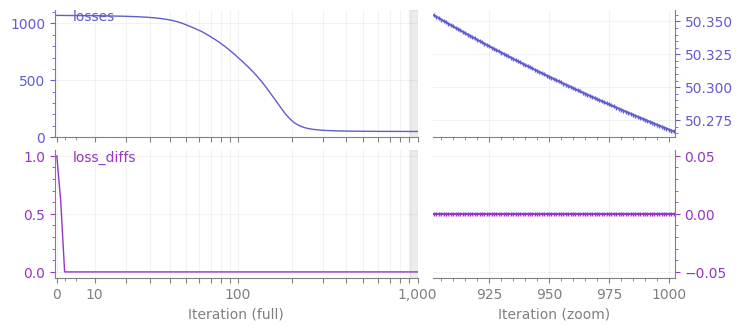

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [61]:
optmzr.plot()

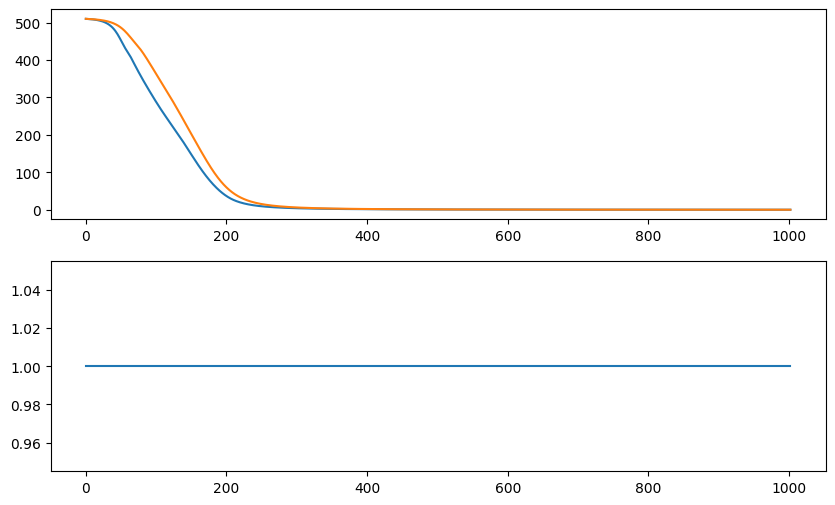

In [62]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

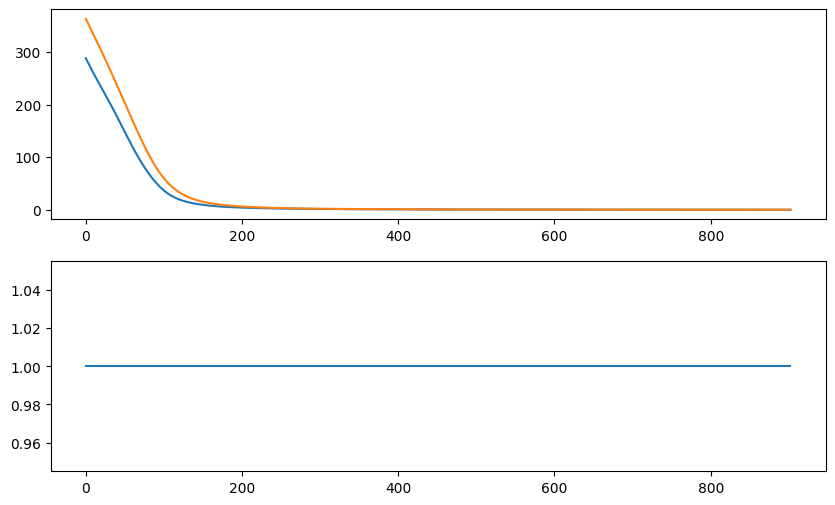

In [63]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

### Run 1

In [211]:
loss_data=list()

In [212]:
total_physical_dim = 2**num_boundary_sites

In [66]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm_b,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

_So_ much faster.

In [68]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+50.267089843750 [best: +50.267089843750] : : 1001it [00:02, 339.13it/s]                                    

In [69]:
len(loss_data)

1

But lose loss data for some reason...?

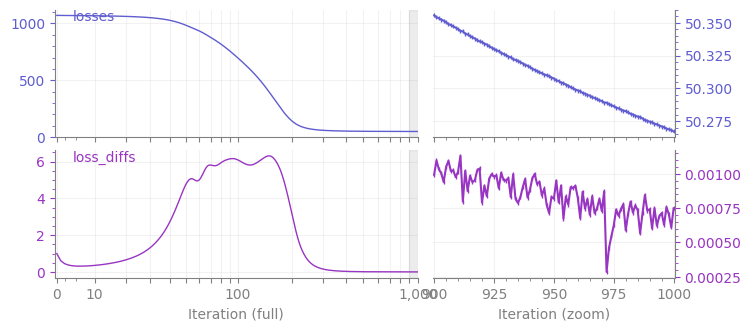

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [71]:
optmzr.plot()

In [77]:
ml, mr = split_mpo_pair(mpo_opt)

In [81]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.14044189453125, 0.12677001953125)

### Autodiff backend - autograd

In [82]:
loss_data=list()

In [85]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='autograd',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [86]:
mpo_opt = optmzr.optimize(1000)

+50.267220278802 [best: +50.267220278802] : : 1001it [00:13, 76.33it/s]                                                                                                                                     


In [87]:
len(loss_data)

1001

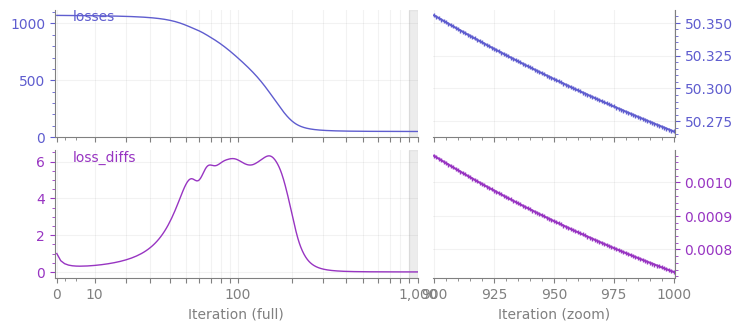

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [88]:
optmzr.plot()

In [93]:
test = loss_data[0][0]

In [99]:
test._value

1.0

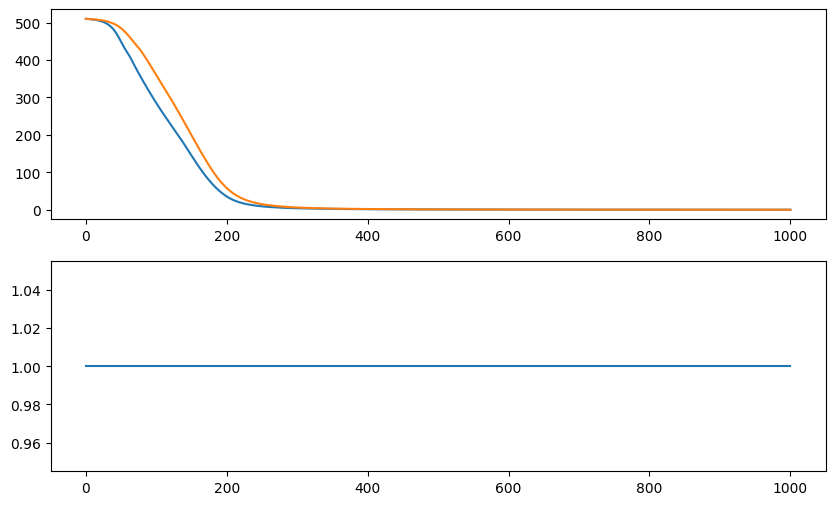

In [100]:
X = np.array([[x._value for x in l] for l in loss_data])

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

### Autodiff backend - torch

In [101]:
loss_data=list()

In [104]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='torch',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [105]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]


TypeError: tensordot(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

Not working.

## NADAM

In [106]:
loss_data=list()

In [107]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='nadam',               # supplied to scipy.minimize
)

In [108]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+50.254150390625 [best: +50.254150390625] : : 1001it [00:02, 409.11it/s]                                    

In [109]:
len(loss_data)

1

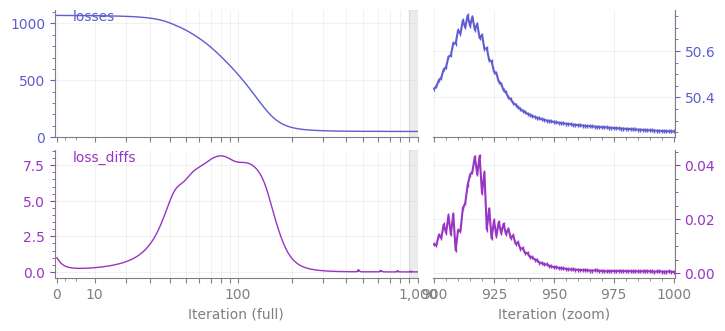

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [110]:
optmzr.plot()

In [111]:
ml, mr = split_mpo_pair(mpo_opt)

In [112]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.1427001953125, 0.111419677734375)

## RMSProp

In [113]:
loss_data=list()

In [114]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='rmsprop',               # supplied to scipy.minimize
)

In [115]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+1006.344360351562 [best: +623.192993164062] : : 1001it [00:02, 452.91it/s]                                 

In [116]:
len(loss_data)

1

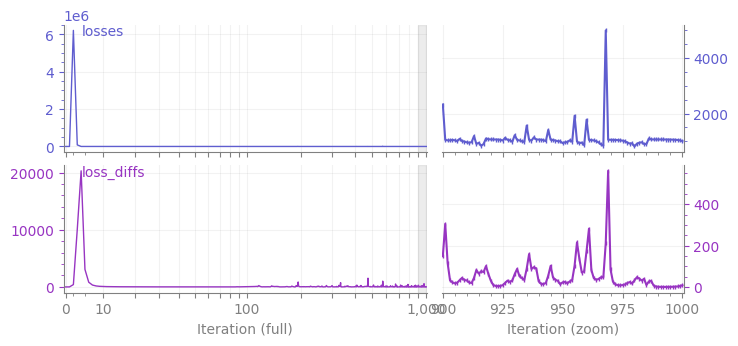

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [117]:
optmzr.plot()

In [118]:
ml, mr = split_mpo_pair(mpo_opt)

In [119]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 486.18341636657715, 470.1609573364258)

## ADAM
Seems like the best, try different learning rates. Best performance with jax.

### (1, 500)

In [120]:
loss_data=list()

In [121]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 500,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [122]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+500.267089843750 [best: +500.267089843750] : : 1001it [00:02, 467.65it/s]                                  

In [123]:
len(loss_data)

1

But lose loss data for some reason...?

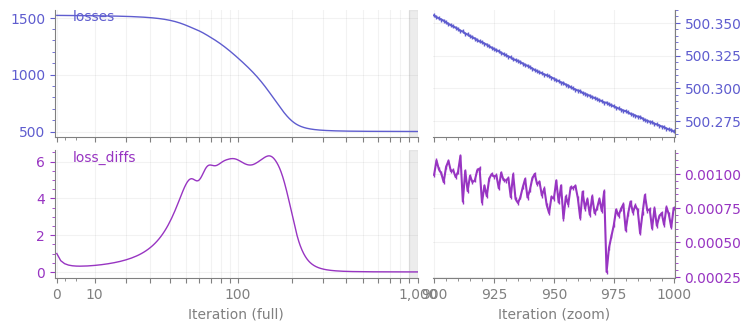

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [124]:
optmzr.plot()

In [125]:
ml, mr = split_mpo_pair(mpo_opt)

In [126]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.14044189453125, 0.12677001953125)

Made no difference at all...?

### (1, 5000)

In [127]:
loss_data=list()

In [128]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 5000,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [129]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+5000.267089843750 [best: +5000.267089843750] : : 1001it [00:02, 464.92it/s]                                

In [130]:
len(loss_data)

1

But lose loss data for some reason...?

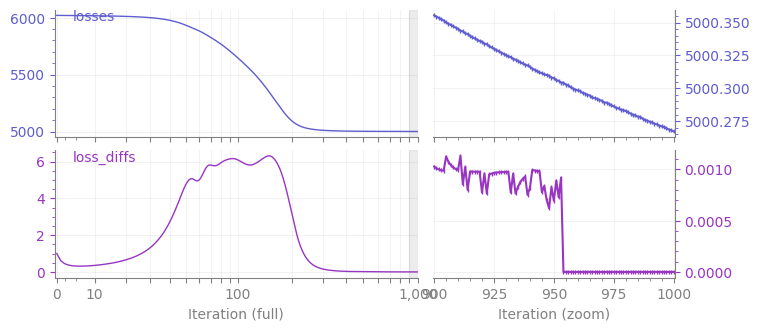

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [131]:
optmzr.plot()

In [132]:
ml, mr = split_mpo_pair(mpo_opt)

In [133]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.14044189453125, 0.12677001953125)

Made no difference at all...?

### (0.001, 0)

In [134]:
loss_data=list()

In [135]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 0.001,
        'overlap_cost_coefficient': 0,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [136]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+0.000267059339 [best: +0.000267059339] : : 1001it [00:02, 455.90it/s]                                      

In [137]:
len(loss_data)

1

But lose loss data for some reason...?

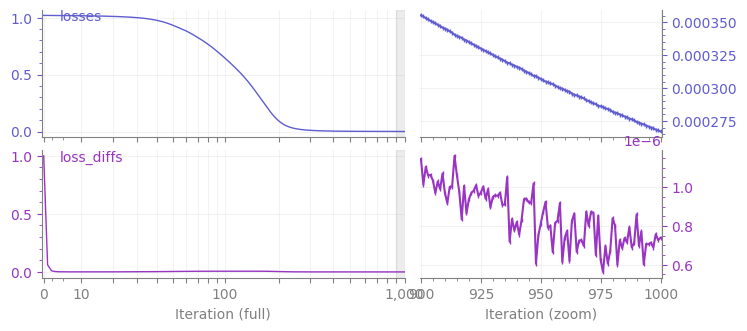

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [138]:
optmzr.plot()

In [139]:
ml, mr = split_mpo_pair(mpo_opt)

In [140]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.140380859375, 0.126708984375)

# Change num sites
Try 4 sites.

In [142]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    4
)

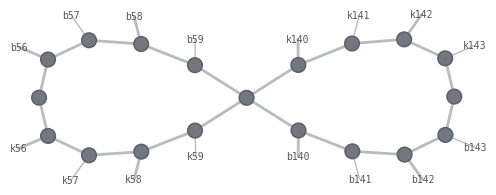

In [143]:
problem_rdm.draw()

In [144]:
num_boundary_sites=4
left_most_symmetry_site=60
num_symmetry_sites=80

In [145]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    tags='left_mpo'
)

In [146]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    tags='right_mpo'
)

In [147]:
mpo = (ml & mr)

In [155]:
total_physical_dim = 2**6

## Run 1

In [156]:
loss_data=list()

In [157]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [158]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+50.033977508545 [best: +50.033977508545] : : 1001it [00:01, 731.69it/s]                                    

In [159]:
len(loss_data)

1

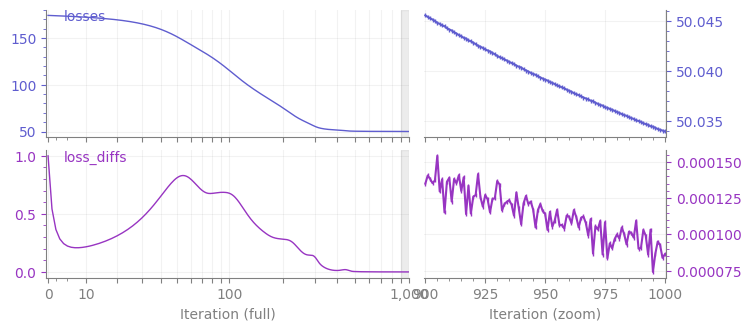

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [160]:
optmzr.plot()

In [161]:
ml, mr = split_mpo_pair(mpo_opt)

In [162]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.017894744873046875, 0.0160675048828125)

## Run 2

In [163]:
loss_data=list()

In [165]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 5000,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [166]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/jax/_src/lax/lax.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+5000.034179687500 [best: +5000.034179687500] : : 1001it [00:01, 741.00it/s]                                

In [167]:
len(loss_data)

1

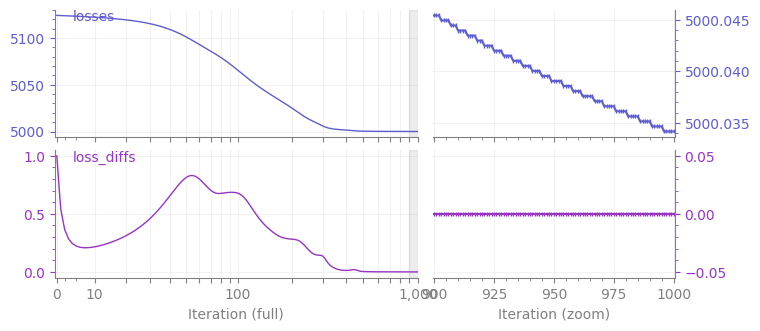

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [168]:
optmzr.plot()

In [169]:
ml, mr = split_mpo_pair(mpo_opt)

In [170]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(1.0, 0.017894744873046875, 0.0160675048828125)

# Bosonic state

Was getting different results there, double check.

In [37]:
DATA_DIR_B = r"../../data/transverse_cluster_200_site_dmrg"

In [38]:
loaded_data_b = list()

for local_file_name in os.listdir(DATA_DIR_B):
    f_name = r"{}/{}".format(DATA_DIR_B, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data_b.append(data)

In [39]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data_b))

In [40]:
psi_dict_b = dict()

In [41]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data_b
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict_b[rounded_b] = psi

In [42]:
psi_b = psi_dict_b[0]

In [43]:
from collections import Counter

In [44]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [45]:
psi_arrays_b = list()
psi_arrays_b.append(psi_b.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi_b.L-1):
    psi_arrays_b.append(psi_b.get_B(i).to_ndarray())
psi_arrays_b.append(psi_b.get_B(psi.L-1)[..., 0].to_ndarray())

In [46]:
np_X = np.array([[0,1],[1,0]])

In [47]:
q_b = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays_b,
        shape='lpr'
    )
)

In [48]:
q_b

MatrixProductState(tensors=200, indices=399, L=200, max_bond=2)

In [49]:
symmetry_site_pairs = [
    (i, np_X) for i in range(50, 50+100, 2)
]

problem_rdm_b = generate_problem_rdm(
    q_b,
    symmetry_site_pairs,
    50,
    100,
    3
)

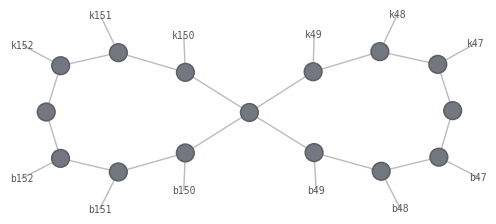

In [50]:
problem_rdm_b.draw()

In [51]:
num_boundary_sites=3
left_most_symmetry_site=50
num_symmetry_sites=100

In [52]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=2,
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    tags='left_mpo'
)

In [53]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=2,
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    tags='right_mpo'
)

In [54]:
mpo = (ml & mr)

### Autodiff backend - jax

In [55]:
total_physical_dim = 2**num_boundary_sites

In [56]:
loss_data=list()

In [57]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm_b,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [58]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from float32 to float64.
  warnings.warn(
+0.047419186682 [best: +0.047419186682] : : 1001it [00:01, 785.15it/s]                                                                                                                                      


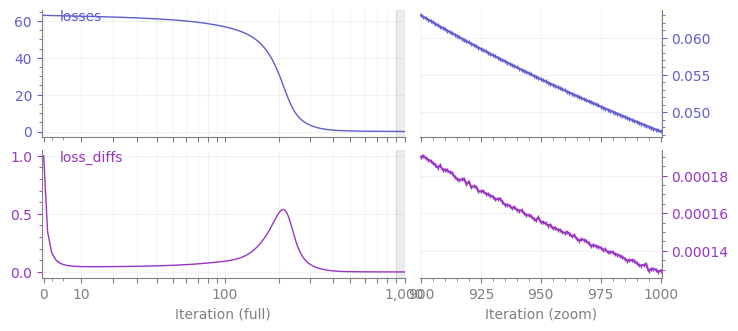

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [59]:
optmzr.plot()

In [60]:
ml, mr = split_mpo_pair(mpo_opt)

In [61]:
(
    overlap_loss_function(ml, mr, problem_rdm_b),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(7.777235890082316e-05, 0.034870147705078125, 0.008661270141601562)

## Complex vs real check

In [77]:
psi_b.get_B(100).to_ndarray()

array([[[-0.19632461, -0.38599512],
        [ 0.80341909, -0.40863453]],

       [[ 0.40863453,  0.80341909],
        [ 0.38599512, -0.19632461]]])

In [78]:
psi.get_B(101).shape

(4, 2, 4)

In [79]:
psi.get_B(100).shape

(4, 4, 4)

In [80]:
psi.get_B(101).to_ndarray()

array([[[ 3.14378968e-01+0.00000000e+00j,
         -1.66704300e-01-7.34875641e-01j,
         -3.04793580e-14-1.77900229e-15j,
          2.09545265e-14+3.62075333e-14j],
        [-7.34077495e-14-1.48123705e-14j,
          1.29884997e-14+4.81758510e-15j,
         -2.87399715e-01-2.21846261e-01j,
          4.26335568e-01-1.40559442e-01j]],

       [[ 7.53546635e-01+0.00000000e+00j,
          6.95488817e-02+3.06589446e-01j,
         -7.49796677e-14-1.10686386e-14j,
          3.86630902e-14-6.71726455e-15j],
        [ 4.15117195e-14+1.60284002e-14j,
         -1.57210186e-14+1.62514375e-14j,
          1.71668126e-01-4.14787932e-01j,
         -2.00010445e-01-3.03001950e-01j]],

       [[-1.69638964e-14+0.00000000e+00j,
          1.94447434e-15-4.06799614e-14j,
         -4.20840238e-15+2.58140239e-15j,
          8.23565434e-17+3.73641324e-17j],
        [ 6.48636989e-01+7.59241467e-01j,
         -4.94064200e-02+1.95309417e-02j,
         -3.56725827e-14-4.62130547e-14j,
          5.30617512e-14+

In [81]:
psi.get_B(100).to_ndarray()

array([[[-0.22831328-4.27738929e-03j, -0.53752544-1.54876821e-01j,
         -0.01773409-1.64377445e-02j,  0.34393419+5.30389929e-02j],
        [-0.22831328-4.27738929e-03j, -0.53752544-1.54876821e-01j,
          0.01773409+1.64377445e-02j, -0.34393419-5.30389929e-02j],
        [ 0.01958421+9.01763986e-02j,  0.00180529-3.76263173e-02j,
         -0.0173468 +5.47231084e-02j,  0.00113107+3.82514376e-03j],
        [ 0.01958421+9.01763986e-02j,  0.00180529-3.76263173e-02j,
          0.0173468 -5.47231084e-02j, -0.00113107-3.82514376e-03j]],

       [[ 0.03672217-8.39529391e-03j,  0.0922152 +3.41762333e-03j,
          0.00349289+1.92632799e-03j, -0.05717189+5.18703085e-03j],
        [ 0.03672217-8.39529391e-03j,  0.0922152 +3.41762333e-03j,
         -0.00349289-1.92632799e-03j,  0.05717189-5.18703085e-03j],
        [ 0.24700837+5.01903667e-01j, -0.04436906-2.24001422e-01j,
         -0.02207814+3.47298744e-01j,  0.01224465+2.08510458e-02j],
        [ 0.24700837+5.01903667e-01j, -0.04436906-2.2

So this is the difference, the wavefunction is complex.

# Conclusion
Need to work around this "complex" issue.